In [1]:
import os
import random
import numpy as np
import tensorflow as tf

from easydict import EasyDict as edict
import matplotlib.pyplot as plt

# modules
from dataloader import Cifar10DataLoader, MnistDataLoader
from dnn import DNN
from unet import CUNet
from diffusion import DiffusionUnet

2023-02-14 08:32:16.261362: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-14 08:32:16.395293: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
dataloader_args = edict({"batch_size": 128, "epochs": 20, "da": True})
dataloader = MnistDataLoader(dataloader_args=dataloader_args)
train_dataset, valid_dataset, test_dataset = dataloader.load_dataset()

def display(display_list, save_name=None):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'Predicted Image', 'Test Image']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  if save_name!=None:
    plt.savefig("./result/{}.png".format(save_name))
  plt.show()

def plot_train(display_list):
  # plt.figure(figsize=(10, 10))
  label = ['Train', 'Test']
  for i in range(len(display_list)):
    plt.plot(display_list[i], label=label[i])
  plt.legend()
  plt.show()
  

2023-02-14 08:32:19.325367: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-14 08:32:20.348996: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14042 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:17:00.0, compute capability: 8.6


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [3]:
model_args = edict({"units":[128,64,32,10], "activations":["relu","relu","relu","softmax"]})
model = DNN(units=model_args.units, activations=model_args.activations)

In [4]:
train_loss_fn = tf.keras.losses.CategoricalCrossentropy()
mt_loss_fn = tf.keras.metrics.Mean()
test_loss_fn = tf.keras.losses.CategoricalCrossentropy()
mte_loss_fn = tf.keras.metrics.Mean()
opt_loss_fn = tf.keras.losses.CategoricalCrossentropy()

train_metrics = tf.keras.metrics.CategoricalAccuracy()
test_metrics = tf.keras.metrics.CategoricalAccuracy()
optimizer = tf.keras.optimizers.SGD(0.1)

In [5]:
# @tf.function(experimental_relax_shapes=True, experimental_compile=None)
def _train_step(inputs, labels, first_batch=False):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = train_loss_fn(labels, predictions)
        metrics = tf.reduce_mean(train_metrics(labels, predictions))
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    mt_loss_fn.update_state(loss)
    
    return loss, metrics

def _test_step(inputs, labels):
    predictions = model(inputs)
    loss = test_loss_fn(labels, predictions)
    opt_loss = opt_loss_fn(labels, predictions)
    metrics = tf.reduce_mean(test_metrics(labels, predictions))
    mte_loss_fn.update_state(loss)
    
    return loss, metrics, opt_loss

In [6]:
iter_train = iter(train_dataset)
iter_valid = iter(valid_dataset)
iter_test = iter(test_dataset)
test_data =  iter_test.get_next()
# train_data = iter_train.get_next()
# test_data["inputs"].shape
# # train_data["inputs"].shape
# display([test_data["inputs"][0],test_data["inputs"][1],test_data["inputs"][2]])

In [7]:
model_opt = []
opt_label = []
def collect_model_operator(variables, loss):
    weights = [w.numpy() for w in variables]
    opt = DNN(units=model_args.units, 
            activations=model_args.activations,
            init_value=weights)
    opt_label.append(loss)
    model_opt.append(opt)

records = edict({'epoch':[],'train_loss':[],'test_loss':[],'train_metric':[],'test_metric':[]})
def obtain_model_opts(sample_start=30, sample_gap=20):
    for e in range(dataloader.info.epochs):
        mt_loss_fn.reset_states()
        train_metrics.reset_states()
        mte_loss_fn.reset_states()
        test_metrics.reset_states()
        for step in range(dataloader.info.train_step):
            data = iter_train.get_next()
            train_loss, acc = _train_step(inputs=data["inputs"], labels=data["labels"])
            if (e*dataloader.info.train_step + step)%sample_gap ==0:
                if e >= sample_start:
                    test_loss, test_acc, opt_loss = _test_step(inputs=test_data["inputs"], labels=test_data["labels"])
                    collect_model_operator(model.trainable_variables, opt_loss)
                    
        test_loss, test_acc, _ = _test_step(inputs=test_data["inputs"], labels=test_data["labels"])
        records.epoch        += [e]
        records.train_loss   += [mt_loss_fn.result().numpy()]
        records.train_metric += [train_metrics.result().numpy()]
        records.test_loss    += [mte_loss_fn.result().numpy()]
        records.test_metric  += [test_metrics.result().numpy()]
        log = ""
        for k,v in records.items():
            log += "{}: {} ".format(k,v[-1])
        print(log)

In [8]:

def init_model_opt(raw_model_opt, data):
    
    def opt_test_step(opt, inputs, labels):
        predictions = opt(inputs)
        loss = test_loss_fn(labels, predictions)
        metrics = tf.reduce_mean(test_metrics(labels, predictions))
        mte_loss_fn.update_state(loss)
        return loss, metrics

    for idx in range(len(raw_model_opt)):
        mte_loss_fn.reset_states()
        test_metrics.reset_states()
        for step in range(1):
            data = test_data
            test_loss, test_acc = opt_test_step(opt=raw_model_opt[idx], inputs=data["inputs"], labels=data["labels"])
        print("Init: opt_id:{}, Test loss:{}, Test acc:{}".format(idx,
                                                        mte_loss_fn.result().numpy(),
                                                        test_metrics.result().numpy()))
            
def hard_save_model_opt(online_model_opt, path="./model_opt"):
    init_model_opt(online_model_opt, test_data)
    for idx in range(len(online_model_opt)):
        mpath = os.path.join(path, "opt_{}".format(idx))
        online_model_opt[idx].save(mpath, overwrite=True, save_format='tf')

def load_model_opt(path="./model_opt"):
    offline_model_opt = []
    model_opt_list = os.listdir(path=path)
    for idx in range(len(model_opt_list)):
        mpath = os.path.join(path,  "opt_{}".format(idx))
        offline_model_opt.append(tf.keras.models.load_model(mpath))
    init_model_opt(offline_model_opt, test_data)
    return offline_model_opt

In [9]:
GIAO_EPOCH = 1
GIAO_BATCH = 1

giao_optimizer = tf.keras.optimizers.Adam(1e-4)
giao_loss_fn = tf.keras.losses.MeanSquaredError()
def _opt_train_step(unet, regs, train_inputs, train_labels, labels):
    losses = []
    
    with tf.GradientTape() as tape:
        pseudo_inputs, train_latent_phase = unet(train_inputs)
        _, pseudo_latent_phase= unet(pseudo_inputs)
      
        for idx in range(len(regs)):
            predictions = regs[idx](pseudo_inputs)
            l1_loss = tf.reduce_mean(tf.abs(pseudo_inputs - train_inputs)) * 128
            phase_loss = tf.reduce_mean(tf.abs(pseudo_latent_phase - train_latent_phase)) * 1024
            print(phase_loss)
            reg_loss = opt_loss_fn(train_labels, predictions)
            # giao_loss = giao_loss_fn(labels[idx], reg_loss)
            giao_loss =  tf.abs(labels[idx]-reg_loss) + phase_loss + l1_loss
            losses.append(giao_loss)
        loss = tf.reduce_mean(losses)
        grad = tape.gradient(loss, unet.model.trainable_variables)
        
        
    giao_optimizer.apply_gradients(zip(grad, unet.model.trainable_variables))
    return loss, pseudo_inputs

In [10]:
def obtain_da_model_opts(unet, sample_start=0, sample_gap=3, epochs=3):
    for e in range(epochs):
        mt_loss_fn.reset_states()
        train_metrics.reset_states()
        mte_loss_fn.reset_states()
        test_metrics.reset_states()
        for step in range(dataloader.info.train_step):
            data = iter_train.get_next()
            da_data_inputs,_ = unet(data["inputs"])
            train_loss, acc = _train_step(inputs=da_data_inputs, labels=data["labels"])
            if (e*dataloader.info.train_step + step)%sample_gap == 0:
                if e >= sample_start:
                    test_loss, test_acc, opt_loss = _test_step(inputs=test_data["inputs"], labels=test_data["labels"])
                    collect_model_operator(model.trainable_variables, opt_loss)
                    
        test_loss, test_acc, _ = _test_step(inputs=test_data["inputs"], labels=test_data["labels"])
        records.epoch        += [e]
        records.train_loss   += [mt_loss_fn.result().numpy()]
        records.train_metric += [train_metrics.result().numpy()]
        records.test_loss    += [mte_loss_fn.result().numpy()]
        records.test_metric  += [test_metrics.result().numpy()]
        log = ""
        for k,v in records.items():
            log += "{}: {} ".format(k,v[-1])
        print(log)

In [11]:
# init training
obtain_model_opts(sample_start=3, sample_gap=10) 
print(len(model_opt))

2023-02-14 08:32:23.795786: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-14 08:32:23.896992: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x471859f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-14 08:32:23.897023: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2023-02-14 08:32:23.988363: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


epoch: 0 train_loss: 0.5347142815589905 test_loss: 0.17767667770385742 train_metric: 0.8278045058250427 test_metric: 0.9296875 
epoch: 1 train_loss: 0.1836400032043457 test_loss: 0.11361710727214813 train_metric: 0.9445913434028625 test_metric: 0.9609375 
epoch: 2 train_loss: 0.12810620665550232 test_loss: 0.09878260642290115 train_metric: 0.9607972502708435 test_metric: 0.9765625 
epoch: 3 train_loss: 0.09884768724441528 test_loss: 0.09556937962770462 train_metric: 0.9702924489974976 test_metric: 0.9761718511581421 
epoch: 4 train_loss: 0.08357014507055283 test_loss: 0.08265035599470139 train_metric: 0.9743790030479431 test_metric: 0.978710949420929 
epoch: 5 train_loss: 0.06998055428266525 test_loss: 0.07733764499425888 train_metric: 0.978044867515564 test_metric: 0.9794921875 
epoch: 6 train_loss: 0.0575329028069973 test_loss: 0.07564171403646469 train_metric: 0.9817107319831848 test_metric: 0.98046875 
epoch: 7 train_loss: 0.05088191479444504 test_loss: 0.06676766276359558 train_me

2023-02-14 08:35:27.240388: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100


tf.Tensor(26.249413, shape=(), dtype=float32)


2023-02-14 08:35:29.454688: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


Epoch:0 GIAO Train Loss:118.70372772216797


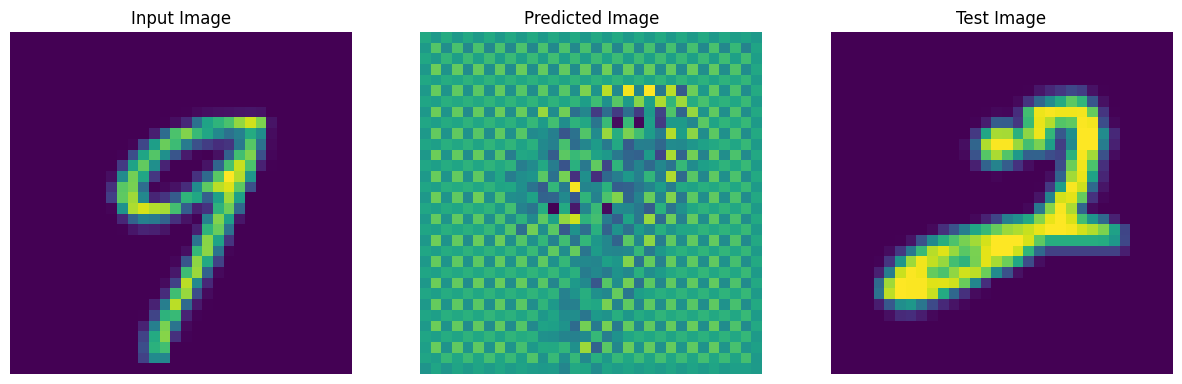

tf.Tensor(25.794775, shape=(), dtype=float32)
tf.Tensor(25.057798, shape=(), dtype=float32)
tf.Tensor(24.576073, shape=(), dtype=float32)
tf.Tensor(24.488352, shape=(), dtype=float32)
tf.Tensor(23.893915, shape=(), dtype=float32)
tf.Tensor(23.782946, shape=(), dtype=float32)
tf.Tensor(23.112234, shape=(), dtype=float32)
tf.Tensor(22.796488, shape=(), dtype=float32)
tf.Tensor(22.866135, shape=(), dtype=float32)
tf.Tensor(21.88626, shape=(), dtype=float32)
tf.Tensor(21.482132, shape=(), dtype=float32)
tf.Tensor(21.314472, shape=(), dtype=float32)
tf.Tensor(20.831503, shape=(), dtype=float32)
tf.Tensor(20.280968, shape=(), dtype=float32)
tf.Tensor(20.139868, shape=(), dtype=float32)
tf.Tensor(19.765394, shape=(), dtype=float32)
tf.Tensor(19.794243, shape=(), dtype=float32)
tf.Tensor(18.898006, shape=(), dtype=float32)
tf.Tensor(19.158335, shape=(), dtype=float32)
tf.Tensor(18.705938, shape=(), dtype=float32)
tf.Tensor(18.240557, shape=(), dtype=float32)
tf.Tensor(17.830473, shape=(), dtyp

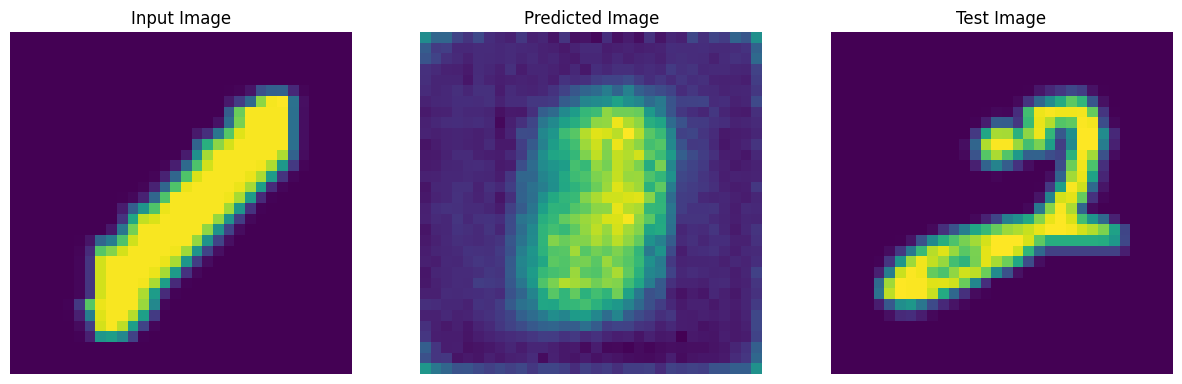

tf.Tensor(8.253477, shape=(), dtype=float32)
tf.Tensor(8.5012045, shape=(), dtype=float32)
tf.Tensor(8.498035, shape=(), dtype=float32)
tf.Tensor(8.257407, shape=(), dtype=float32)
tf.Tensor(8.077752, shape=(), dtype=float32)
tf.Tensor(8.443865, shape=(), dtype=float32)
tf.Tensor(8.344242, shape=(), dtype=float32)
tf.Tensor(7.8932943, shape=(), dtype=float32)
tf.Tensor(7.973682, shape=(), dtype=float32)
tf.Tensor(8.108256, shape=(), dtype=float32)
tf.Tensor(7.589774, shape=(), dtype=float32)
tf.Tensor(7.823392, shape=(), dtype=float32)
tf.Tensor(7.787736, shape=(), dtype=float32)
tf.Tensor(7.737576, shape=(), dtype=float32)
tf.Tensor(8.06048, shape=(), dtype=float32)
tf.Tensor(7.9745417, shape=(), dtype=float32)
tf.Tensor(7.987686, shape=(), dtype=float32)
tf.Tensor(7.8138294, shape=(), dtype=float32)
tf.Tensor(7.7460256, shape=(), dtype=float32)
tf.Tensor(7.609434, shape=(), dtype=float32)
tf.Tensor(7.6088495, shape=(), dtype=float32)
tf.Tensor(7.4237323, shape=(), dtype=float32)
tf.T

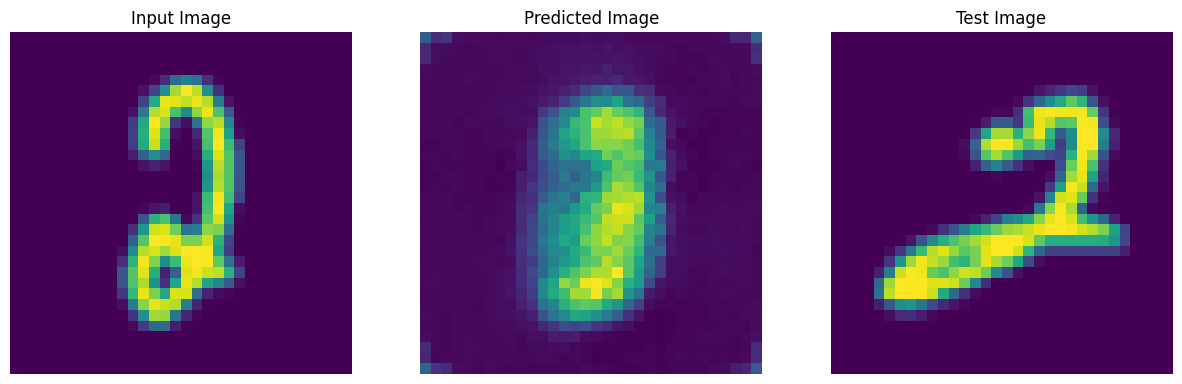

tf.Tensor(5.683529, shape=(), dtype=float32)
tf.Tensor(5.641296, shape=(), dtype=float32)
tf.Tensor(5.7878456, shape=(), dtype=float32)
tf.Tensor(5.5793557, shape=(), dtype=float32)
tf.Tensor(5.6524553, shape=(), dtype=float32)
tf.Tensor(5.676981, shape=(), dtype=float32)
tf.Tensor(5.696342, shape=(), dtype=float32)
tf.Tensor(5.6606116, shape=(), dtype=float32)
tf.Tensor(5.814714, shape=(), dtype=float32)
tf.Tensor(5.505668, shape=(), dtype=float32)
tf.Tensor(5.6523285, shape=(), dtype=float32)
tf.Tensor(5.681458, shape=(), dtype=float32)
tf.Tensor(5.413597, shape=(), dtype=float32)
tf.Tensor(5.7245026, shape=(), dtype=float32)
tf.Tensor(5.6093106, shape=(), dtype=float32)
tf.Tensor(5.592927, shape=(), dtype=float32)
tf.Tensor(5.634977, shape=(), dtype=float32)
tf.Tensor(5.63916, shape=(), dtype=float32)
tf.Tensor(5.531274, shape=(), dtype=float32)
tf.Tensor(5.3231936, shape=(), dtype=float32)
tf.Tensor(5.4738955, shape=(), dtype=float32)
tf.Tensor(5.4570727, shape=(), dtype=float32)
t

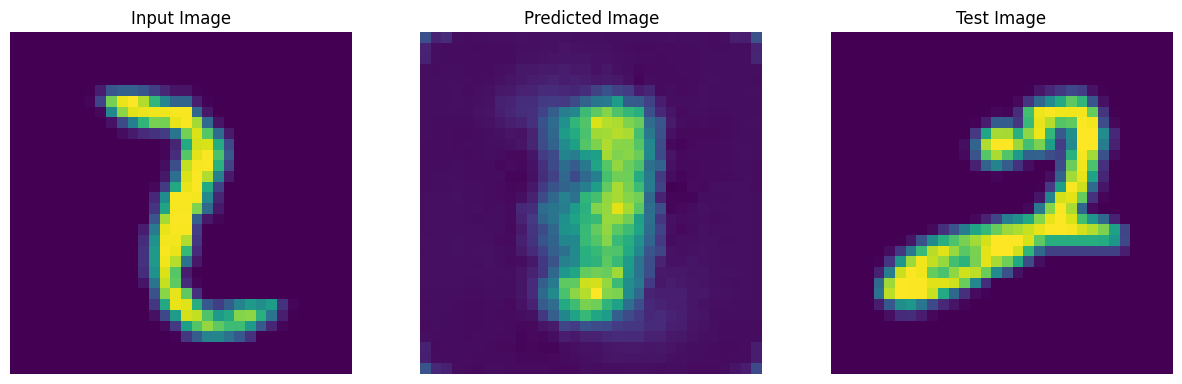

tf.Tensor(4.674553, shape=(), dtype=float32)
tf.Tensor(4.924752, shape=(), dtype=float32)
tf.Tensor(4.7033234, shape=(), dtype=float32)
tf.Tensor(4.7501583, shape=(), dtype=float32)
tf.Tensor(4.6444497, shape=(), dtype=float32)
tf.Tensor(4.65633, shape=(), dtype=float32)
tf.Tensor(4.7275357, shape=(), dtype=float32)
tf.Tensor(4.790627, shape=(), dtype=float32)
tf.Tensor(4.7152247, shape=(), dtype=float32)
tf.Tensor(4.662217, shape=(), dtype=float32)
tf.Tensor(4.4799805, shape=(), dtype=float32)
tf.Tensor(4.7547174, shape=(), dtype=float32)
tf.Tensor(4.6412387, shape=(), dtype=float32)
tf.Tensor(4.7337227, shape=(), dtype=float32)
tf.Tensor(4.7246532, shape=(), dtype=float32)
tf.Tensor(4.536052, shape=(), dtype=float32)
tf.Tensor(4.714719, shape=(), dtype=float32)
tf.Tensor(4.657182, shape=(), dtype=float32)
tf.Tensor(4.67898, shape=(), dtype=float32)
tf.Tensor(4.6294327, shape=(), dtype=float32)
tf.Tensor(4.508411, shape=(), dtype=float32)
tf.Tensor(4.579818, shape=(), dtype=float32)
t

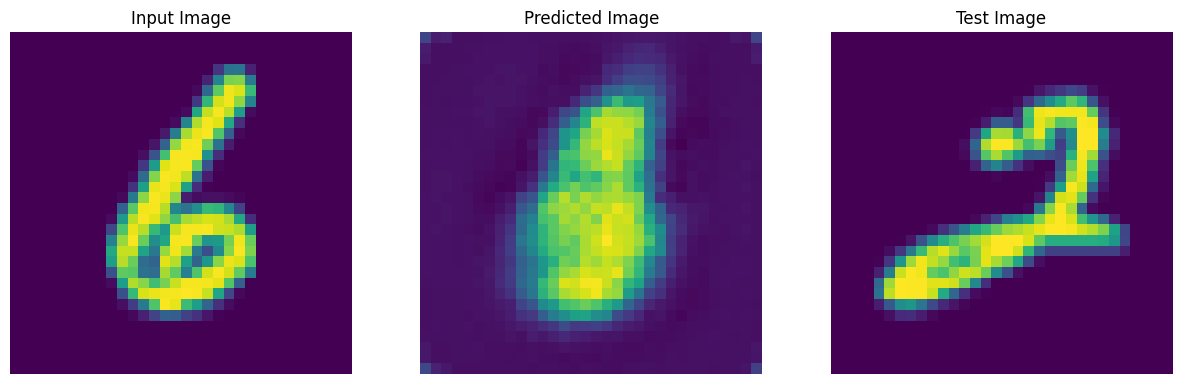

tf.Tensor(4.406279, shape=(), dtype=float32)
tf.Tensor(4.295559, shape=(), dtype=float32)
tf.Tensor(4.528505, shape=(), dtype=float32)
tf.Tensor(4.516334, shape=(), dtype=float32)
tf.Tensor(4.5461597, shape=(), dtype=float32)
tf.Tensor(4.6744432, shape=(), dtype=float32)
tf.Tensor(4.586229, shape=(), dtype=float32)
tf.Tensor(4.5190277, shape=(), dtype=float32)
tf.Tensor(4.407079, shape=(), dtype=float32)
tf.Tensor(4.3242884, shape=(), dtype=float32)
tf.Tensor(4.356713, shape=(), dtype=float32)
tf.Tensor(4.4967546, shape=(), dtype=float32)
tf.Tensor(4.358603, shape=(), dtype=float32)
tf.Tensor(4.257965, shape=(), dtype=float32)
tf.Tensor(4.5241504, shape=(), dtype=float32)
tf.Tensor(4.4486823, shape=(), dtype=float32)
tf.Tensor(4.420003, shape=(), dtype=float32)
tf.Tensor(4.439813, shape=(), dtype=float32)
tf.Tensor(4.3277593, shape=(), dtype=float32)
tf.Tensor(4.578872, shape=(), dtype=float32)
tf.Tensor(4.4037256, shape=(), dtype=float32)
tf.Tensor(4.5005603, shape=(), dtype=float32)


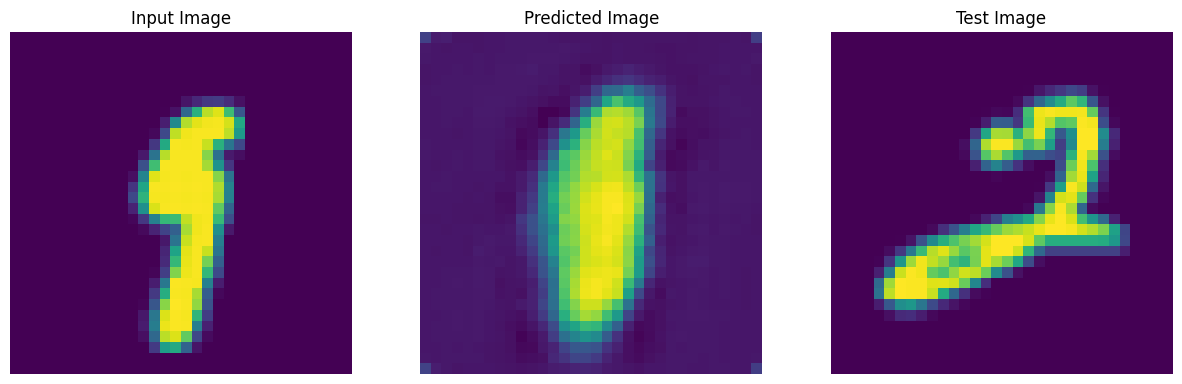

tf.Tensor(4.148826, shape=(), dtype=float32)
tf.Tensor(4.2198415, shape=(), dtype=float32)
tf.Tensor(4.0834312, shape=(), dtype=float32)
tf.Tensor(4.081451, shape=(), dtype=float32)
tf.Tensor(4.1257257, shape=(), dtype=float32)
tf.Tensor(4.151794, shape=(), dtype=float32)
tf.Tensor(4.1047707, shape=(), dtype=float32)
tf.Tensor(4.1532354, shape=(), dtype=float32)
tf.Tensor(4.149041, shape=(), dtype=float32)
tf.Tensor(4.2859983, shape=(), dtype=float32)
tf.Tensor(4.1047688, shape=(), dtype=float32)
tf.Tensor(4.120491, shape=(), dtype=float32)
tf.Tensor(4.0957117, shape=(), dtype=float32)
tf.Tensor(4.221271, shape=(), dtype=float32)
tf.Tensor(4.0050592, shape=(), dtype=float32)
tf.Tensor(4.0505557, shape=(), dtype=float32)
tf.Tensor(4.188686, shape=(), dtype=float32)
tf.Tensor(4.0716405, shape=(), dtype=float32)
tf.Tensor(4.1084027, shape=(), dtype=float32)
tf.Tensor(4.0662, shape=(), dtype=float32)
tf.Tensor(4.108819, shape=(), dtype=float32)
tf.Tensor(4.0995555, shape=(), dtype=float32)

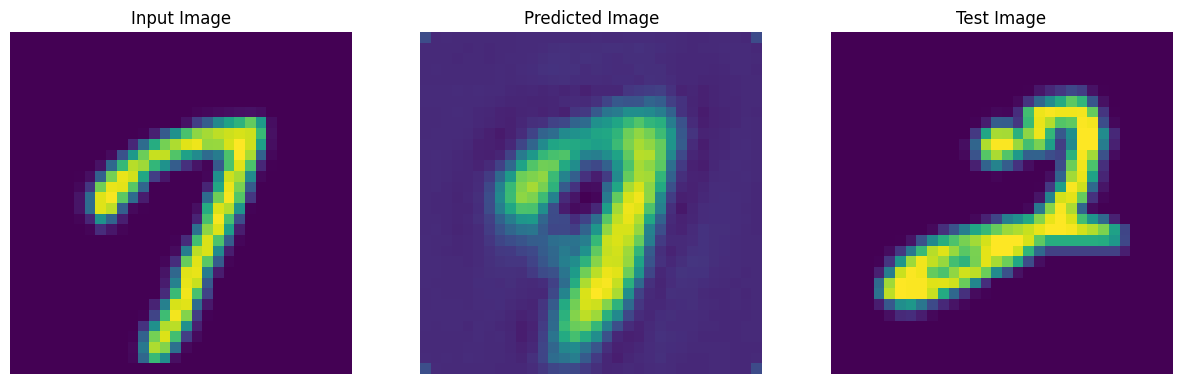

tf.Tensor(3.8341157, shape=(), dtype=float32)
tf.Tensor(3.8651645, shape=(), dtype=float32)
tf.Tensor(3.873499, shape=(), dtype=float32)
tf.Tensor(3.8262386, shape=(), dtype=float32)
tf.Tensor(3.9076767, shape=(), dtype=float32)
tf.Tensor(3.9293866, shape=(), dtype=float32)
tf.Tensor(3.8463838, shape=(), dtype=float32)
tf.Tensor(3.9444757, shape=(), dtype=float32)
tf.Tensor(3.8772194, shape=(), dtype=float32)
tf.Tensor(3.840916, shape=(), dtype=float32)
tf.Tensor(3.8699958, shape=(), dtype=float32)
tf.Tensor(3.924744, shape=(), dtype=float32)
tf.Tensor(3.9159822, shape=(), dtype=float32)
tf.Tensor(3.8495965, shape=(), dtype=float32)
tf.Tensor(3.857212, shape=(), dtype=float32)
tf.Tensor(4.0213203, shape=(), dtype=float32)
tf.Tensor(3.7760978, shape=(), dtype=float32)
tf.Tensor(3.9753275, shape=(), dtype=float32)
tf.Tensor(3.8145118, shape=(), dtype=float32)
tf.Tensor(3.7717824, shape=(), dtype=float32)
tf.Tensor(3.9084103, shape=(), dtype=float32)
tf.Tensor(3.9222927, shape=(), dtype=f

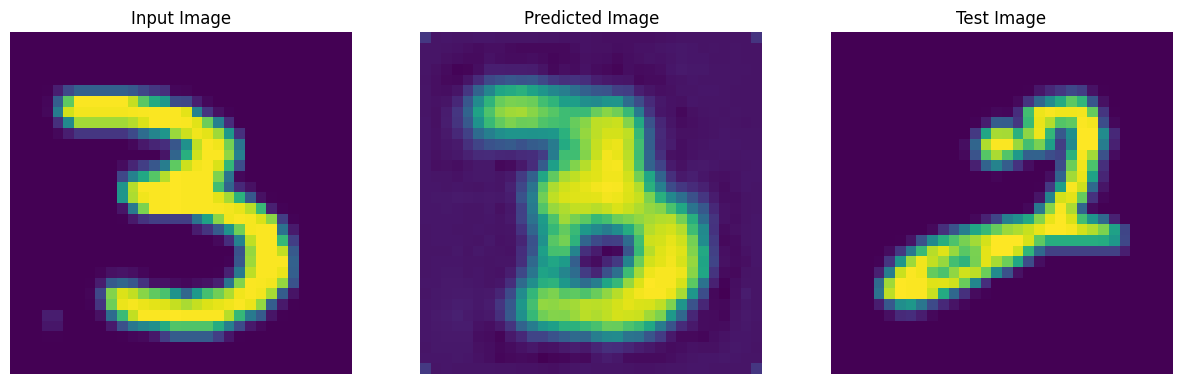

tf.Tensor(3.59245, shape=(), dtype=float32)
tf.Tensor(3.5460417, shape=(), dtype=float32)
tf.Tensor(3.535697, shape=(), dtype=float32)
tf.Tensor(3.6092882, shape=(), dtype=float32)
tf.Tensor(3.5488052, shape=(), dtype=float32)
tf.Tensor(3.6116934, shape=(), dtype=float32)
tf.Tensor(3.5167491, shape=(), dtype=float32)
tf.Tensor(3.4891808, shape=(), dtype=float32)
tf.Tensor(3.4854622, shape=(), dtype=float32)
tf.Tensor(3.526977, shape=(), dtype=float32)
tf.Tensor(3.5530224, shape=(), dtype=float32)
tf.Tensor(3.51322, shape=(), dtype=float32)
tf.Tensor(3.5003183, shape=(), dtype=float32)
tf.Tensor(3.7026772, shape=(), dtype=float32)
tf.Tensor(3.6218135, shape=(), dtype=float32)
tf.Tensor(3.5627923, shape=(), dtype=float32)
tf.Tensor(3.6425433, shape=(), dtype=float32)
tf.Tensor(3.4849973, shape=(), dtype=float32)
tf.Tensor(3.5587442, shape=(), dtype=float32)
tf.Tensor(3.4613338, shape=(), dtype=float32)
tf.Tensor(3.5624585, shape=(), dtype=float32)
tf.Tensor(3.485714, shape=(), dtype=floa

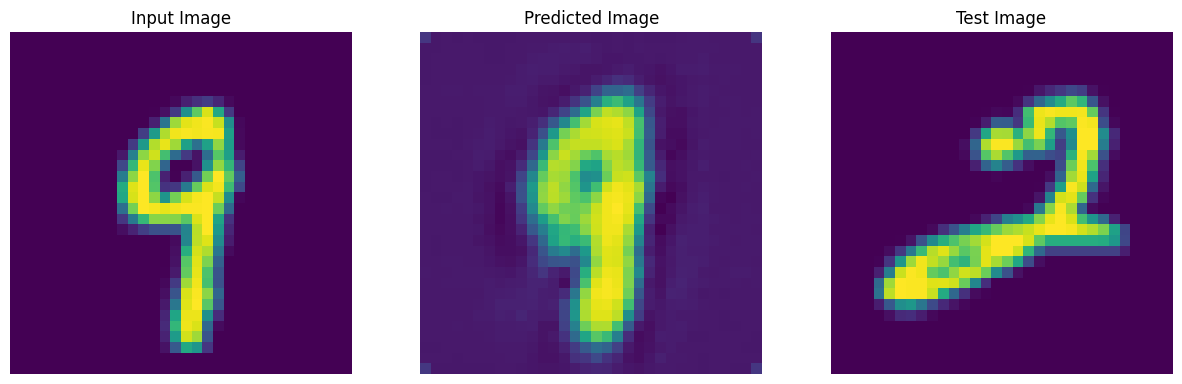

tf.Tensor(3.346721, shape=(), dtype=float32)
tf.Tensor(3.3933072, shape=(), dtype=float32)
tf.Tensor(3.282559, shape=(), dtype=float32)
tf.Tensor(3.3584933, shape=(), dtype=float32)
tf.Tensor(3.3005564, shape=(), dtype=float32)
tf.Tensor(3.2340345, shape=(), dtype=float32)
tf.Tensor(3.4587831, shape=(), dtype=float32)
tf.Tensor(3.432024, shape=(), dtype=float32)
tf.Tensor(3.32816, shape=(), dtype=float32)
tf.Tensor(3.384597, shape=(), dtype=float32)
tf.Tensor(3.3818307, shape=(), dtype=float32)
tf.Tensor(3.3074796, shape=(), dtype=float32)
tf.Tensor(3.3607712, shape=(), dtype=float32)
tf.Tensor(3.2545235, shape=(), dtype=float32)
tf.Tensor(3.296361, shape=(), dtype=float32)
tf.Tensor(3.302176, shape=(), dtype=float32)
tf.Tensor(3.2331443, shape=(), dtype=float32)
tf.Tensor(3.2565918, shape=(), dtype=float32)
tf.Tensor(3.3293343, shape=(), dtype=float32)
tf.Tensor(3.3161325, shape=(), dtype=float32)
tf.Tensor(3.2962384, shape=(), dtype=float32)
tf.Tensor(3.3606005, shape=(), dtype=float

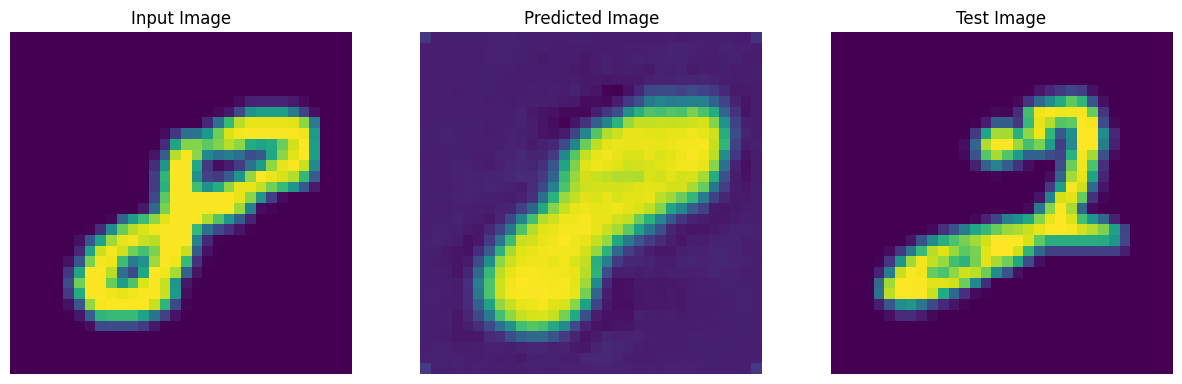

tf.Tensor(3.1455698, shape=(), dtype=float32)
tf.Tensor(3.092888, shape=(), dtype=float32)
tf.Tensor(3.0124218, shape=(), dtype=float32)
tf.Tensor(3.150484, shape=(), dtype=float32)
tf.Tensor(3.1238055, shape=(), dtype=float32)
tf.Tensor(3.0102196, shape=(), dtype=float32)
tf.Tensor(3.0589523, shape=(), dtype=float32)
tf.Tensor(3.1209195, shape=(), dtype=float32)
tf.Tensor(3.1490386, shape=(), dtype=float32)
tf.Tensor(3.0039277, shape=(), dtype=float32)
tf.Tensor(3.0904162, shape=(), dtype=float32)
tf.Tensor(3.0179892, shape=(), dtype=float32)
tf.Tensor(3.098403, shape=(), dtype=float32)
tf.Tensor(3.1074138, shape=(), dtype=float32)
tf.Tensor(3.1169577, shape=(), dtype=float32)
tf.Tensor(3.0768628, shape=(), dtype=float32)
tf.Tensor(2.9126654, shape=(), dtype=float32)
tf.Tensor(3.0768347, shape=(), dtype=float32)
tf.Tensor(2.9854238, shape=(), dtype=float32)
tf.Tensor(3.114348, shape=(), dtype=float32)
tf.Tensor(3.0432198, shape=(), dtype=float32)
tf.Tensor(3.1141186, shape=(), dtype=f

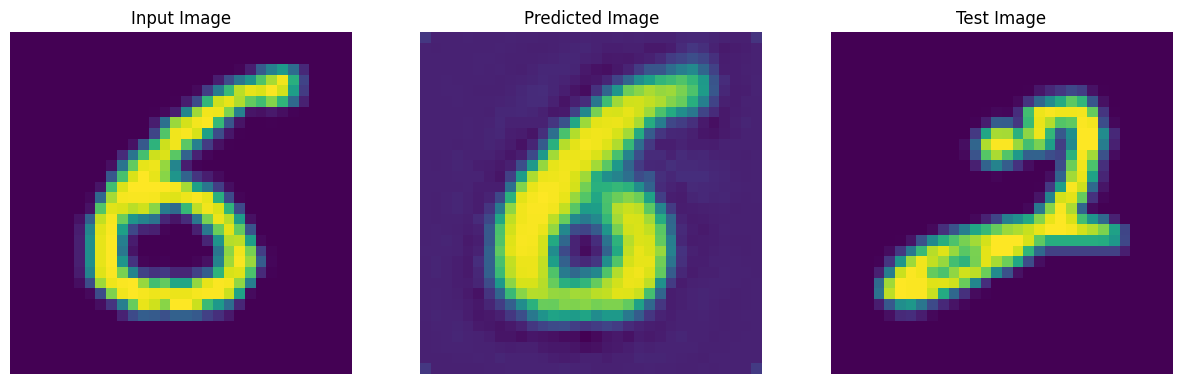

tf.Tensor(2.8754025, shape=(), dtype=float32)
tf.Tensor(2.9442046, shape=(), dtype=float32)
tf.Tensor(2.8596947, shape=(), dtype=float32)
tf.Tensor(2.9945252, shape=(), dtype=float32)
tf.Tensor(2.8266745, shape=(), dtype=float32)
tf.Tensor(2.853601, shape=(), dtype=float32)
tf.Tensor(2.8948889, shape=(), dtype=float32)
tf.Tensor(2.9243906, shape=(), dtype=float32)
tf.Tensor(2.8790004, shape=(), dtype=float32)
tf.Tensor(2.932015, shape=(), dtype=float32)
tf.Tensor(2.9964123, shape=(), dtype=float32)
tf.Tensor(2.9792445, shape=(), dtype=float32)
tf.Tensor(2.870305, shape=(), dtype=float32)
tf.Tensor(2.8165712, shape=(), dtype=float32)
tf.Tensor(2.8875384, shape=(), dtype=float32)
tf.Tensor(2.8525305, shape=(), dtype=float32)
tf.Tensor(2.8305578, shape=(), dtype=float32)
tf.Tensor(2.8903677, shape=(), dtype=float32)
tf.Tensor(2.809132, shape=(), dtype=float32)
tf.Tensor(2.957366, shape=(), dtype=float32)
tf.Tensor(2.8967257, shape=(), dtype=float32)
tf.Tensor(2.942718, shape=(), dtype=flo

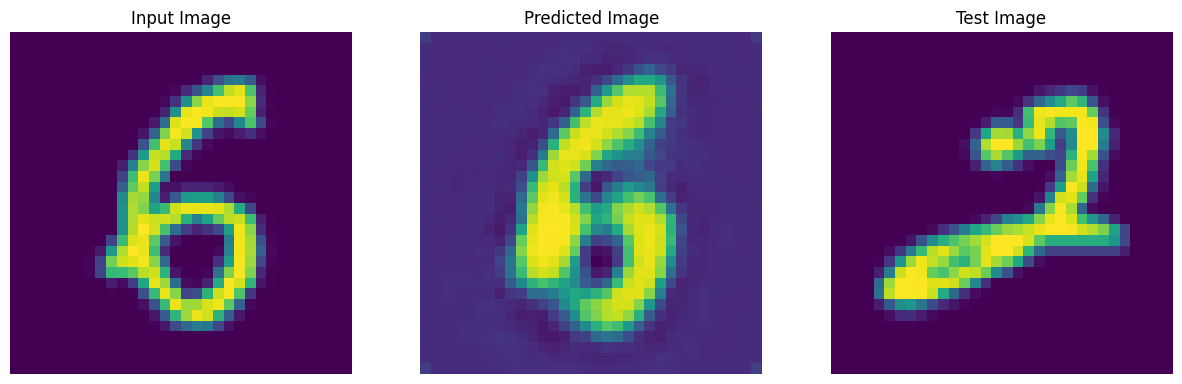

tf.Tensor(2.766927, shape=(), dtype=float32)
tf.Tensor(2.728882, shape=(), dtype=float32)
tf.Tensor(2.7704437, shape=(), dtype=float32)
tf.Tensor(2.7623498, shape=(), dtype=float32)
tf.Tensor(2.7671883, shape=(), dtype=float32)
tf.Tensor(2.8019369, shape=(), dtype=float32)
tf.Tensor(2.6526, shape=(), dtype=float32)
tf.Tensor(2.655346, shape=(), dtype=float32)
tf.Tensor(2.7467802, shape=(), dtype=float32)
tf.Tensor(2.806399, shape=(), dtype=float32)
tf.Tensor(2.6514244, shape=(), dtype=float32)
tf.Tensor(2.7008622, shape=(), dtype=float32)
tf.Tensor(2.7492266, shape=(), dtype=float32)
tf.Tensor(2.8022327, shape=(), dtype=float32)
tf.Tensor(2.7272224, shape=(), dtype=float32)
tf.Tensor(2.760218, shape=(), dtype=float32)
tf.Tensor(2.634592, shape=(), dtype=float32)
tf.Tensor(2.713661, shape=(), dtype=float32)
tf.Tensor(2.8314881, shape=(), dtype=float32)
tf.Tensor(2.749542, shape=(), dtype=float32)
tf.Tensor(2.788702, shape=(), dtype=float32)
tf.Tensor(2.632558, shape=(), dtype=float32)
t

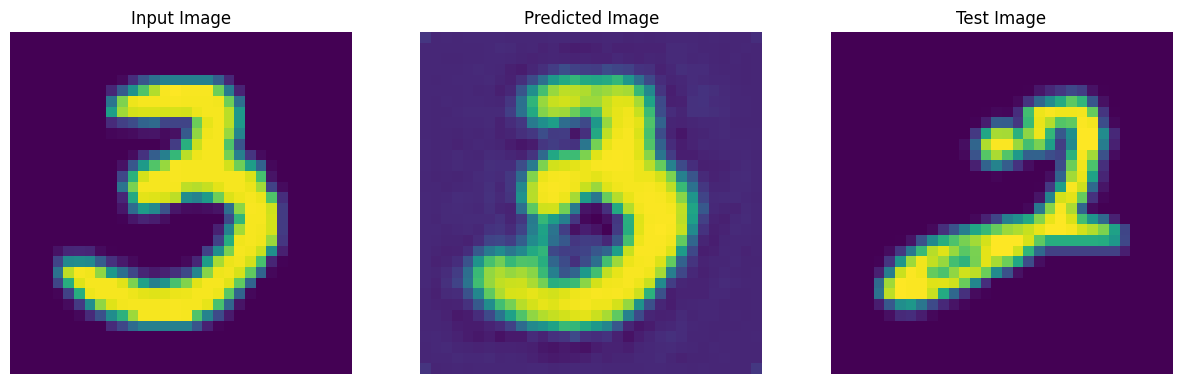

tf.Tensor(2.6028402, shape=(), dtype=float32)
tf.Tensor(2.5589163, shape=(), dtype=float32)
tf.Tensor(2.6252546, shape=(), dtype=float32)
tf.Tensor(2.601546, shape=(), dtype=float32)
tf.Tensor(2.605071, shape=(), dtype=float32)
tf.Tensor(2.573709, shape=(), dtype=float32)
tf.Tensor(2.5781302, shape=(), dtype=float32)
tf.Tensor(2.5425725, shape=(), dtype=float32)
tf.Tensor(2.6989105, shape=(), dtype=float32)
tf.Tensor(2.622879, shape=(), dtype=float32)
tf.Tensor(2.5329115, shape=(), dtype=float32)
tf.Tensor(2.6178522, shape=(), dtype=float32)
tf.Tensor(2.623247, shape=(), dtype=float32)
tf.Tensor(2.660246, shape=(), dtype=float32)
tf.Tensor(2.5941772, shape=(), dtype=float32)
tf.Tensor(2.5703447, shape=(), dtype=float32)
tf.Tensor(2.602964, shape=(), dtype=float32)
tf.Tensor(2.6671245, shape=(), dtype=float32)
tf.Tensor(2.6999424, shape=(), dtype=float32)
tf.Tensor(2.6933155, shape=(), dtype=float32)
tf.Tensor(2.7843766, shape=(), dtype=float32)
tf.Tensor(2.572653, shape=(), dtype=float

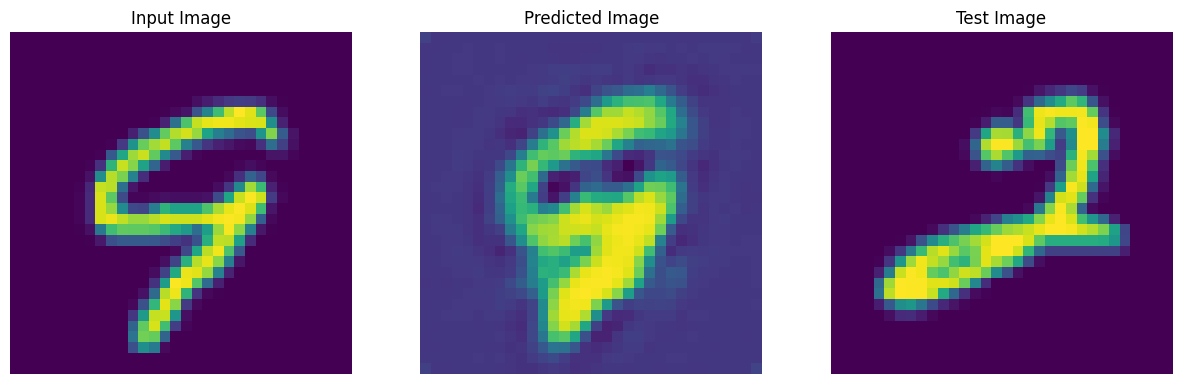

tf.Tensor(2.4563332, shape=(), dtype=float32)
tf.Tensor(2.4442954, shape=(), dtype=float32)
tf.Tensor(2.4414096, shape=(), dtype=float32)
tf.Tensor(2.5610366, shape=(), dtype=float32)
tf.Tensor(2.4017081, shape=(), dtype=float32)
tf.Tensor(2.456775, shape=(), dtype=float32)
tf.Tensor(2.654263, shape=(), dtype=float32)
tf.Tensor(2.4135907, shape=(), dtype=float32)
tf.Tensor(2.4248245, shape=(), dtype=float32)
tf.Tensor(2.5205195, shape=(), dtype=float32)
tf.Tensor(2.5480309, shape=(), dtype=float32)
tf.Tensor(2.5065773, shape=(), dtype=float32)
tf.Tensor(2.528587, shape=(), dtype=float32)
tf.Tensor(2.4503016, shape=(), dtype=float32)
tf.Tensor(2.5611851, shape=(), dtype=float32)
tf.Tensor(2.4485652, shape=(), dtype=float32)
tf.Tensor(2.4635782, shape=(), dtype=float32)
tf.Tensor(2.4821424, shape=(), dtype=float32)
tf.Tensor(2.436547, shape=(), dtype=float32)
tf.Tensor(2.4291768, shape=(), dtype=float32)
tf.Tensor(2.5304863, shape=(), dtype=float32)
tf.Tensor(2.4733894, shape=(), dtype=f

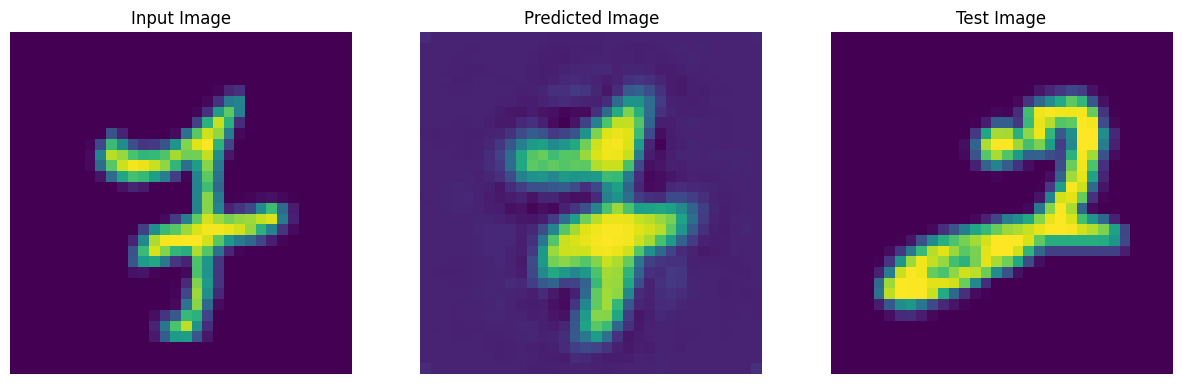

tf.Tensor(2.3643358, shape=(), dtype=float32)
tf.Tensor(2.4602532, shape=(), dtype=float32)
tf.Tensor(2.3761067, shape=(), dtype=float32)
tf.Tensor(2.4100451, shape=(), dtype=float32)
tf.Tensor(2.3700876, shape=(), dtype=float32)
tf.Tensor(2.4412515, shape=(), dtype=float32)
tf.Tensor(2.3373349, shape=(), dtype=float32)
tf.Tensor(2.4254427, shape=(), dtype=float32)
tf.Tensor(2.3201532, shape=(), dtype=float32)
tf.Tensor(2.3083982, shape=(), dtype=float32)
tf.Tensor(2.3665273, shape=(), dtype=float32)
tf.Tensor(2.361724, shape=(), dtype=float32)
tf.Tensor(2.352233, shape=(), dtype=float32)
tf.Tensor(2.3524876, shape=(), dtype=float32)
tf.Tensor(2.406618, shape=(), dtype=float32)
tf.Tensor(2.4339104, shape=(), dtype=float32)
tf.Tensor(2.323055, shape=(), dtype=float32)
tf.Tensor(2.3369792, shape=(), dtype=float32)
tf.Tensor(2.3918726, shape=(), dtype=float32)
tf.Tensor(2.3558981, shape=(), dtype=float32)
tf.Tensor(2.324267, shape=(), dtype=float32)
tf.Tensor(2.2781274, shape=(), dtype=fl

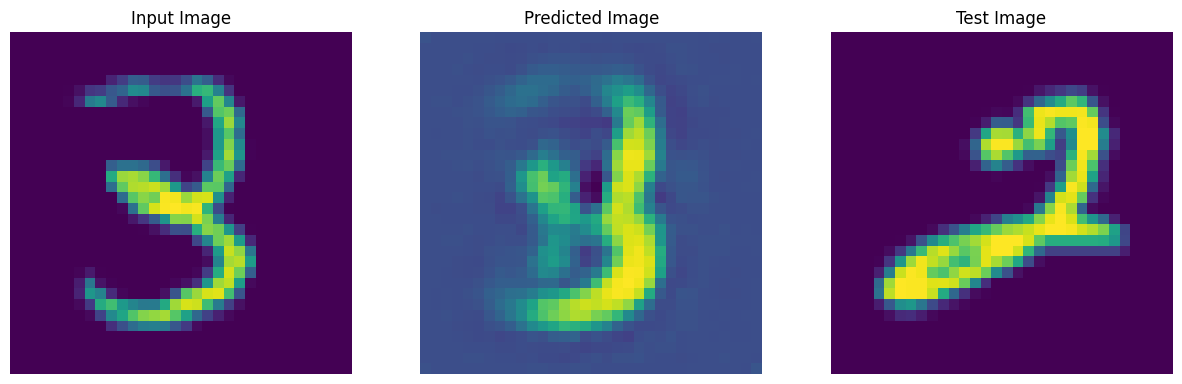

tf.Tensor(2.3122723, shape=(), dtype=float32)
tf.Tensor(2.283784, shape=(), dtype=float32)
tf.Tensor(2.2885866, shape=(), dtype=float32)
tf.Tensor(2.2980735, shape=(), dtype=float32)
tf.Tensor(2.3078067, shape=(), dtype=float32)
tf.Tensor(2.2581758, shape=(), dtype=float32)
tf.Tensor(2.278043, shape=(), dtype=float32)
tf.Tensor(2.2695136, shape=(), dtype=float32)
tf.Tensor(2.2745605, shape=(), dtype=float32)
tf.Tensor(2.2902431, shape=(), dtype=float32)
tf.Tensor(2.2626562, shape=(), dtype=float32)
tf.Tensor(2.2012508, shape=(), dtype=float32)
tf.Tensor(2.2706766, shape=(), dtype=float32)
tf.Tensor(2.2067509, shape=(), dtype=float32)
tf.Tensor(2.212983, shape=(), dtype=float32)
tf.Tensor(2.2575068, shape=(), dtype=float32)
tf.Tensor(2.2868354, shape=(), dtype=float32)
tf.Tensor(2.2621431, shape=(), dtype=float32)
tf.Tensor(2.2913656, shape=(), dtype=float32)
tf.Tensor(2.2770326, shape=(), dtype=float32)
tf.Tensor(2.2052457, shape=(), dtype=float32)
tf.Tensor(2.2740126, shape=(), dtype=

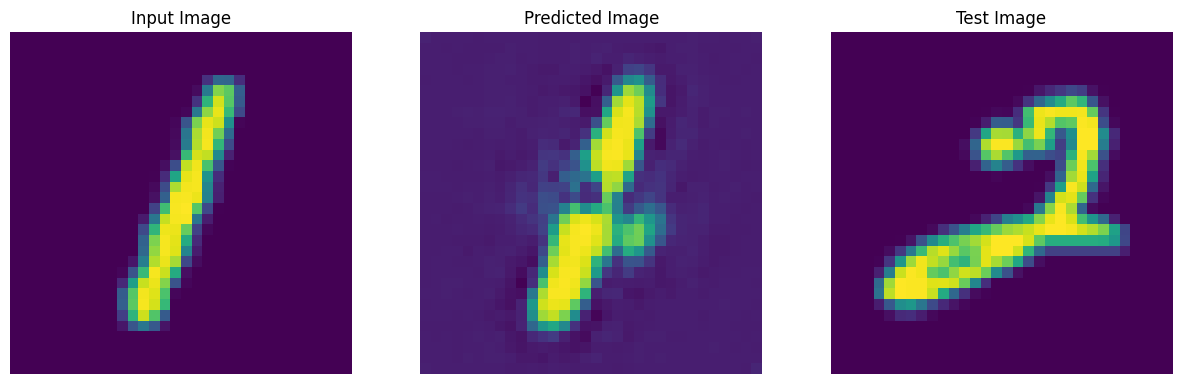

tf.Tensor(2.123142, shape=(), dtype=float32)
tf.Tensor(2.1193404, shape=(), dtype=float32)
tf.Tensor(2.1230073, shape=(), dtype=float32)
tf.Tensor(2.1868165, shape=(), dtype=float32)
tf.Tensor(2.1847034, shape=(), dtype=float32)
tf.Tensor(2.1558475, shape=(), dtype=float32)
tf.Tensor(2.2192035, shape=(), dtype=float32)
tf.Tensor(2.1880646, shape=(), dtype=float32)
tf.Tensor(2.155467, shape=(), dtype=float32)
tf.Tensor(2.1450171, shape=(), dtype=float32)
tf.Tensor(2.1870227, shape=(), dtype=float32)
tf.Tensor(2.103558, shape=(), dtype=float32)
tf.Tensor(2.1683018, shape=(), dtype=float32)
tf.Tensor(2.2216935, shape=(), dtype=float32)
tf.Tensor(2.155364, shape=(), dtype=float32)
tf.Tensor(2.1319473, shape=(), dtype=float32)
tf.Tensor(2.1436357, shape=(), dtype=float32)
tf.Tensor(2.1252892, shape=(), dtype=float32)
tf.Tensor(2.186526, shape=(), dtype=float32)
tf.Tensor(2.208609, shape=(), dtype=float32)
tf.Tensor(2.2005517, shape=(), dtype=float32)
tf.Tensor(2.1805782, shape=(), dtype=flo

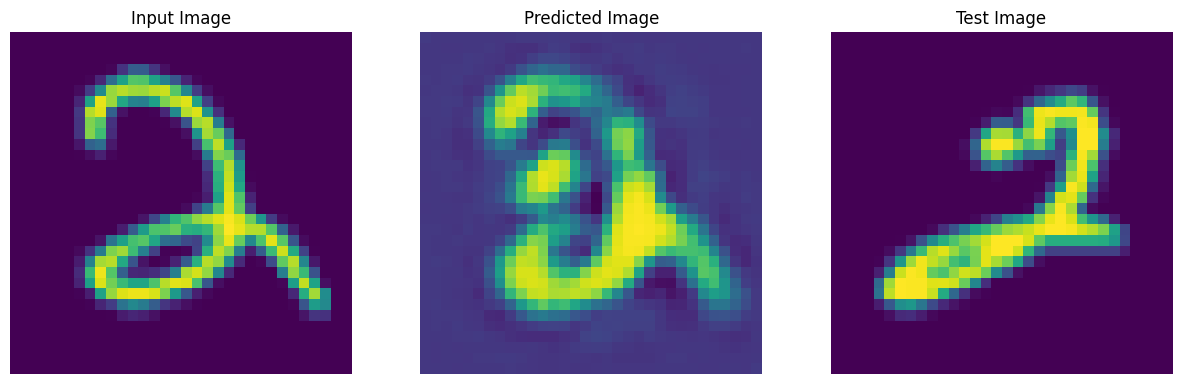

tf.Tensor(2.0852354, shape=(), dtype=float32)
tf.Tensor(1.997796, shape=(), dtype=float32)
tf.Tensor(1.9864984, shape=(), dtype=float32)
tf.Tensor(2.0597792, shape=(), dtype=float32)
tf.Tensor(1.9954755, shape=(), dtype=float32)
tf.Tensor(2.0103698, shape=(), dtype=float32)
tf.Tensor(2.0311697, shape=(), dtype=float32)
tf.Tensor(1.9418577, shape=(), dtype=float32)
tf.Tensor(2.0488105, shape=(), dtype=float32)
tf.Tensor(2.0134459, shape=(), dtype=float32)
tf.Tensor(2.0330656, shape=(), dtype=float32)
tf.Tensor(2.002564, shape=(), dtype=float32)
tf.Tensor(2.0651646, shape=(), dtype=float32)
tf.Tensor(2.054022, shape=(), dtype=float32)
tf.Tensor(1.9883701, shape=(), dtype=float32)
tf.Tensor(2.0435426, shape=(), dtype=float32)
tf.Tensor(2.022535, shape=(), dtype=float32)
tf.Tensor(2.0228488, shape=(), dtype=float32)
tf.Tensor(2.038467, shape=(), dtype=float32)
tf.Tensor(2.0295355, shape=(), dtype=float32)
tf.Tensor(2.0962317, shape=(), dtype=float32)
tf.Tensor(2.0328484, shape=(), dtype=fl

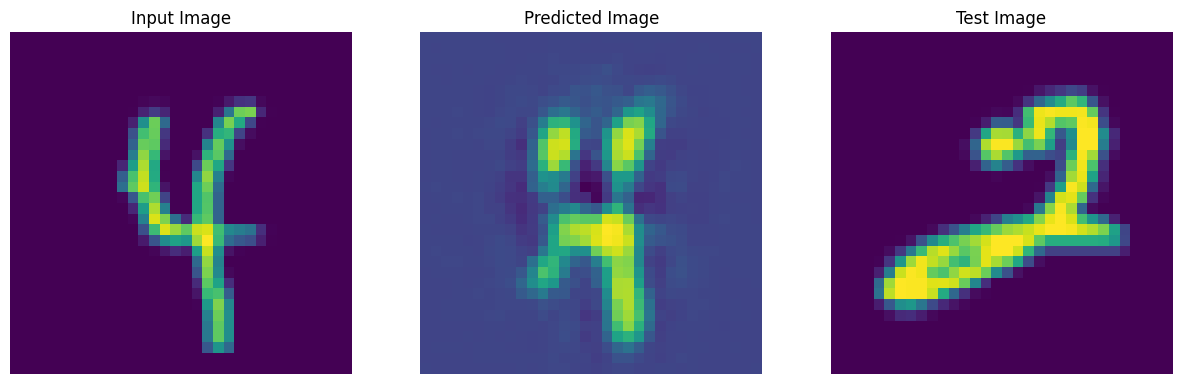

tf.Tensor(1.9819486, shape=(), dtype=float32)
tf.Tensor(1.969142, shape=(), dtype=float32)
tf.Tensor(2.0248795, shape=(), dtype=float32)
tf.Tensor(1.8688134, shape=(), dtype=float32)
tf.Tensor(1.9238242, shape=(), dtype=float32)
tf.Tensor(2.0196033, shape=(), dtype=float32)
tf.Tensor(1.9082687, shape=(), dtype=float32)
tf.Tensor(1.9283708, shape=(), dtype=float32)
tf.Tensor(1.9238799, shape=(), dtype=float32)
tf.Tensor(1.9740801, shape=(), dtype=float32)
tf.Tensor(1.9078047, shape=(), dtype=float32)
tf.Tensor(1.962183, shape=(), dtype=float32)
tf.Tensor(1.9027004, shape=(), dtype=float32)
tf.Tensor(1.9881642, shape=(), dtype=float32)
tf.Tensor(1.8817956, shape=(), dtype=float32)
tf.Tensor(1.8101, shape=(), dtype=float32)
tf.Tensor(1.9527845, shape=(), dtype=float32)
tf.Tensor(1.9108635, shape=(), dtype=float32)
tf.Tensor(1.9219754, shape=(), dtype=float32)
tf.Tensor(1.9267983, shape=(), dtype=float32)
tf.Tensor(1.9469345, shape=(), dtype=float32)
tf.Tensor(1.9158449, shape=(), dtype=fl

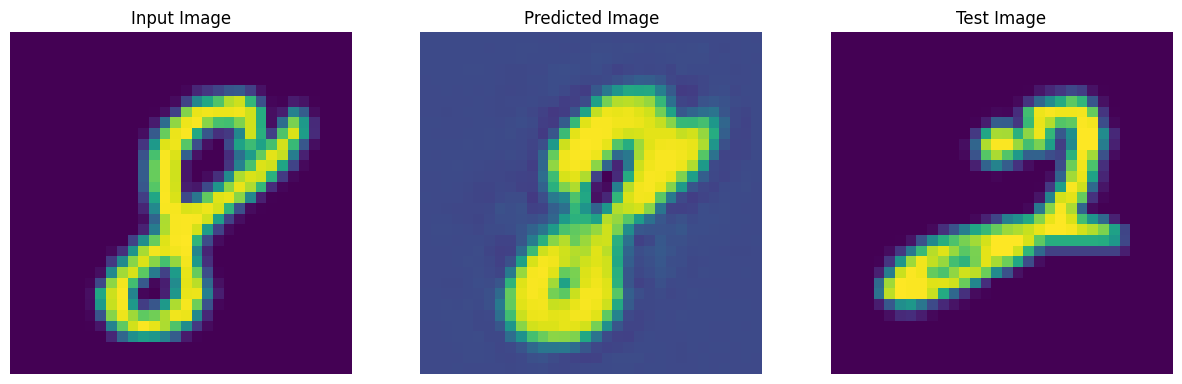

tf.Tensor(1.8698698, shape=(), dtype=float32)
tf.Tensor(1.8589852, shape=(), dtype=float32)
tf.Tensor(1.768337, shape=(), dtype=float32)
tf.Tensor(1.8082268, shape=(), dtype=float32)
tf.Tensor(1.8198938, shape=(), dtype=float32)
tf.Tensor(1.8760897, shape=(), dtype=float32)
tf.Tensor(1.8752347, shape=(), dtype=float32)
tf.Tensor(1.8708687, shape=(), dtype=float32)
tf.Tensor(1.8217552, shape=(), dtype=float32)
tf.Tensor(1.8583055, shape=(), dtype=float32)
tf.Tensor(1.8339646, shape=(), dtype=float32)
tf.Tensor(1.8897915, shape=(), dtype=float32)
tf.Tensor(1.8715987, shape=(), dtype=float32)
tf.Tensor(1.8339313, shape=(), dtype=float32)
tf.Tensor(1.9299905, shape=(), dtype=float32)
tf.Tensor(1.8241599, shape=(), dtype=float32)
tf.Tensor(1.8547645, shape=(), dtype=float32)
tf.Tensor(1.9226794, shape=(), dtype=float32)
tf.Tensor(1.8423755, shape=(), dtype=float32)
tf.Tensor(1.82151, shape=(), dtype=float32)
tf.Tensor(1.8641768, shape=(), dtype=float32)
tf.Tensor(1.8962808, shape=(), dtype=

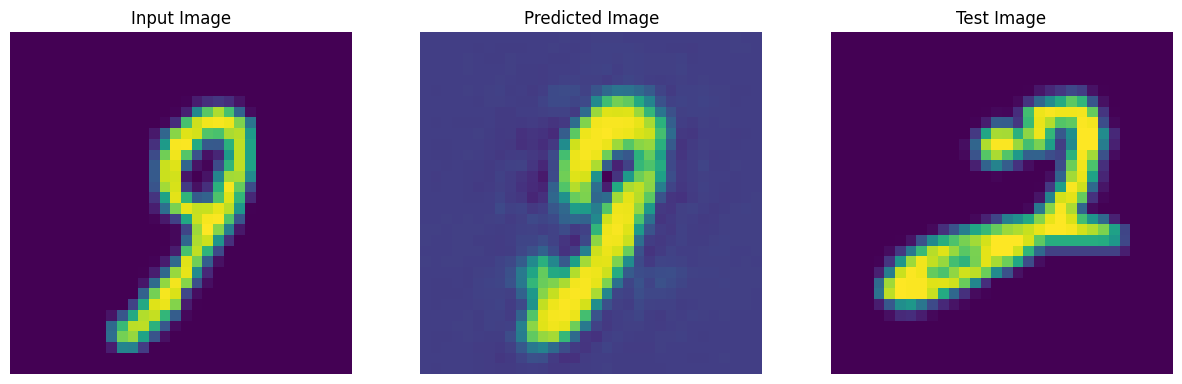

tf.Tensor(1.766264, shape=(), dtype=float32)
tf.Tensor(1.7807572, shape=(), dtype=float32)
tf.Tensor(1.8244152, shape=(), dtype=float32)
tf.Tensor(1.8351953, shape=(), dtype=float32)
tf.Tensor(1.7856712, shape=(), dtype=float32)
tf.Tensor(1.7918009, shape=(), dtype=float32)
tf.Tensor(1.811324, shape=(), dtype=float32)
tf.Tensor(1.7390842, shape=(), dtype=float32)
tf.Tensor(1.8095053, shape=(), dtype=float32)
tf.Tensor(1.7219816, shape=(), dtype=float32)
tf.Tensor(1.7911257, shape=(), dtype=float32)
tf.Tensor(1.7309128, shape=(), dtype=float32)
tf.Tensor(1.7412734, shape=(), dtype=float32)
tf.Tensor(1.815208, shape=(), dtype=float32)
tf.Tensor(1.7113132, shape=(), dtype=float32)
tf.Tensor(1.7079543, shape=(), dtype=float32)
tf.Tensor(1.802231, shape=(), dtype=float32)
tf.Tensor(1.766437, shape=(), dtype=float32)
tf.Tensor(1.7941921, shape=(), dtype=float32)
tf.Tensor(1.7389119, shape=(), dtype=float32)
tf.Tensor(1.7035722, shape=(), dtype=float32)
tf.Tensor(1.749581, shape=(), dtype=flo

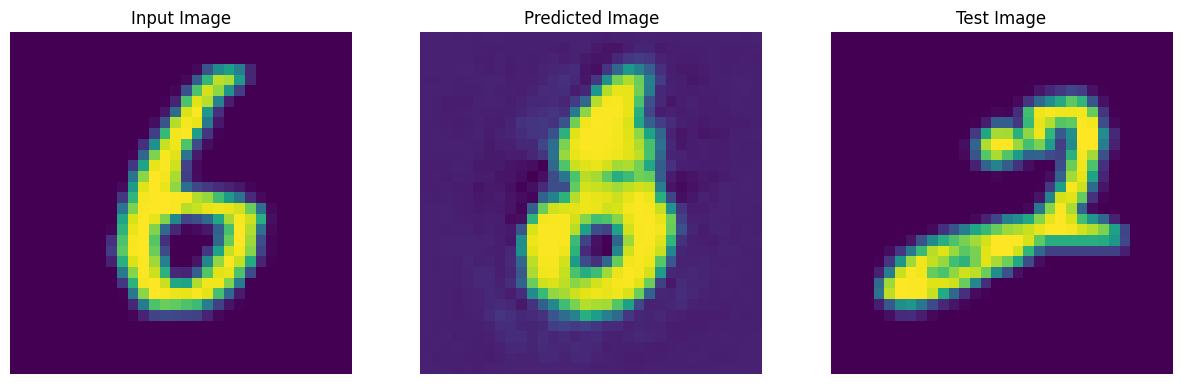

tf.Tensor(1.6622765, shape=(), dtype=float32)
tf.Tensor(1.5578009, shape=(), dtype=float32)
tf.Tensor(1.6446912, shape=(), dtype=float32)
tf.Tensor(1.7091515, shape=(), dtype=float32)
tf.Tensor(1.6342641, shape=(), dtype=float32)
tf.Tensor(1.5619498, shape=(), dtype=float32)
tf.Tensor(1.6870623, shape=(), dtype=float32)
tf.Tensor(1.6614826, shape=(), dtype=float32)
tf.Tensor(1.6650553, shape=(), dtype=float32)
tf.Tensor(1.6605743, shape=(), dtype=float32)
tf.Tensor(1.7177498, shape=(), dtype=float32)
tf.Tensor(1.6294845, shape=(), dtype=float32)
tf.Tensor(1.5872686, shape=(), dtype=float32)
tf.Tensor(1.6725981, shape=(), dtype=float32)
tf.Tensor(1.6676552, shape=(), dtype=float32)
tf.Tensor(1.691518, shape=(), dtype=float32)
tf.Tensor(1.5940738, shape=(), dtype=float32)
tf.Tensor(1.6691966, shape=(), dtype=float32)
tf.Tensor(1.6961362, shape=(), dtype=float32)
tf.Tensor(1.6197189, shape=(), dtype=float32)
tf.Tensor(1.6510057, shape=(), dtype=float32)
tf.Tensor(1.629723, shape=(), dtype

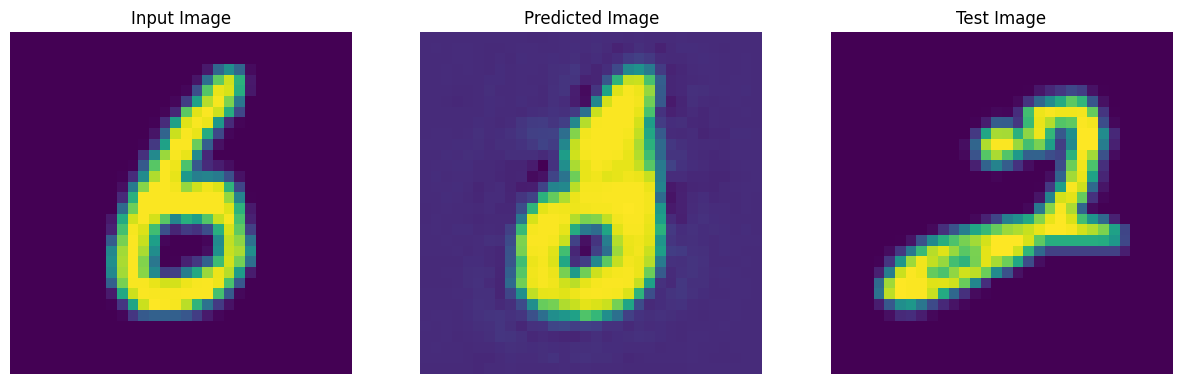

tf.Tensor(1.592428, shape=(), dtype=float32)
tf.Tensor(1.6194181, shape=(), dtype=float32)
tf.Tensor(1.665349, shape=(), dtype=float32)
tf.Tensor(1.5828466, shape=(), dtype=float32)
tf.Tensor(1.6050632, shape=(), dtype=float32)
tf.Tensor(1.6200069, shape=(), dtype=float32)
tf.Tensor(1.6261864, shape=(), dtype=float32)
tf.Tensor(1.5738878, shape=(), dtype=float32)
tf.Tensor(1.585613, shape=(), dtype=float32)
tf.Tensor(1.5558528, shape=(), dtype=float32)
tf.Tensor(1.565295, shape=(), dtype=float32)
tf.Tensor(1.5542567, shape=(), dtype=float32)
tf.Tensor(1.536361, shape=(), dtype=float32)
tf.Tensor(1.5950325, shape=(), dtype=float32)
tf.Tensor(1.5838295, shape=(), dtype=float32)
tf.Tensor(1.5890182, shape=(), dtype=float32)
tf.Tensor(1.5923494, shape=(), dtype=float32)
tf.Tensor(1.5457066, shape=(), dtype=float32)
tf.Tensor(1.5874634, shape=(), dtype=float32)
tf.Tensor(1.6215527, shape=(), dtype=float32)
tf.Tensor(1.6065807, shape=(), dtype=float32)
tf.Tensor(1.5714426, shape=(), dtype=fl

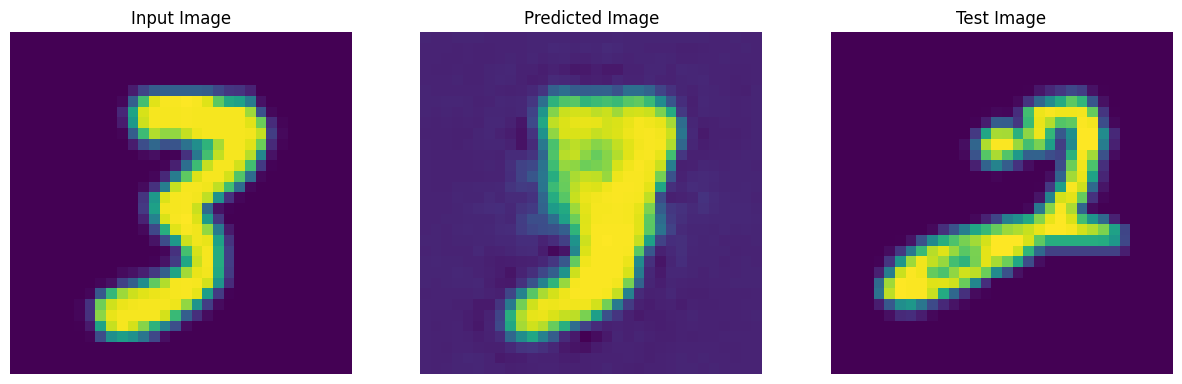

tf.Tensor(1.5572895, shape=(), dtype=float32)
tf.Tensor(1.5559566, shape=(), dtype=float32)
tf.Tensor(1.5559313, shape=(), dtype=float32)
tf.Tensor(1.604179, shape=(), dtype=float32)
tf.Tensor(1.5490004, shape=(), dtype=float32)
tf.Tensor(1.5456777, shape=(), dtype=float32)
tf.Tensor(1.5675921, shape=(), dtype=float32)
tf.Tensor(1.5534519, shape=(), dtype=float32)
tf.Tensor(1.5727216, shape=(), dtype=float32)
tf.Tensor(1.5797577, shape=(), dtype=float32)
tf.Tensor(1.5504068, shape=(), dtype=float32)
tf.Tensor(1.5600914, shape=(), dtype=float32)
tf.Tensor(1.5578456, shape=(), dtype=float32)
tf.Tensor(1.5630933, shape=(), dtype=float32)
tf.Tensor(1.4921924, shape=(), dtype=float32)
tf.Tensor(1.5298908, shape=(), dtype=float32)
tf.Tensor(1.5342745, shape=(), dtype=float32)
tf.Tensor(1.5567322, shape=(), dtype=float32)
tf.Tensor(1.5152036, shape=(), dtype=float32)
tf.Tensor(1.5603654, shape=(), dtype=float32)
tf.Tensor(1.5287489, shape=(), dtype=float32)
tf.Tensor(1.5451208, shape=(), dtyp

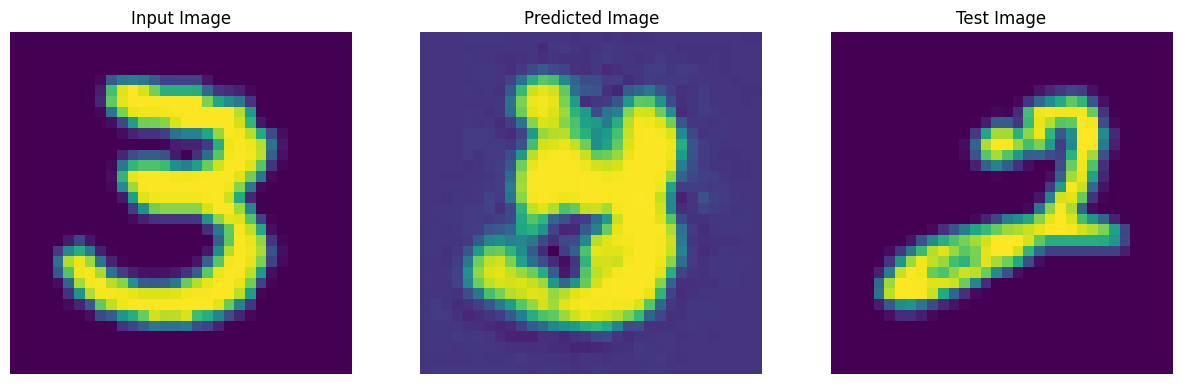

tf.Tensor(1.5066545, shape=(), dtype=float32)
tf.Tensor(1.5086385, shape=(), dtype=float32)
tf.Tensor(1.529415, shape=(), dtype=float32)
tf.Tensor(1.5184304, shape=(), dtype=float32)
tf.Tensor(1.4952416, shape=(), dtype=float32)
tf.Tensor(1.5434355, shape=(), dtype=float32)
tf.Tensor(1.5251547, shape=(), dtype=float32)
tf.Tensor(1.5133283, shape=(), dtype=float32)
tf.Tensor(1.5887597, shape=(), dtype=float32)
tf.Tensor(1.4890513, shape=(), dtype=float32)
tf.Tensor(1.4783247, shape=(), dtype=float32)
tf.Tensor(1.5229625, shape=(), dtype=float32)
tf.Tensor(1.4942524, shape=(), dtype=float32)
tf.Tensor(1.5372596, shape=(), dtype=float32)
tf.Tensor(1.4879204, shape=(), dtype=float32)
tf.Tensor(1.4717964, shape=(), dtype=float32)
tf.Tensor(1.5278361, shape=(), dtype=float32)
tf.Tensor(1.5206951, shape=(), dtype=float32)
tf.Tensor(1.5350436, shape=(), dtype=float32)
tf.Tensor(1.5039965, shape=(), dtype=float32)
tf.Tensor(1.5089743, shape=(), dtype=float32)
tf.Tensor(1.4983189, shape=(), dtyp

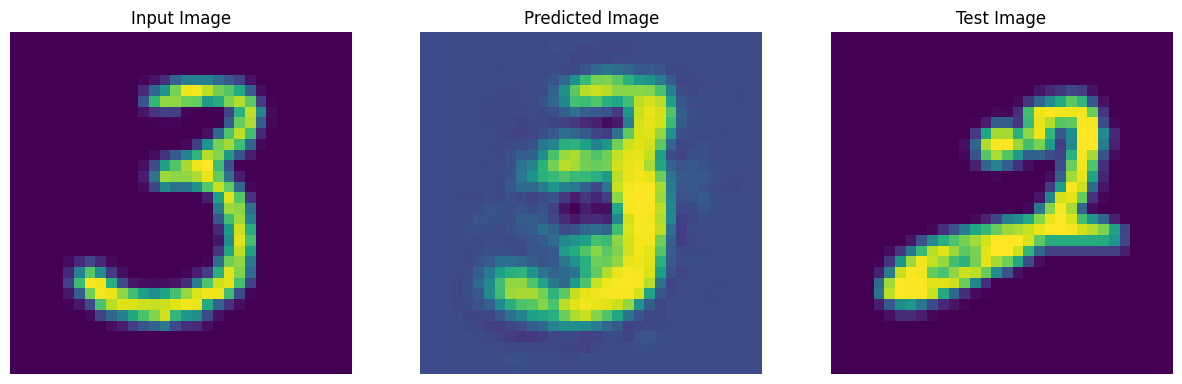

tf.Tensor(1.4704609, shape=(), dtype=float32)
tf.Tensor(1.4552821, shape=(), dtype=float32)
tf.Tensor(1.4404035, shape=(), dtype=float32)
tf.Tensor(1.431165, shape=(), dtype=float32)
tf.Tensor(1.3983223, shape=(), dtype=float32)
tf.Tensor(1.4906089, shape=(), dtype=float32)
tf.Tensor(1.4442269, shape=(), dtype=float32)
tf.Tensor(1.4397206, shape=(), dtype=float32)
tf.Tensor(1.4482933, shape=(), dtype=float32)
tf.Tensor(1.4895962, shape=(), dtype=float32)
tf.Tensor(1.4334056, shape=(), dtype=float32)
tf.Tensor(1.4457294, shape=(), dtype=float32)
tf.Tensor(1.4723446, shape=(), dtype=float32)
tf.Tensor(1.4129308, shape=(), dtype=float32)
tf.Tensor(1.3710096, shape=(), dtype=float32)
tf.Tensor(1.4086666, shape=(), dtype=float32)
tf.Tensor(1.4380778, shape=(), dtype=float32)
tf.Tensor(1.4040073, shape=(), dtype=float32)
tf.Tensor(1.4019072, shape=(), dtype=float32)
tf.Tensor(1.4138141, shape=(), dtype=float32)
tf.Tensor(1.4187212, shape=(), dtype=float32)
tf.Tensor(1.4447551, shape=(), dtyp

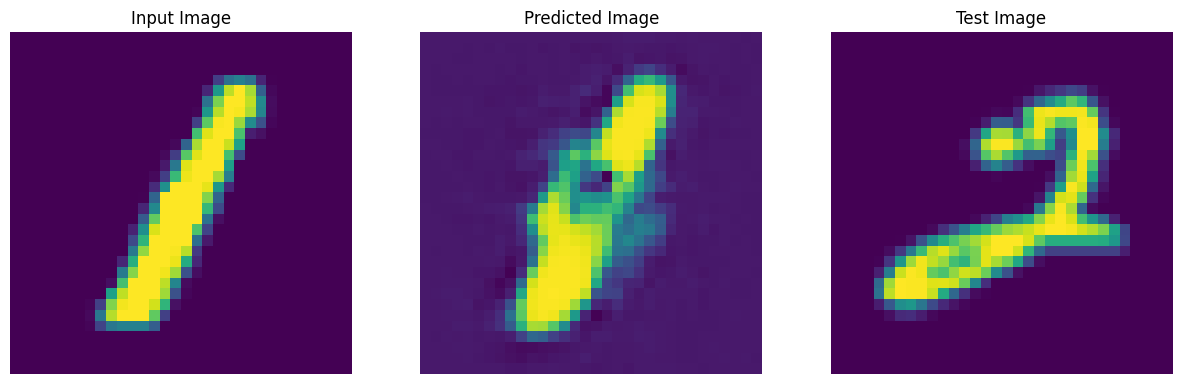

tf.Tensor(1.4616449, shape=(), dtype=float32)
tf.Tensor(1.3723601, shape=(), dtype=float32)
tf.Tensor(1.4477367, shape=(), dtype=float32)
tf.Tensor(1.375327, shape=(), dtype=float32)
tf.Tensor(1.3719044, shape=(), dtype=float32)
tf.Tensor(1.4337939, shape=(), dtype=float32)
tf.Tensor(1.3477764, shape=(), dtype=float32)
tf.Tensor(1.3771656, shape=(), dtype=float32)
tf.Tensor(1.4192173, shape=(), dtype=float32)
tf.Tensor(1.4093214, shape=(), dtype=float32)
tf.Tensor(1.3821317, shape=(), dtype=float32)
tf.Tensor(1.3997762, shape=(), dtype=float32)
tf.Tensor(1.3870047, shape=(), dtype=float32)
tf.Tensor(1.4186766, shape=(), dtype=float32)
tf.Tensor(1.3949937, shape=(), dtype=float32)
tf.Tensor(1.4431812, shape=(), dtype=float32)
tf.Tensor(1.376544, shape=(), dtype=float32)
tf.Tensor(1.4134252, shape=(), dtype=float32)
tf.Tensor(1.3711815, shape=(), dtype=float32)
tf.Tensor(1.3967354, shape=(), dtype=float32)
tf.Tensor(1.403165, shape=(), dtype=float32)
tf.Tensor(1.3934635, shape=(), dtype=

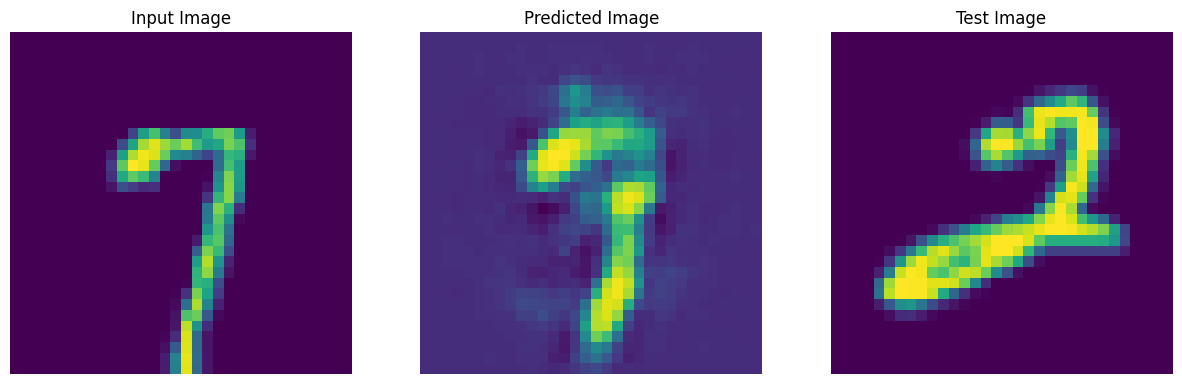

tf.Tensor(1.4233084, shape=(), dtype=float32)
tf.Tensor(1.3429369, shape=(), dtype=float32)
tf.Tensor(1.4076344, shape=(), dtype=float32)
tf.Tensor(1.346767, shape=(), dtype=float32)
tf.Tensor(1.3696773, shape=(), dtype=float32)
tf.Tensor(1.3601542, shape=(), dtype=float32)
tf.Tensor(1.3494875, shape=(), dtype=float32)
tf.Tensor(1.3809134, shape=(), dtype=float32)
tf.Tensor(1.3593932, shape=(), dtype=float32)
tf.Tensor(1.3982514, shape=(), dtype=float32)
tf.Tensor(1.3753608, shape=(), dtype=float32)
tf.Tensor(1.371628, shape=(), dtype=float32)
tf.Tensor(1.3706136, shape=(), dtype=float32)
tf.Tensor(1.3409191, shape=(), dtype=float32)
tf.Tensor(1.3719267, shape=(), dtype=float32)
tf.Tensor(1.2926074, shape=(), dtype=float32)
tf.Tensor(1.3008376, shape=(), dtype=float32)
tf.Tensor(1.3468276, shape=(), dtype=float32)
tf.Tensor(1.3246729, shape=(), dtype=float32)
tf.Tensor(1.390725, shape=(), dtype=float32)
tf.Tensor(1.4041911, shape=(), dtype=float32)
tf.Tensor(1.3373765, shape=(), dtype=

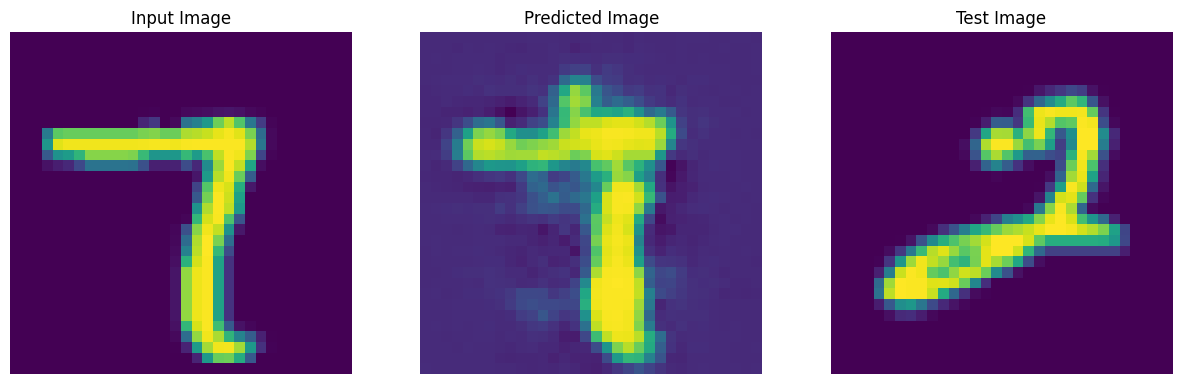

tf.Tensor(1.3562804, shape=(), dtype=float32)
tf.Tensor(1.3219756, shape=(), dtype=float32)
tf.Tensor(1.3946912, shape=(), dtype=float32)
tf.Tensor(1.3834996, shape=(), dtype=float32)
tf.Tensor(1.346599, shape=(), dtype=float32)
tf.Tensor(1.3577764, shape=(), dtype=float32)
tf.Tensor(1.3322135, shape=(), dtype=float32)
tf.Tensor(1.3571272, shape=(), dtype=float32)
tf.Tensor(1.2813727, shape=(), dtype=float32)
tf.Tensor(1.3377926, shape=(), dtype=float32)
tf.Tensor(1.3313013, shape=(), dtype=float32)
tf.Tensor(1.3319975, shape=(), dtype=float32)
tf.Tensor(1.3634654, shape=(), dtype=float32)
tf.Tensor(1.3730052, shape=(), dtype=float32)
tf.Tensor(1.3708235, shape=(), dtype=float32)
tf.Tensor(1.3580084, shape=(), dtype=float32)
tf.Tensor(1.382199, shape=(), dtype=float32)
tf.Tensor(1.3571153, shape=(), dtype=float32)
tf.Tensor(1.4060946, shape=(), dtype=float32)
tf.Tensor(1.3647624, shape=(), dtype=float32)
tf.Tensor(1.3858888, shape=(), dtype=float32)
tf.Tensor(1.3525178, shape=(), dtype

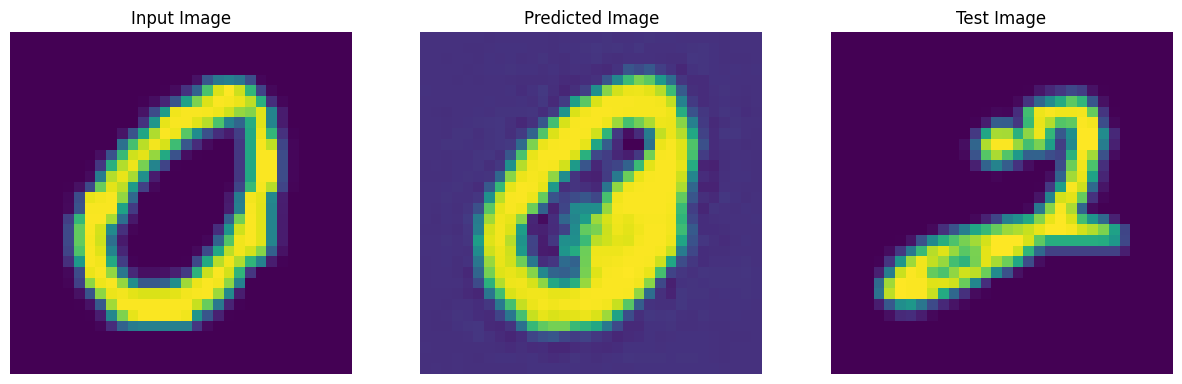

tf.Tensor(1.296166, shape=(), dtype=float32)
tf.Tensor(1.2882981, shape=(), dtype=float32)
tf.Tensor(1.3240222, shape=(), dtype=float32)
tf.Tensor(1.2432977, shape=(), dtype=float32)
tf.Tensor(1.2363136, shape=(), dtype=float32)
tf.Tensor(1.3059036, shape=(), dtype=float32)
tf.Tensor(1.2946855, shape=(), dtype=float32)
tf.Tensor(1.2777859, shape=(), dtype=float32)
tf.Tensor(1.2846279, shape=(), dtype=float32)
tf.Tensor(1.2582523, shape=(), dtype=float32)
tf.Tensor(1.2464616, shape=(), dtype=float32)
tf.Tensor(1.3075308, shape=(), dtype=float32)
tf.Tensor(1.3059716, shape=(), dtype=float32)
tf.Tensor(1.311709, shape=(), dtype=float32)
tf.Tensor(1.2727603, shape=(), dtype=float32)
tf.Tensor(1.3016111, shape=(), dtype=float32)
tf.Tensor(1.2791662, shape=(), dtype=float32)
tf.Tensor(1.249594, shape=(), dtype=float32)
tf.Tensor(1.2243737, shape=(), dtype=float32)
tf.Tensor(1.254613, shape=(), dtype=float32)
tf.Tensor(1.2578859, shape=(), dtype=float32)
tf.Tensor(1.2833948, shape=(), dtype=f

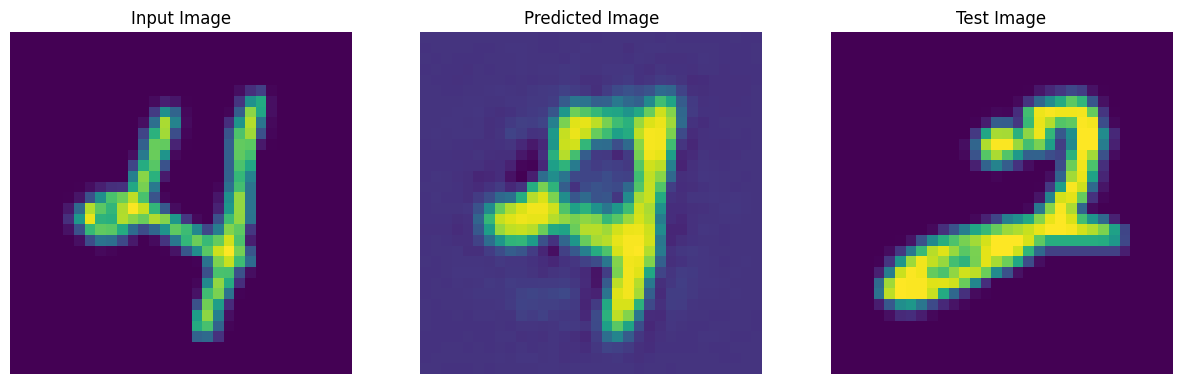

tf.Tensor(1.2322446, shape=(), dtype=float32)
tf.Tensor(1.2753919, shape=(), dtype=float32)
tf.Tensor(1.2457885, shape=(), dtype=float32)
tf.Tensor(1.2256393, shape=(), dtype=float32)
tf.Tensor(1.2776852, shape=(), dtype=float32)
tf.Tensor(1.2141824, shape=(), dtype=float32)
tf.Tensor(1.2670474, shape=(), dtype=float32)
tf.Tensor(1.2390484, shape=(), dtype=float32)
tf.Tensor(1.2641414, shape=(), dtype=float32)
tf.Tensor(1.1989502, shape=(), dtype=float32)
tf.Tensor(1.2264756, shape=(), dtype=float32)
tf.Tensor(1.23503, shape=(), dtype=float32)
tf.Tensor(1.2107365, shape=(), dtype=float32)
tf.Tensor(1.2391222, shape=(), dtype=float32)
tf.Tensor(1.2511083, shape=(), dtype=float32)
tf.Tensor(1.2296896, shape=(), dtype=float32)
tf.Tensor(1.2451425, shape=(), dtype=float32)
tf.Tensor(1.209435, shape=(), dtype=float32)
tf.Tensor(1.2519007, shape=(), dtype=float32)
tf.Tensor(1.2633073, shape=(), dtype=float32)
tf.Tensor(1.2377479, shape=(), dtype=float32)
tf.Tensor(1.2346634, shape=(), dtype=

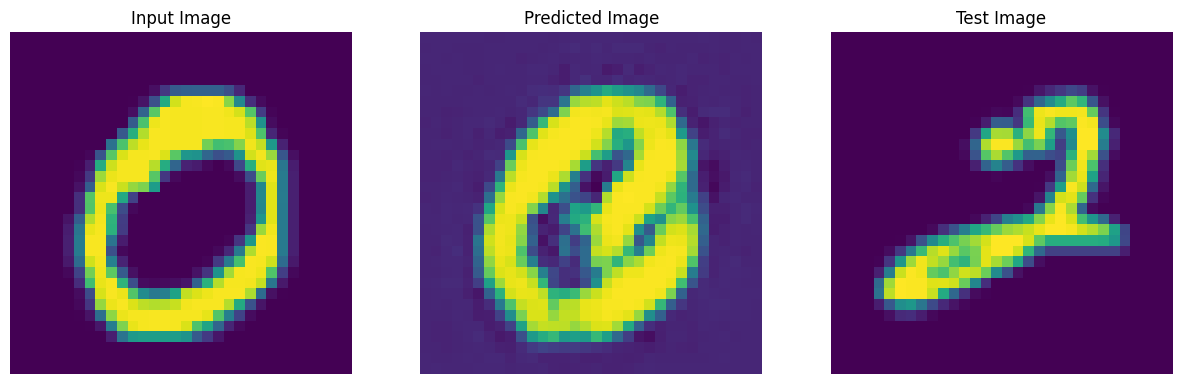

tf.Tensor(1.1920133, shape=(), dtype=float32)
tf.Tensor(1.1845958, shape=(), dtype=float32)
tf.Tensor(1.2133601, shape=(), dtype=float32)
tf.Tensor(1.1932306, shape=(), dtype=float32)
tf.Tensor(1.1870407, shape=(), dtype=float32)
tf.Tensor(1.1820483, shape=(), dtype=float32)
tf.Tensor(1.1780299, shape=(), dtype=float32)
tf.Tensor(1.2354724, shape=(), dtype=float32)
tf.Tensor(1.2067108, shape=(), dtype=float32)
tf.Tensor(1.1610937, shape=(), dtype=float32)
tf.Tensor(1.2067429, shape=(), dtype=float32)
tf.Tensor(1.2155403, shape=(), dtype=float32)
tf.Tensor(1.1847782, shape=(), dtype=float32)
tf.Tensor(1.1799909, shape=(), dtype=float32)
tf.Tensor(1.2050359, shape=(), dtype=float32)
tf.Tensor(1.1886508, shape=(), dtype=float32)
tf.Tensor(1.1979988, shape=(), dtype=float32)
tf.Tensor(1.2058555, shape=(), dtype=float32)
tf.Tensor(1.2203801, shape=(), dtype=float32)
tf.Tensor(1.1872456, shape=(), dtype=float32)
tf.Tensor(1.1831685, shape=(), dtype=float32)
tf.Tensor(1.2114358, shape=(), dty

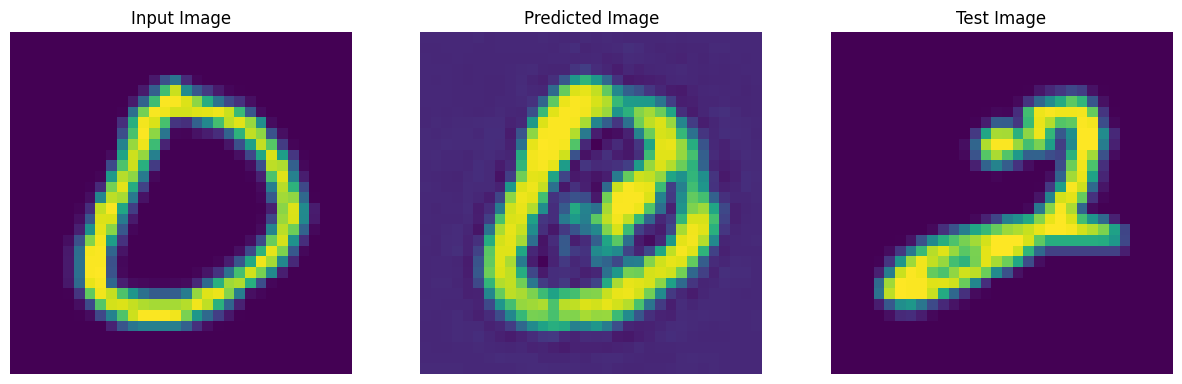

tf.Tensor(1.2081712, shape=(), dtype=float32)
tf.Tensor(1.2083412, shape=(), dtype=float32)
tf.Tensor(1.2119467, shape=(), dtype=float32)
tf.Tensor(1.2038019, shape=(), dtype=float32)
tf.Tensor(1.185032, shape=(), dtype=float32)
tf.Tensor(1.2222271, shape=(), dtype=float32)
tf.Tensor(1.2017579, shape=(), dtype=float32)
tf.Tensor(1.1924281, shape=(), dtype=float32)
tf.Tensor(1.1565417, shape=(), dtype=float32)
tf.Tensor(1.1260352, shape=(), dtype=float32)
tf.Tensor(1.1990699, shape=(), dtype=float32)
tf.Tensor(1.1485999, shape=(), dtype=float32)
tf.Tensor(1.2032146, shape=(), dtype=float32)
tf.Tensor(1.1631045, shape=(), dtype=float32)
tf.Tensor(1.1741579, shape=(), dtype=float32)
tf.Tensor(1.2026361, shape=(), dtype=float32)
tf.Tensor(1.2056332, shape=(), dtype=float32)
tf.Tensor(1.2402929, shape=(), dtype=float32)
tf.Tensor(1.2036362, shape=(), dtype=float32)
tf.Tensor(1.2341641, shape=(), dtype=float32)
tf.Tensor(1.2019868, shape=(), dtype=float32)
tf.Tensor(1.1974913, shape=(), dtyp

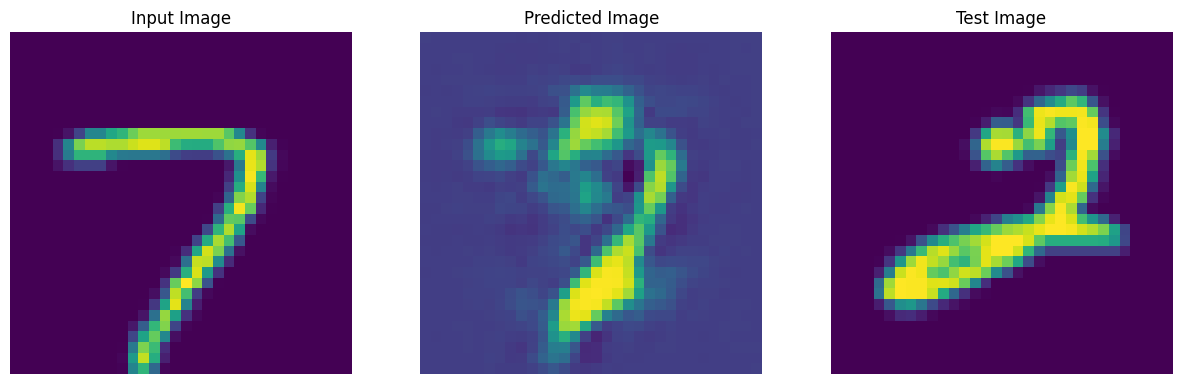

tf.Tensor(1.1359968, shape=(), dtype=float32)
tf.Tensor(1.1055338, shape=(), dtype=float32)
tf.Tensor(1.112951, shape=(), dtype=float32)
tf.Tensor(1.1500655, shape=(), dtype=float32)
tf.Tensor(1.0649285, shape=(), dtype=float32)
tf.Tensor(1.116385, shape=(), dtype=float32)
tf.Tensor(1.1015464, shape=(), dtype=float32)
tf.Tensor(1.0857427, shape=(), dtype=float32)
tf.Tensor(1.1400695, shape=(), dtype=float32)
tf.Tensor(1.1214342, shape=(), dtype=float32)
tf.Tensor(1.1194525, shape=(), dtype=float32)
tf.Tensor(1.1261448, shape=(), dtype=float32)
tf.Tensor(1.1199543, shape=(), dtype=float32)
tf.Tensor(1.1350702, shape=(), dtype=float32)
tf.Tensor(1.1183007, shape=(), dtype=float32)
tf.Tensor(1.1071798, shape=(), dtype=float32)
tf.Tensor(1.0977792, shape=(), dtype=float32)
tf.Tensor(1.1183598, shape=(), dtype=float32)
tf.Tensor(1.0965507, shape=(), dtype=float32)
tf.Tensor(1.1027277, shape=(), dtype=float32)
tf.Tensor(1.151612, shape=(), dtype=float32)
tf.Tensor(1.1117644, shape=(), dtype=

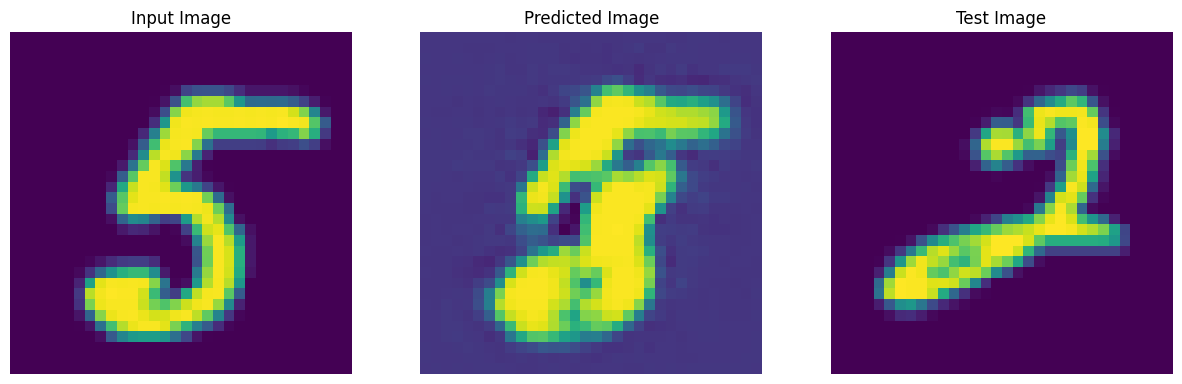

tf.Tensor(1.0951775, shape=(), dtype=float32)
tf.Tensor(1.125515, shape=(), dtype=float32)
tf.Tensor(1.0871811, shape=(), dtype=float32)
tf.Tensor(1.0661061, shape=(), dtype=float32)
tf.Tensor(1.1028198, shape=(), dtype=float32)
tf.Tensor(1.1131284, shape=(), dtype=float32)
tf.Tensor(1.0756401, shape=(), dtype=float32)
tf.Tensor(1.0600598, shape=(), dtype=float32)
tf.Tensor(1.0863096, shape=(), dtype=float32)
tf.Tensor(1.126921, shape=(), dtype=float32)
tf.Tensor(1.0743766, shape=(), dtype=float32)
tf.Tensor(1.1093085, shape=(), dtype=float32)
tf.Tensor(1.0999769, shape=(), dtype=float32)
tf.Tensor(1.1271989, shape=(), dtype=float32)
tf.Tensor(1.0540217, shape=(), dtype=float32)
tf.Tensor(1.0680667, shape=(), dtype=float32)
tf.Tensor(1.1370239, shape=(), dtype=float32)
tf.Tensor(1.1088948, shape=(), dtype=float32)
tf.Tensor(1.0499873, shape=(), dtype=float32)
tf.Tensor(1.0568287, shape=(), dtype=float32)
tf.Tensor(1.0750431, shape=(), dtype=float32)
tf.Tensor(1.0844054, shape=(), dtype

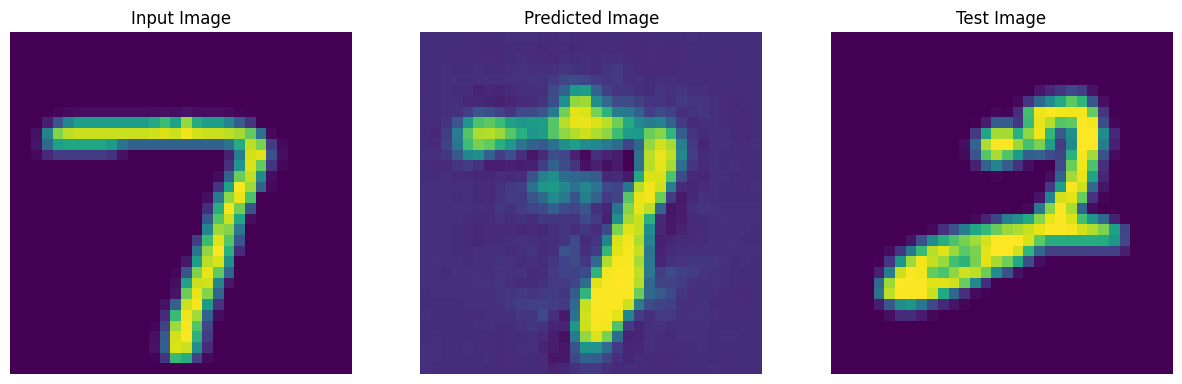

tf.Tensor(1.067689, shape=(), dtype=float32)
tf.Tensor(1.0745898, shape=(), dtype=float32)
tf.Tensor(1.0545517, shape=(), dtype=float32)
tf.Tensor(1.1259809, shape=(), dtype=float32)
tf.Tensor(1.051271, shape=(), dtype=float32)
tf.Tensor(1.0701145, shape=(), dtype=float32)
tf.Tensor(1.0895245, shape=(), dtype=float32)
tf.Tensor(1.0946544, shape=(), dtype=float32)
tf.Tensor(1.1025337, shape=(), dtype=float32)
tf.Tensor(1.1049132, shape=(), dtype=float32)
tf.Tensor(1.0803875, shape=(), dtype=float32)
tf.Tensor(1.0269597, shape=(), dtype=float32)
tf.Tensor(1.070639, shape=(), dtype=float32)
tf.Tensor(1.0652562, shape=(), dtype=float32)
tf.Tensor(1.0760593, shape=(), dtype=float32)
tf.Tensor(1.0898707, shape=(), dtype=float32)
tf.Tensor(1.0085181, shape=(), dtype=float32)
tf.Tensor(1.0620626, shape=(), dtype=float32)
tf.Tensor(1.0472175, shape=(), dtype=float32)
tf.Tensor(1.0433213, shape=(), dtype=float32)
tf.Tensor(1.0739727, shape=(), dtype=float32)
tf.Tensor(1.0665102, shape=(), dtype=

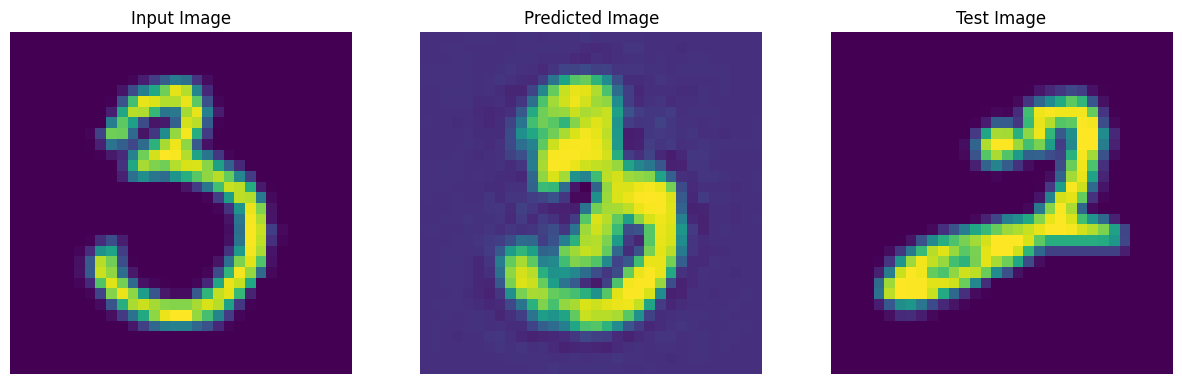

tf.Tensor(1.0956469, shape=(), dtype=float32)
tf.Tensor(1.0421804, shape=(), dtype=float32)
tf.Tensor(1.0840054, shape=(), dtype=float32)
tf.Tensor(1.0700345, shape=(), dtype=float32)
tf.Tensor(1.0627831, shape=(), dtype=float32)
tf.Tensor(1.0291702, shape=(), dtype=float32)
tf.Tensor(1.068667, shape=(), dtype=float32)
tf.Tensor(1.0353799, shape=(), dtype=float32)
tf.Tensor(1.0347213, shape=(), dtype=float32)
tf.Tensor(1.0270741, shape=(), dtype=float32)
tf.Tensor(1.0659895, shape=(), dtype=float32)
tf.Tensor(1.0531424, shape=(), dtype=float32)
tf.Tensor(1.0519011, shape=(), dtype=float32)
tf.Tensor(1.0602672, shape=(), dtype=float32)
tf.Tensor(1.0733718, shape=(), dtype=float32)
tf.Tensor(1.0936657, shape=(), dtype=float32)
tf.Tensor(1.065042, shape=(), dtype=float32)
tf.Tensor(1.0792025, shape=(), dtype=float32)
tf.Tensor(1.0994414, shape=(), dtype=float32)
tf.Tensor(1.0974257, shape=(), dtype=float32)
tf.Tensor(1.1226559, shape=(), dtype=float32)
tf.Tensor(1.089018, shape=(), dtype=

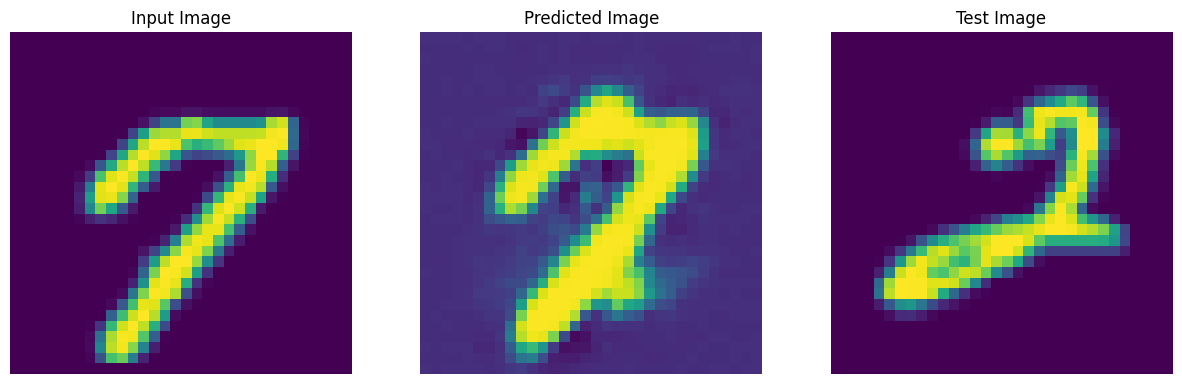

tf.Tensor(0.98012364, shape=(), dtype=float32)
tf.Tensor(0.9828666, shape=(), dtype=float32)
tf.Tensor(0.98192966, shape=(), dtype=float32)
tf.Tensor(0.9914548, shape=(), dtype=float32)
tf.Tensor(0.9880546, shape=(), dtype=float32)
tf.Tensor(0.97206223, shape=(), dtype=float32)
tf.Tensor(1.00842, shape=(), dtype=float32)
tf.Tensor(0.97232455, shape=(), dtype=float32)
tf.Tensor(0.98781526, shape=(), dtype=float32)
tf.Tensor(0.9457626, shape=(), dtype=float32)
tf.Tensor(0.95178884, shape=(), dtype=float32)
tf.Tensor(1.0267532, shape=(), dtype=float32)
tf.Tensor(0.97236013, shape=(), dtype=float32)
tf.Tensor(0.9829018, shape=(), dtype=float32)
tf.Tensor(0.9943632, shape=(), dtype=float32)
tf.Tensor(0.9821925, shape=(), dtype=float32)
tf.Tensor(1.0296837, shape=(), dtype=float32)
tf.Tensor(0.9926595, shape=(), dtype=float32)
tf.Tensor(0.95519626, shape=(), dtype=float32)
tf.Tensor(0.9746375, shape=(), dtype=float32)
tf.Tensor(0.96724457, shape=(), dtype=float32)
tf.Tensor(0.97621256, shape

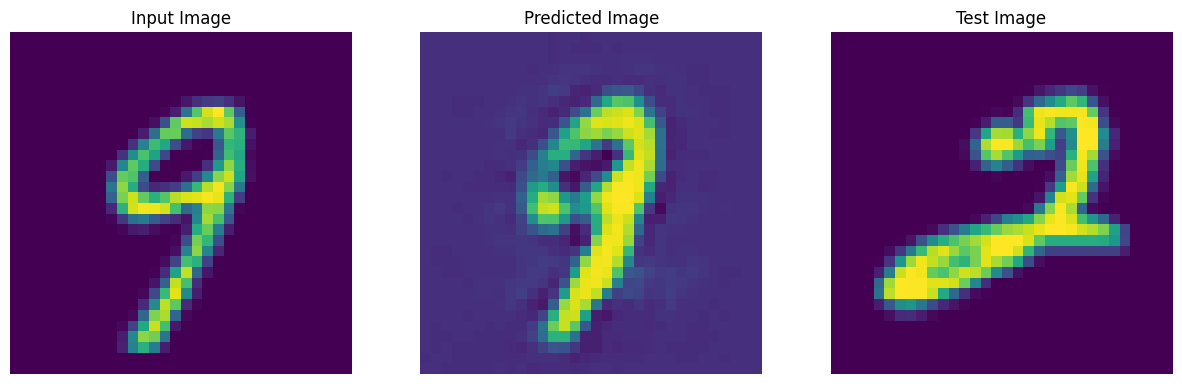

tf.Tensor(0.90817016, shape=(), dtype=float32)
tf.Tensor(0.9589093, shape=(), dtype=float32)
tf.Tensor(0.93563986, shape=(), dtype=float32)
tf.Tensor(0.9718747, shape=(), dtype=float32)
tf.Tensor(0.98265135, shape=(), dtype=float32)
tf.Tensor(0.9430654, shape=(), dtype=float32)
tf.Tensor(1.003684, shape=(), dtype=float32)
tf.Tensor(0.9315592, shape=(), dtype=float32)
tf.Tensor(0.9386868, shape=(), dtype=float32)
tf.Tensor(0.96601427, shape=(), dtype=float32)
tf.Tensor(0.9521488, shape=(), dtype=float32)
tf.Tensor(0.9709867, shape=(), dtype=float32)
tf.Tensor(0.9499054, shape=(), dtype=float32)
tf.Tensor(0.95192945, shape=(), dtype=float32)
tf.Tensor(0.9618833, shape=(), dtype=float32)
tf.Tensor(0.9513228, shape=(), dtype=float32)
tf.Tensor(0.9509144, shape=(), dtype=float32)
tf.Tensor(0.940657, shape=(), dtype=float32)
tf.Tensor(0.93542856, shape=(), dtype=float32)
tf.Tensor(0.98039615, shape=(), dtype=float32)
tf.Tensor(0.9165146, shape=(), dtype=float32)
tf.Tensor(0.96263814, shape=(

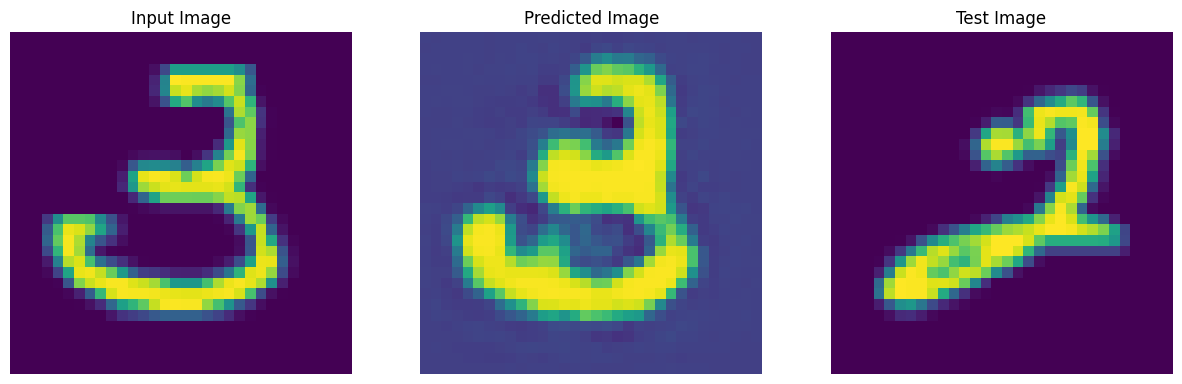

tf.Tensor(0.9753411, shape=(), dtype=float32)
tf.Tensor(0.9689251, shape=(), dtype=float32)
tf.Tensor(0.9470722, shape=(), dtype=float32)
tf.Tensor(0.9623166, shape=(), dtype=float32)
tf.Tensor(0.9513869, shape=(), dtype=float32)
tf.Tensor(0.9516556, shape=(), dtype=float32)
tf.Tensor(0.9852356, shape=(), dtype=float32)
tf.Tensor(0.9564152, shape=(), dtype=float32)
tf.Tensor(0.9132468, shape=(), dtype=float32)
tf.Tensor(0.9548397, shape=(), dtype=float32)
tf.Tensor(0.94231474, shape=(), dtype=float32)
tf.Tensor(0.97941667, shape=(), dtype=float32)
tf.Tensor(0.93302095, shape=(), dtype=float32)
tf.Tensor(0.925424, shape=(), dtype=float32)
tf.Tensor(0.955233, shape=(), dtype=float32)
tf.Tensor(0.94972, shape=(), dtype=float32)
tf.Tensor(0.9736498, shape=(), dtype=float32)
tf.Tensor(0.9668697, shape=(), dtype=float32)
tf.Tensor(0.9484921, shape=(), dtype=float32)
tf.Tensor(0.9401882, shape=(), dtype=float32)
tf.Tensor(0.9270925, shape=(), dtype=float32)
tf.Tensor(0.95242274, shape=(), dty

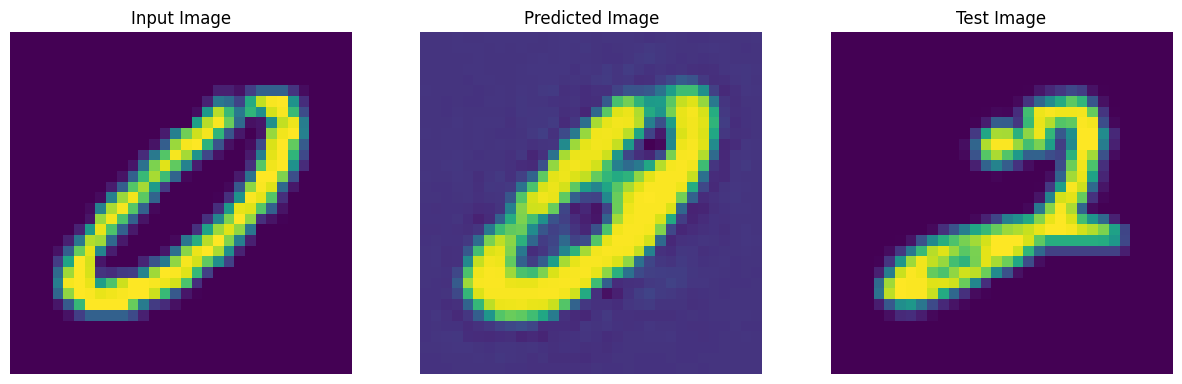

tf.Tensor(0.93659115, shape=(), dtype=float32)
tf.Tensor(0.9114331, shape=(), dtype=float32)
tf.Tensor(0.9637193, shape=(), dtype=float32)
tf.Tensor(0.9607074, shape=(), dtype=float32)
tf.Tensor(0.9307757, shape=(), dtype=float32)
tf.Tensor(0.9877444, shape=(), dtype=float32)
tf.Tensor(0.9552573, shape=(), dtype=float32)
tf.Tensor(0.9419729, shape=(), dtype=float32)
tf.Tensor(0.95491934, shape=(), dtype=float32)
tf.Tensor(0.98651516, shape=(), dtype=float32)
tf.Tensor(0.9435264, shape=(), dtype=float32)
tf.Tensor(0.93030155, shape=(), dtype=float32)
tf.Tensor(0.9326407, shape=(), dtype=float32)
tf.Tensor(0.94094557, shape=(), dtype=float32)
tf.Tensor(0.96587515, shape=(), dtype=float32)
tf.Tensor(0.9833739, shape=(), dtype=float32)
tf.Tensor(0.98967814, shape=(), dtype=float32)
tf.Tensor(0.9776358, shape=(), dtype=float32)
tf.Tensor(0.96259296, shape=(), dtype=float32)
tf.Tensor(0.963163, shape=(), dtype=float32)
tf.Tensor(0.9839574, shape=(), dtype=float32)
tf.Tensor(0.9573382, shape=

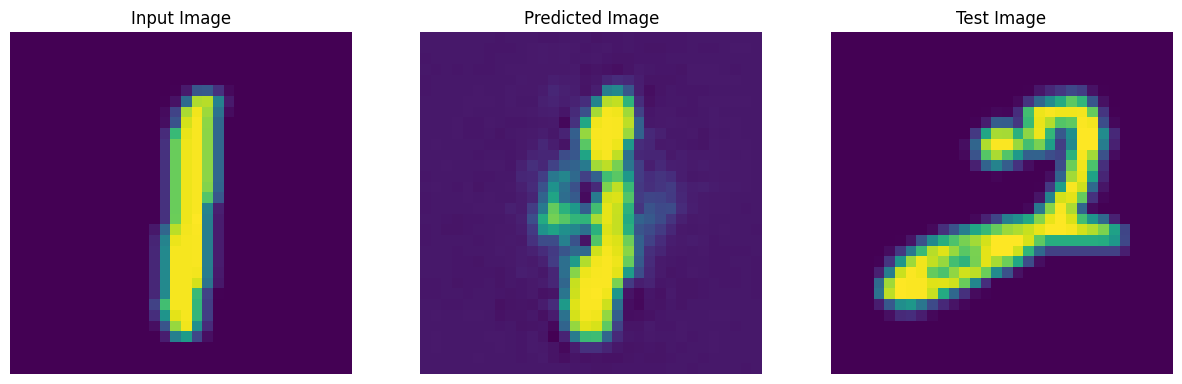

tf.Tensor(0.915693, shape=(), dtype=float32)
tf.Tensor(0.92402774, shape=(), dtype=float32)
tf.Tensor(0.9629137, shape=(), dtype=float32)
tf.Tensor(0.90600526, shape=(), dtype=float32)
tf.Tensor(0.8904053, shape=(), dtype=float32)
tf.Tensor(0.9253125, shape=(), dtype=float32)
tf.Tensor(0.9295056, shape=(), dtype=float32)
tf.Tensor(0.90349585, shape=(), dtype=float32)
tf.Tensor(0.92599595, shape=(), dtype=float32)
tf.Tensor(0.92191434, shape=(), dtype=float32)
tf.Tensor(0.8961005, shape=(), dtype=float32)
tf.Tensor(0.93428475, shape=(), dtype=float32)
tf.Tensor(0.92209756, shape=(), dtype=float32)
tf.Tensor(0.91371346, shape=(), dtype=float32)
tf.Tensor(0.9207002, shape=(), dtype=float32)
tf.Tensor(0.9030556, shape=(), dtype=float32)
tf.Tensor(0.92264056, shape=(), dtype=float32)
tf.Tensor(0.9033415, shape=(), dtype=float32)
tf.Tensor(0.90935224, shape=(), dtype=float32)
tf.Tensor(0.89023674, shape=(), dtype=float32)
tf.Tensor(0.904264, shape=(), dtype=float32)
tf.Tensor(0.9413896, shap

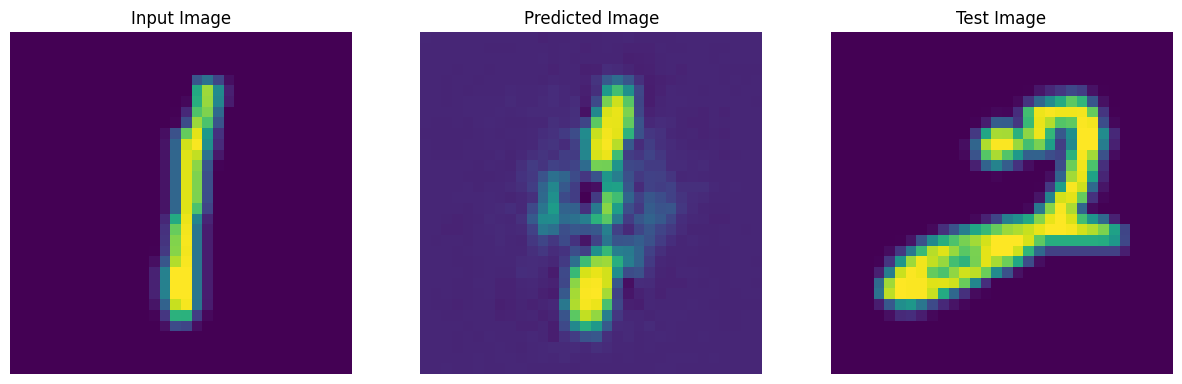

tf.Tensor(0.91372633, shape=(), dtype=float32)
tf.Tensor(0.9036942, shape=(), dtype=float32)
tf.Tensor(0.9179348, shape=(), dtype=float32)
tf.Tensor(0.8676958, shape=(), dtype=float32)
tf.Tensor(0.9199106, shape=(), dtype=float32)
tf.Tensor(0.9200026, shape=(), dtype=float32)
tf.Tensor(0.91158, shape=(), dtype=float32)
tf.Tensor(0.8972241, shape=(), dtype=float32)
tf.Tensor(0.8919237, shape=(), dtype=float32)
tf.Tensor(0.89636034, shape=(), dtype=float32)
tf.Tensor(0.9265275, shape=(), dtype=float32)
tf.Tensor(0.90735734, shape=(), dtype=float32)
tf.Tensor(0.9428983, shape=(), dtype=float32)
tf.Tensor(0.90846586, shape=(), dtype=float32)
tf.Tensor(0.9048244, shape=(), dtype=float32)
tf.Tensor(0.9058856, shape=(), dtype=float32)
tf.Tensor(0.8934901, shape=(), dtype=float32)
tf.Tensor(0.91282237, shape=(), dtype=float32)
tf.Tensor(0.90536165, shape=(), dtype=float32)
tf.Tensor(0.9126657, shape=(), dtype=float32)
tf.Tensor(0.87503874, shape=(), dtype=float32)
tf.Tensor(0.86016303, shape=(

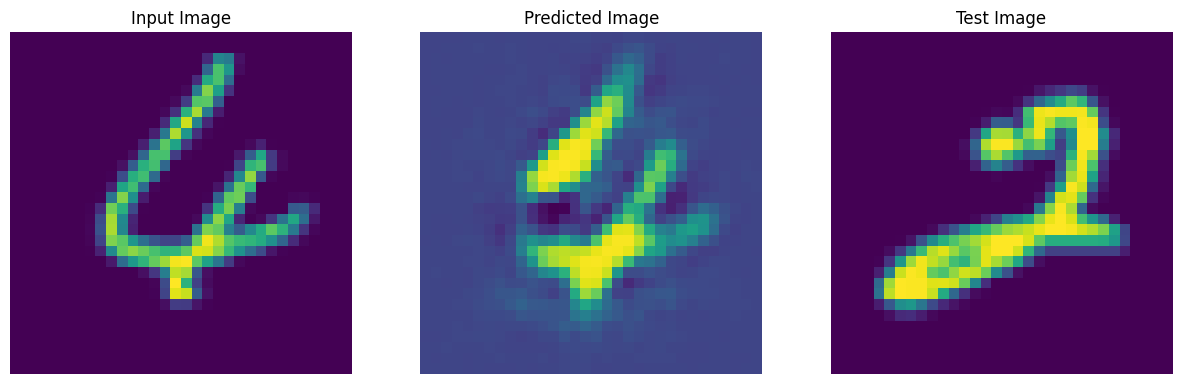

tf.Tensor(0.9057379, shape=(), dtype=float32)
tf.Tensor(0.8700708, shape=(), dtype=float32)
tf.Tensor(0.92310894, shape=(), dtype=float32)
tf.Tensor(0.89801145, shape=(), dtype=float32)
tf.Tensor(0.9079525, shape=(), dtype=float32)
tf.Tensor(0.8993007, shape=(), dtype=float32)
tf.Tensor(0.92204016, shape=(), dtype=float32)
tf.Tensor(0.9096751, shape=(), dtype=float32)
tf.Tensor(0.9118593, shape=(), dtype=float32)
tf.Tensor(0.8973758, shape=(), dtype=float32)
tf.Tensor(0.9106829, shape=(), dtype=float32)
tf.Tensor(0.8874779, shape=(), dtype=float32)
tf.Tensor(0.8723569, shape=(), dtype=float32)
tf.Tensor(0.90865105, shape=(), dtype=float32)
tf.Tensor(0.8668408, shape=(), dtype=float32)
tf.Tensor(0.9098956, shape=(), dtype=float32)
tf.Tensor(0.88714516, shape=(), dtype=float32)
tf.Tensor(0.863073, shape=(), dtype=float32)
tf.Tensor(0.8893036, shape=(), dtype=float32)
tf.Tensor(0.89241993, shape=(), dtype=float32)
tf.Tensor(0.87639785, shape=(), dtype=float32)
tf.Tensor(0.9026042, shape=(

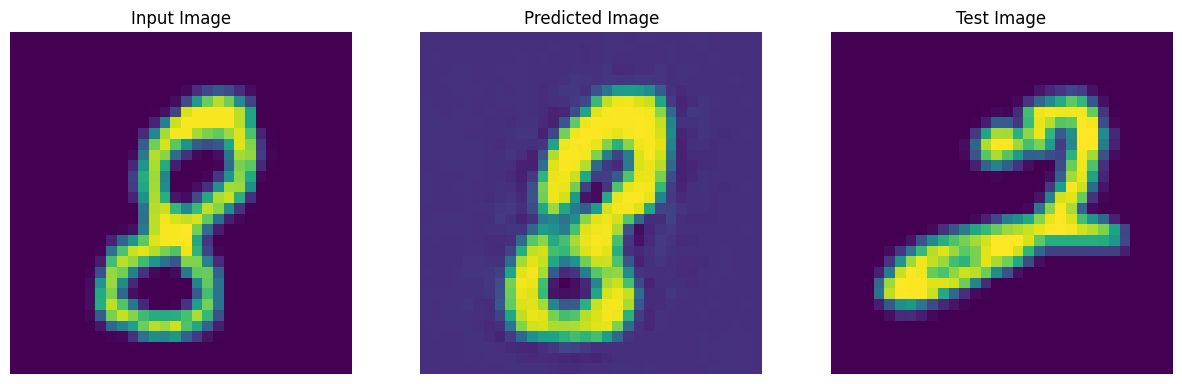

tf.Tensor(0.91930264, shape=(), dtype=float32)
tf.Tensor(0.91590977, shape=(), dtype=float32)
tf.Tensor(0.9329695, shape=(), dtype=float32)
tf.Tensor(0.89384055, shape=(), dtype=float32)
tf.Tensor(0.8981074, shape=(), dtype=float32)
tf.Tensor(0.8939537, shape=(), dtype=float32)
tf.Tensor(0.94771916, shape=(), dtype=float32)
tf.Tensor(0.8691635, shape=(), dtype=float32)
tf.Tensor(0.9011265, shape=(), dtype=float32)
tf.Tensor(0.88445497, shape=(), dtype=float32)
tf.Tensor(0.94442564, shape=(), dtype=float32)
tf.Tensor(0.88881516, shape=(), dtype=float32)
tf.Tensor(0.90767, shape=(), dtype=float32)
tf.Tensor(0.89386064, shape=(), dtype=float32)
tf.Tensor(0.89037186, shape=(), dtype=float32)
tf.Tensor(0.8960937, shape=(), dtype=float32)
tf.Tensor(0.91057587, shape=(), dtype=float32)
tf.Tensor(0.9163049, shape=(), dtype=float32)
tf.Tensor(0.8852098, shape=(), dtype=float32)
tf.Tensor(0.93637764, shape=(), dtype=float32)
tf.Tensor(0.9114192, shape=(), dtype=float32)
tf.Tensor(0.9265887, shap

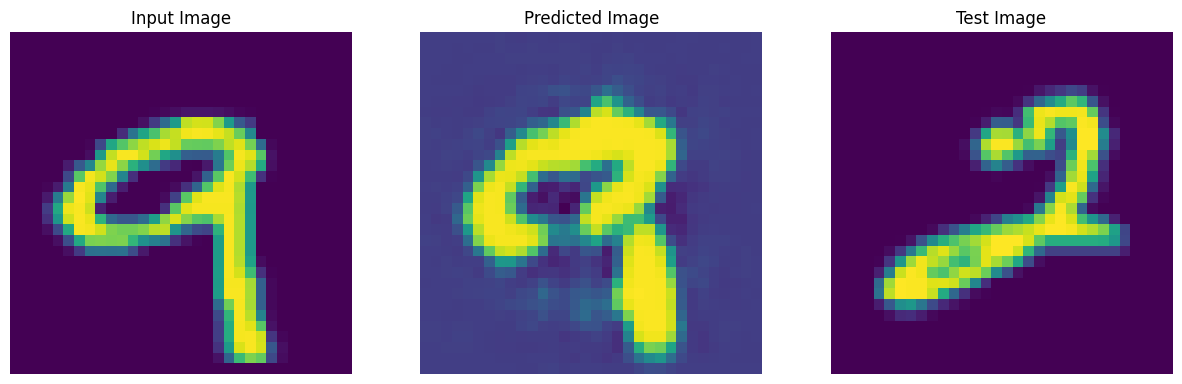

tf.Tensor(0.84177196, shape=(), dtype=float32)
tf.Tensor(0.8444382, shape=(), dtype=float32)
tf.Tensor(0.8473055, shape=(), dtype=float32)
tf.Tensor(0.8380632, shape=(), dtype=float32)
tf.Tensor(0.81905735, shape=(), dtype=float32)
tf.Tensor(0.8514767, shape=(), dtype=float32)
tf.Tensor(0.84211165, shape=(), dtype=float32)
tf.Tensor(0.8264299, shape=(), dtype=float32)
tf.Tensor(0.8182617, shape=(), dtype=float32)
tf.Tensor(0.85411114, shape=(), dtype=float32)
tf.Tensor(0.8357751, shape=(), dtype=float32)
tf.Tensor(0.8117875, shape=(), dtype=float32)
tf.Tensor(0.82341325, shape=(), dtype=float32)
tf.Tensor(0.81964153, shape=(), dtype=float32)
tf.Tensor(0.8386019, shape=(), dtype=float32)
tf.Tensor(0.86726695, shape=(), dtype=float32)
tf.Tensor(0.8604262, shape=(), dtype=float32)
tf.Tensor(0.84550095, shape=(), dtype=float32)
tf.Tensor(0.83459467, shape=(), dtype=float32)
tf.Tensor(0.8265862, shape=(), dtype=float32)
tf.Tensor(0.81853557, shape=(), dtype=float32)
tf.Tensor(0.871392, shap

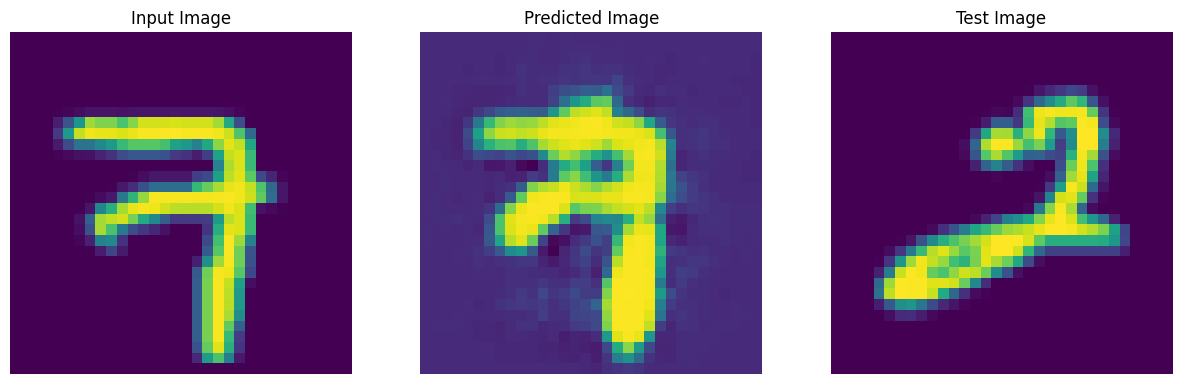

tf.Tensor(0.82990336, shape=(), dtype=float32)
tf.Tensor(0.8124411, shape=(), dtype=float32)
tf.Tensor(0.8096317, shape=(), dtype=float32)
tf.Tensor(0.8244353, shape=(), dtype=float32)
tf.Tensor(0.82611024, shape=(), dtype=float32)
tf.Tensor(0.83443904, shape=(), dtype=float32)
tf.Tensor(0.8140333, shape=(), dtype=float32)
tf.Tensor(0.83627045, shape=(), dtype=float32)
tf.Tensor(0.821432, shape=(), dtype=float32)
tf.Tensor(0.79724777, shape=(), dtype=float32)
tf.Tensor(0.8279485, shape=(), dtype=float32)
tf.Tensor(0.8155026, shape=(), dtype=float32)
tf.Tensor(0.8134103, shape=(), dtype=float32)
tf.Tensor(0.8049096, shape=(), dtype=float32)
tf.Tensor(0.82821155, shape=(), dtype=float32)
tf.Tensor(0.83538735, shape=(), dtype=float32)
tf.Tensor(0.8311913, shape=(), dtype=float32)
tf.Tensor(0.83084303, shape=(), dtype=float32)
tf.Tensor(0.8301824, shape=(), dtype=float32)
tf.Tensor(0.82775605, shape=(), dtype=float32)
tf.Tensor(0.82762766, shape=(), dtype=float32)
tf.Tensor(0.8137206, shap

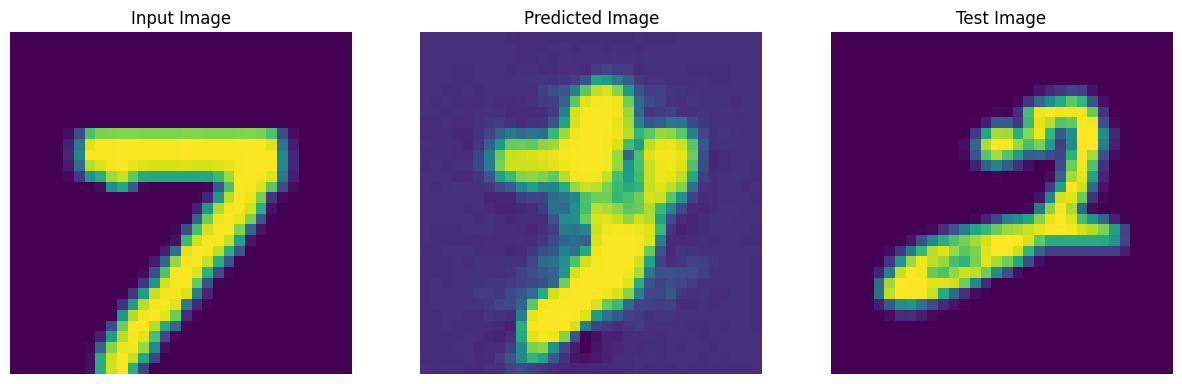

tf.Tensor(0.77409714, shape=(), dtype=float32)
tf.Tensor(0.8007647, shape=(), dtype=float32)
tf.Tensor(0.7800387, shape=(), dtype=float32)
tf.Tensor(0.77651227, shape=(), dtype=float32)
tf.Tensor(0.82118696, shape=(), dtype=float32)
tf.Tensor(0.8034172, shape=(), dtype=float32)
tf.Tensor(0.8233664, shape=(), dtype=float32)
tf.Tensor(0.79112196, shape=(), dtype=float32)
tf.Tensor(0.803475, shape=(), dtype=float32)
tf.Tensor(0.8298175, shape=(), dtype=float32)
tf.Tensor(0.81216604, shape=(), dtype=float32)
tf.Tensor(0.7993488, shape=(), dtype=float32)
tf.Tensor(0.8254677, shape=(), dtype=float32)
tf.Tensor(0.7864212, shape=(), dtype=float32)
tf.Tensor(0.76680744, shape=(), dtype=float32)
tf.Tensor(0.82049376, shape=(), dtype=float32)
tf.Tensor(0.7883675, shape=(), dtype=float32)
tf.Tensor(0.7808688, shape=(), dtype=float32)
tf.Tensor(0.77917826, shape=(), dtype=float32)
tf.Tensor(0.82793057, shape=(), dtype=float32)
tf.Tensor(0.78773504, shape=(), dtype=float32)
tf.Tensor(0.7773458, shap

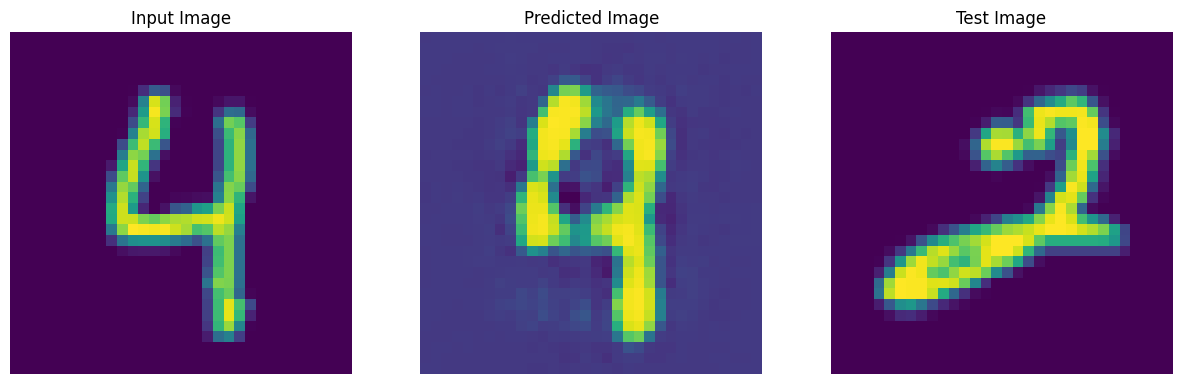

tf.Tensor(0.8006996, shape=(), dtype=float32)
tf.Tensor(0.824584, shape=(), dtype=float32)
tf.Tensor(0.7736368, shape=(), dtype=float32)
tf.Tensor(0.80175924, shape=(), dtype=float32)
tf.Tensor(0.7873067, shape=(), dtype=float32)
tf.Tensor(0.7952001, shape=(), dtype=float32)
tf.Tensor(0.78260547, shape=(), dtype=float32)
tf.Tensor(0.80407196, shape=(), dtype=float32)
tf.Tensor(0.795361, shape=(), dtype=float32)
tf.Tensor(0.7923502, shape=(), dtype=float32)
tf.Tensor(0.78556395, shape=(), dtype=float32)
tf.Tensor(0.7949625, shape=(), dtype=float32)
tf.Tensor(0.79575634, shape=(), dtype=float32)
tf.Tensor(0.8252364, shape=(), dtype=float32)
tf.Tensor(0.8320985, shape=(), dtype=float32)
tf.Tensor(0.8583236, shape=(), dtype=float32)
tf.Tensor(0.83640945, shape=(), dtype=float32)
tf.Tensor(0.8646102, shape=(), dtype=float32)
tf.Tensor(0.86184597, shape=(), dtype=float32)
tf.Tensor(0.81768537, shape=(), dtype=float32)
tf.Tensor(0.8075817, shape=(), dtype=float32)
tf.Tensor(0.86088115, shape=

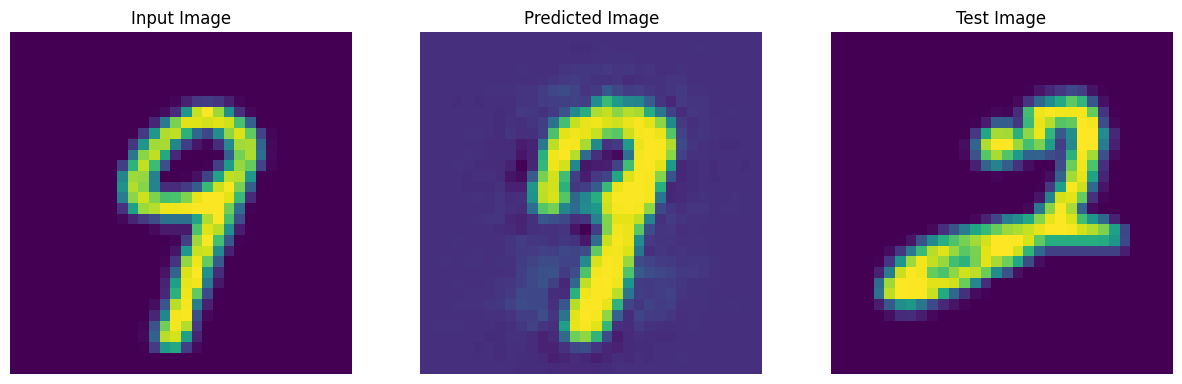

tf.Tensor(0.7633575, shape=(), dtype=float32)
tf.Tensor(0.7701697, shape=(), dtype=float32)
tf.Tensor(0.7800795, shape=(), dtype=float32)
tf.Tensor(0.76212573, shape=(), dtype=float32)
tf.Tensor(0.7718837, shape=(), dtype=float32)
tf.Tensor(0.77151597, shape=(), dtype=float32)
tf.Tensor(0.7868143, shape=(), dtype=float32)
tf.Tensor(0.81065, shape=(), dtype=float32)
tf.Tensor(0.7702329, shape=(), dtype=float32)
tf.Tensor(0.781689, shape=(), dtype=float32)
tf.Tensor(0.76827955, shape=(), dtype=float32)
tf.Tensor(0.77140146, shape=(), dtype=float32)
tf.Tensor(0.7872994, shape=(), dtype=float32)
tf.Tensor(0.7749293, shape=(), dtype=float32)
tf.Tensor(0.7830403, shape=(), dtype=float32)
tf.Tensor(0.7615294, shape=(), dtype=float32)
tf.Tensor(0.7707309, shape=(), dtype=float32)
tf.Tensor(0.7515387, shape=(), dtype=float32)
tf.Tensor(0.7885394, shape=(), dtype=float32)
tf.Tensor(0.7787738, shape=(), dtype=float32)
tf.Tensor(0.7942124, shape=(), dtype=float32)
tf.Tensor(0.7724656, shape=(), dt

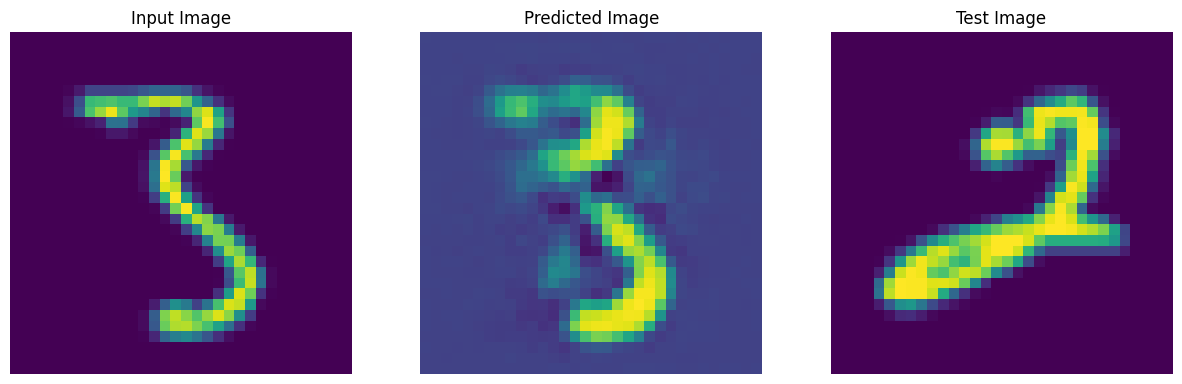

tf.Tensor(0.7912041, shape=(), dtype=float32)
tf.Tensor(0.77567863, shape=(), dtype=float32)
tf.Tensor(0.7626257, shape=(), dtype=float32)
tf.Tensor(0.76101613, shape=(), dtype=float32)
tf.Tensor(0.7718823, shape=(), dtype=float32)
tf.Tensor(0.7745733, shape=(), dtype=float32)
tf.Tensor(0.7838118, shape=(), dtype=float32)
tf.Tensor(0.7531586, shape=(), dtype=float32)
tf.Tensor(0.7766358, shape=(), dtype=float32)
tf.Tensor(0.76677215, shape=(), dtype=float32)
tf.Tensor(0.7891303, shape=(), dtype=float32)
tf.Tensor(0.76499236, shape=(), dtype=float32)
tf.Tensor(0.79103863, shape=(), dtype=float32)
tf.Tensor(0.79258364, shape=(), dtype=float32)
tf.Tensor(0.7700419, shape=(), dtype=float32)
tf.Tensor(0.7709614, shape=(), dtype=float32)
tf.Tensor(0.7813759, shape=(), dtype=float32)
tf.Tensor(0.7605993, shape=(), dtype=float32)
tf.Tensor(0.75603795, shape=(), dtype=float32)
tf.Tensor(0.75063676, shape=(), dtype=float32)
tf.Tensor(0.7456305, shape=(), dtype=float32)
tf.Tensor(0.7770938, shape

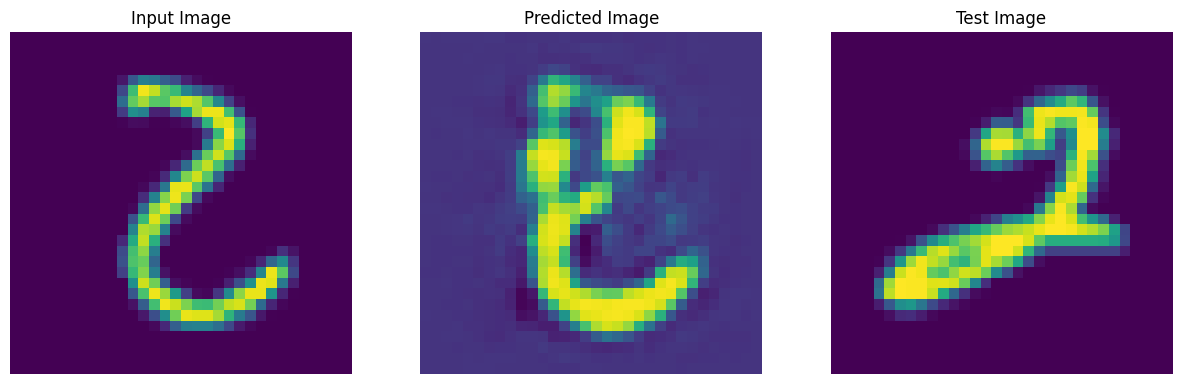

tf.Tensor(0.77203035, shape=(), dtype=float32)
tf.Tensor(0.77566254, shape=(), dtype=float32)
tf.Tensor(0.77797735, shape=(), dtype=float32)
tf.Tensor(0.7565464, shape=(), dtype=float32)
tf.Tensor(0.767423, shape=(), dtype=float32)
tf.Tensor(0.7756878, shape=(), dtype=float32)
tf.Tensor(0.7621868, shape=(), dtype=float32)
tf.Tensor(0.74219084, shape=(), dtype=float32)
tf.Tensor(0.746359, shape=(), dtype=float32)
tf.Tensor(0.7443376, shape=(), dtype=float32)
tf.Tensor(0.74570906, shape=(), dtype=float32)
tf.Tensor(0.7507352, shape=(), dtype=float32)
tf.Tensor(0.74567264, shape=(), dtype=float32)
tf.Tensor(0.76562613, shape=(), dtype=float32)
tf.Tensor(0.74908835, shape=(), dtype=float32)
tf.Tensor(0.77791005, shape=(), dtype=float32)
tf.Tensor(0.75284517, shape=(), dtype=float32)
tf.Tensor(0.774321, shape=(), dtype=float32)
tf.Tensor(0.7716338, shape=(), dtype=float32)
tf.Tensor(0.7706749, shape=(), dtype=float32)
tf.Tensor(0.7760434, shape=(), dtype=float32)
tf.Tensor(0.76726055, shape

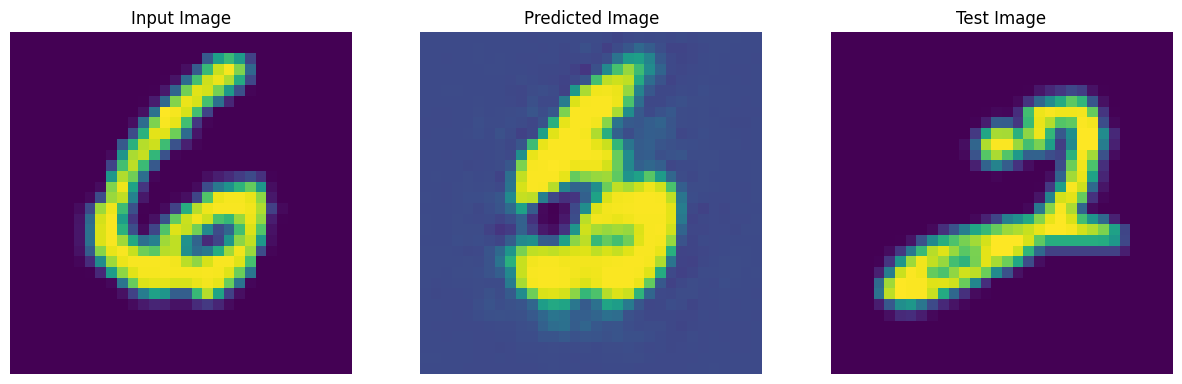

tf.Tensor(0.74862796, shape=(), dtype=float32)
tf.Tensor(0.7447808, shape=(), dtype=float32)
tf.Tensor(0.7813937, shape=(), dtype=float32)
tf.Tensor(0.75649834, shape=(), dtype=float32)
tf.Tensor(0.7666106, shape=(), dtype=float32)
tf.Tensor(0.7699127, shape=(), dtype=float32)
tf.Tensor(0.7578408, shape=(), dtype=float32)
tf.Tensor(0.77234066, shape=(), dtype=float32)
tf.Tensor(0.76698774, shape=(), dtype=float32)
tf.Tensor(0.76786333, shape=(), dtype=float32)
tf.Tensor(0.7642105, shape=(), dtype=float32)
tf.Tensor(0.7664076, shape=(), dtype=float32)
tf.Tensor(0.7582704, shape=(), dtype=float32)
tf.Tensor(0.7854386, shape=(), dtype=float32)
tf.Tensor(0.7818143, shape=(), dtype=float32)
tf.Tensor(0.8193909, shape=(), dtype=float32)
tf.Tensor(0.79173625, shape=(), dtype=float32)
tf.Tensor(0.7720585, shape=(), dtype=float32)
tf.Tensor(0.8116453, shape=(), dtype=float32)
tf.Tensor(0.8003472, shape=(), dtype=float32)
tf.Tensor(0.80993426, shape=(), dtype=float32)
tf.Tensor(0.8077432, shape=

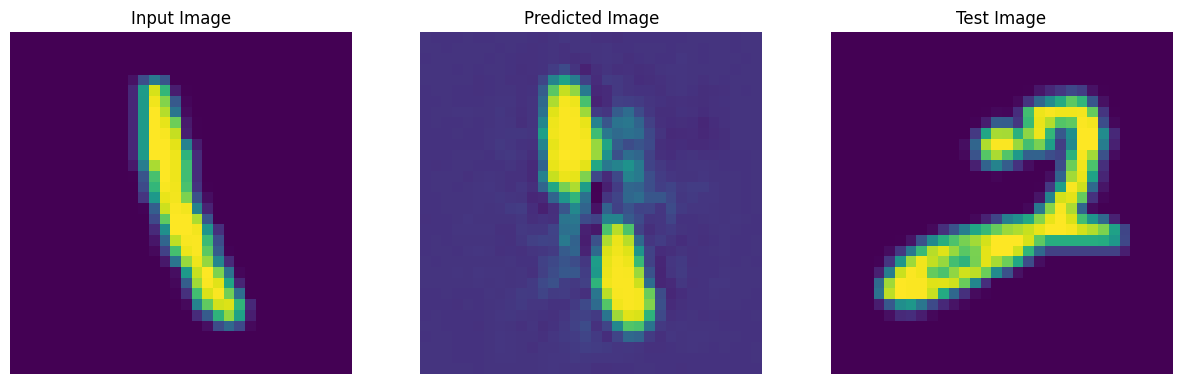

tf.Tensor(0.704889, shape=(), dtype=float32)
tf.Tensor(0.7259593, shape=(), dtype=float32)
tf.Tensor(0.74261534, shape=(), dtype=float32)
tf.Tensor(0.75363475, shape=(), dtype=float32)
tf.Tensor(0.71892947, shape=(), dtype=float32)
tf.Tensor(0.7332812, shape=(), dtype=float32)
tf.Tensor(0.743713, shape=(), dtype=float32)
tf.Tensor(0.7431881, shape=(), dtype=float32)
tf.Tensor(0.7392618, shape=(), dtype=float32)
tf.Tensor(0.7424464, shape=(), dtype=float32)
tf.Tensor(0.7558867, shape=(), dtype=float32)
tf.Tensor(0.7396584, shape=(), dtype=float32)
tf.Tensor(0.74445707, shape=(), dtype=float32)
tf.Tensor(0.73496103, shape=(), dtype=float32)
tf.Tensor(0.730296, shape=(), dtype=float32)
tf.Tensor(0.72239083, shape=(), dtype=float32)
tf.Tensor(0.7231727, shape=(), dtype=float32)
tf.Tensor(0.72919476, shape=(), dtype=float32)
tf.Tensor(0.71502244, shape=(), dtype=float32)
tf.Tensor(0.72504663, shape=(), dtype=float32)
tf.Tensor(0.716761, shape=(), dtype=float32)
tf.Tensor(0.727636, shape=(),

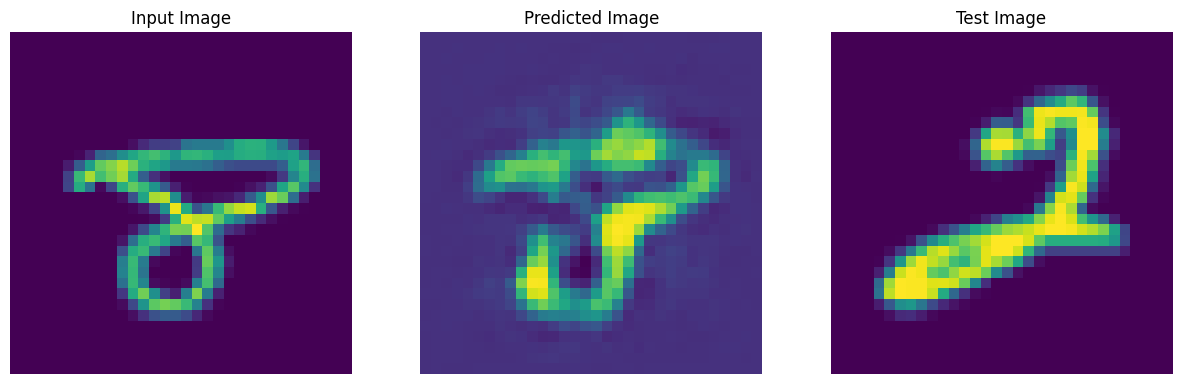

tf.Tensor(0.73419046, shape=(), dtype=float32)
tf.Tensor(0.7286268, shape=(), dtype=float32)
tf.Tensor(0.7206471, shape=(), dtype=float32)
tf.Tensor(0.7353756, shape=(), dtype=float32)
tf.Tensor(0.7297551, shape=(), dtype=float32)
tf.Tensor(0.7195878, shape=(), dtype=float32)
tf.Tensor(0.74242735, shape=(), dtype=float32)
tf.Tensor(0.72513306, shape=(), dtype=float32)
tf.Tensor(0.71309936, shape=(), dtype=float32)
tf.Tensor(0.7512466, shape=(), dtype=float32)
tf.Tensor(0.7177428, shape=(), dtype=float32)
tf.Tensor(0.7437802, shape=(), dtype=float32)
tf.Tensor(0.7283698, shape=(), dtype=float32)
tf.Tensor(0.7422524, shape=(), dtype=float32)
tf.Tensor(0.72155786, shape=(), dtype=float32)
tf.Tensor(0.72976255, shape=(), dtype=float32)
tf.Tensor(0.7184162, shape=(), dtype=float32)
tf.Tensor(0.7165724, shape=(), dtype=float32)
tf.Tensor(0.70592034, shape=(), dtype=float32)
tf.Tensor(0.72217715, shape=(), dtype=float32)
tf.Tensor(0.7301825, shape=(), dtype=float32)
tf.Tensor(0.72190416, shap

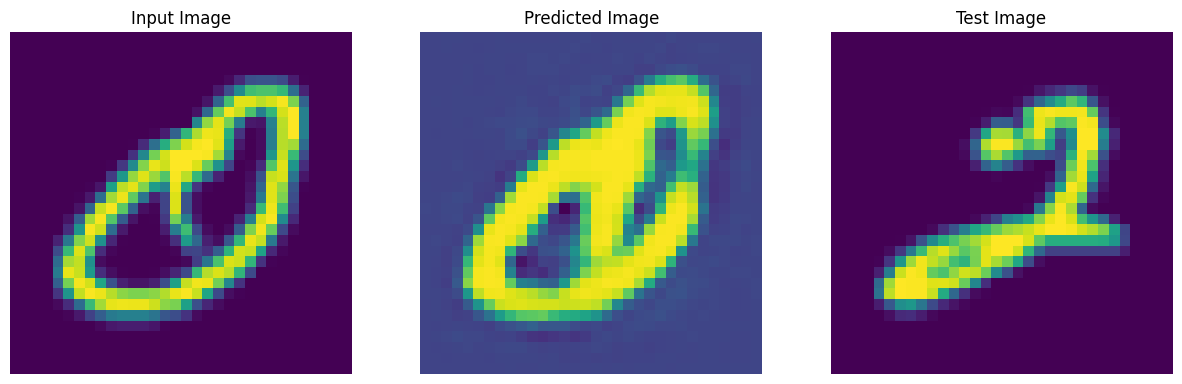

tf.Tensor(0.70786375, shape=(), dtype=float32)
tf.Tensor(0.69316554, shape=(), dtype=float32)
tf.Tensor(0.69249415, shape=(), dtype=float32)
tf.Tensor(0.7117812, shape=(), dtype=float32)
tf.Tensor(0.7261215, shape=(), dtype=float32)
tf.Tensor(0.7050431, shape=(), dtype=float32)
tf.Tensor(0.71411633, shape=(), dtype=float32)
tf.Tensor(0.7157168, shape=(), dtype=float32)
tf.Tensor(0.70509857, shape=(), dtype=float32)
tf.Tensor(0.71970916, shape=(), dtype=float32)
tf.Tensor(0.70237494, shape=(), dtype=float32)
tf.Tensor(0.69871485, shape=(), dtype=float32)
tf.Tensor(0.7131458, shape=(), dtype=float32)
tf.Tensor(0.7103889, shape=(), dtype=float32)
tf.Tensor(0.7192507, shape=(), dtype=float32)
tf.Tensor(0.73711205, shape=(), dtype=float32)
tf.Tensor(0.7115146, shape=(), dtype=float32)
tf.Tensor(0.7306169, shape=(), dtype=float32)
tf.Tensor(0.7081861, shape=(), dtype=float32)
tf.Tensor(0.7273834, shape=(), dtype=float32)
tf.Tensor(0.7318486, shape=(), dtype=float32)
tf.Tensor(0.72239834, sha

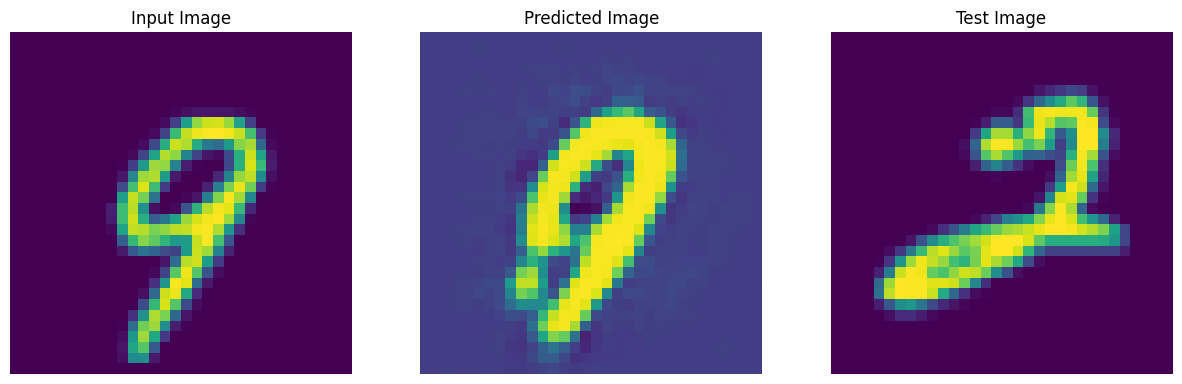

tf.Tensor(0.7108455, shape=(), dtype=float32)
tf.Tensor(0.6834615, shape=(), dtype=float32)
tf.Tensor(0.70247656, shape=(), dtype=float32)
tf.Tensor(0.70292515, shape=(), dtype=float32)
tf.Tensor(0.68768996, shape=(), dtype=float32)
tf.Tensor(0.71291924, shape=(), dtype=float32)
tf.Tensor(0.70596516, shape=(), dtype=float32)
tf.Tensor(0.69785094, shape=(), dtype=float32)
tf.Tensor(0.7094555, shape=(), dtype=float32)
tf.Tensor(0.7173169, shape=(), dtype=float32)
tf.Tensor(0.70977026, shape=(), dtype=float32)
tf.Tensor(0.70269644, shape=(), dtype=float32)
tf.Tensor(0.7103786, shape=(), dtype=float32)
tf.Tensor(0.713192, shape=(), dtype=float32)
tf.Tensor(0.7050806, shape=(), dtype=float32)
tf.Tensor(0.74018043, shape=(), dtype=float32)
tf.Tensor(0.74025726, shape=(), dtype=float32)
tf.Tensor(0.7407901, shape=(), dtype=float32)
tf.Tensor(0.74651396, shape=(), dtype=float32)
tf.Tensor(0.7425368, shape=(), dtype=float32)
tf.Tensor(0.7092414, shape=(), dtype=float32)
tf.Tensor(0.7401239, sha

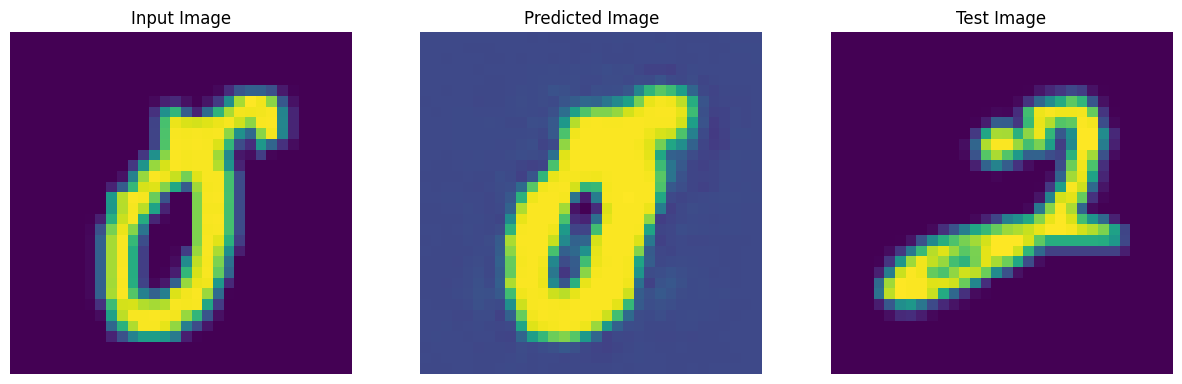

tf.Tensor(0.69696814, shape=(), dtype=float32)
tf.Tensor(0.67853427, shape=(), dtype=float32)
tf.Tensor(0.6824057, shape=(), dtype=float32)
tf.Tensor(0.6792443, shape=(), dtype=float32)
tf.Tensor(0.68230164, shape=(), dtype=float32)
tf.Tensor(0.678204, shape=(), dtype=float32)
tf.Tensor(0.68770003, shape=(), dtype=float32)
tf.Tensor(0.69508123, shape=(), dtype=float32)
tf.Tensor(0.6792661, shape=(), dtype=float32)
tf.Tensor(0.6724412, shape=(), dtype=float32)
tf.Tensor(0.6866329, shape=(), dtype=float32)
tf.Tensor(0.69105417, shape=(), dtype=float32)
tf.Tensor(0.68554187, shape=(), dtype=float32)
tf.Tensor(0.6914592, shape=(), dtype=float32)
tf.Tensor(0.6809721, shape=(), dtype=float32)
tf.Tensor(0.6658295, shape=(), dtype=float32)
tf.Tensor(0.67265844, shape=(), dtype=float32)
tf.Tensor(0.6808829, shape=(), dtype=float32)
tf.Tensor(0.66942006, shape=(), dtype=float32)
tf.Tensor(0.66101784, shape=(), dtype=float32)
tf.Tensor(0.66873, shape=(), dtype=float32)
tf.Tensor(0.67413706, shape

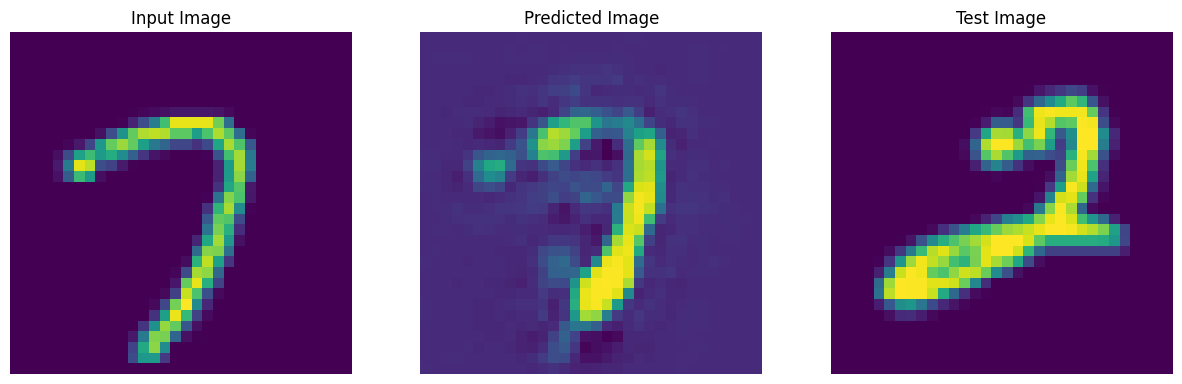

tf.Tensor(0.6676645, shape=(), dtype=float32)
tf.Tensor(0.65730226, shape=(), dtype=float32)
tf.Tensor(0.68426013, shape=(), dtype=float32)
tf.Tensor(0.6564859, shape=(), dtype=float32)
tf.Tensor(0.65581673, shape=(), dtype=float32)
tf.Tensor(0.66157466, shape=(), dtype=float32)
tf.Tensor(0.67091393, shape=(), dtype=float32)
tf.Tensor(0.64719915, shape=(), dtype=float32)
tf.Tensor(0.6503053, shape=(), dtype=float32)
tf.Tensor(0.6559684, shape=(), dtype=float32)
tf.Tensor(0.6623695, shape=(), dtype=float32)
tf.Tensor(0.66175604, shape=(), dtype=float32)
tf.Tensor(0.6736511, shape=(), dtype=float32)
tf.Tensor(0.658599, shape=(), dtype=float32)
tf.Tensor(0.6882814, shape=(), dtype=float32)
tf.Tensor(0.67599535, shape=(), dtype=float32)
tf.Tensor(0.65291846, shape=(), dtype=float32)
tf.Tensor(0.67990875, shape=(), dtype=float32)
tf.Tensor(0.651379, shape=(), dtype=float32)
tf.Tensor(0.6579442, shape=(), dtype=float32)
tf.Tensor(0.6743589, shape=(), dtype=float32)
tf.Tensor(0.695127, shape=

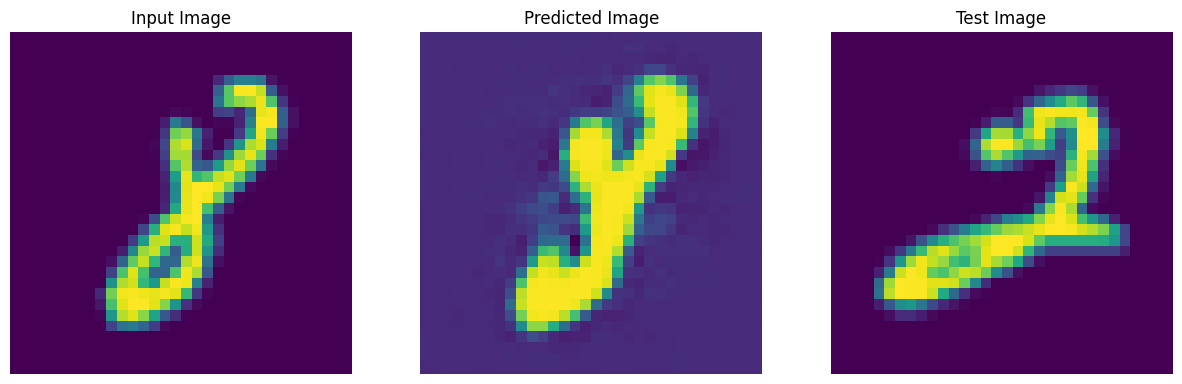

tf.Tensor(0.6682292, shape=(), dtype=float32)
tf.Tensor(0.659292, shape=(), dtype=float32)
tf.Tensor(0.6437044, shape=(), dtype=float32)
tf.Tensor(0.6607835, shape=(), dtype=float32)
tf.Tensor(0.6896583, shape=(), dtype=float32)
tf.Tensor(0.6547559, shape=(), dtype=float32)
tf.Tensor(0.653754, shape=(), dtype=float32)
tf.Tensor(0.64304715, shape=(), dtype=float32)
tf.Tensor(0.6603441, shape=(), dtype=float32)
tf.Tensor(0.6494174, shape=(), dtype=float32)
tf.Tensor(0.65119237, shape=(), dtype=float32)
tf.Tensor(0.6394631, shape=(), dtype=float32)
tf.Tensor(0.6392792, shape=(), dtype=float32)
tf.Tensor(0.644377, shape=(), dtype=float32)
tf.Tensor(0.62652236, shape=(), dtype=float32)
tf.Tensor(0.6344584, shape=(), dtype=float32)
tf.Tensor(0.6624418, shape=(), dtype=float32)
tf.Tensor(0.6535083, shape=(), dtype=float32)
tf.Tensor(0.6412736, shape=(), dtype=float32)
tf.Tensor(0.63034976, shape=(), dtype=float32)
tf.Tensor(0.62814933, shape=(), dtype=float32)
tf.Tensor(0.6374843, shape=(), d

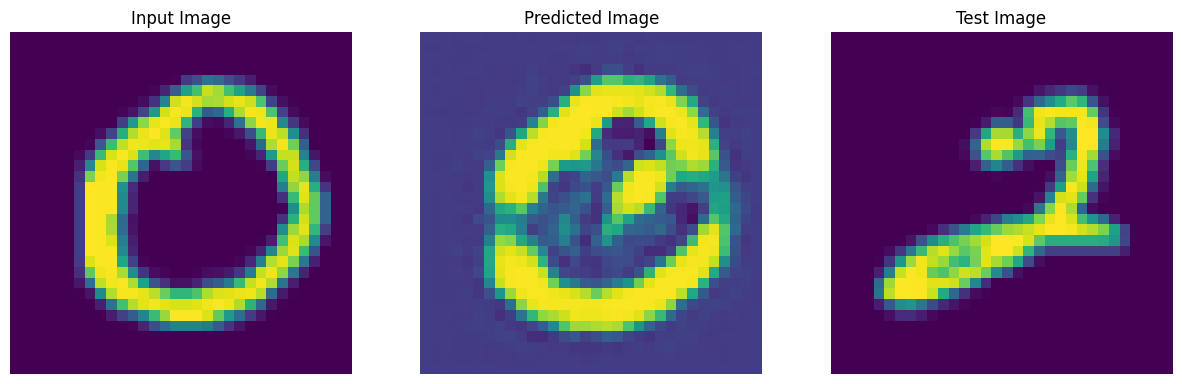

tf.Tensor(0.64230585, shape=(), dtype=float32)
tf.Tensor(0.63313603, shape=(), dtype=float32)
tf.Tensor(0.67271316, shape=(), dtype=float32)
tf.Tensor(0.65336263, shape=(), dtype=float32)
tf.Tensor(0.6377307, shape=(), dtype=float32)
tf.Tensor(0.64497524, shape=(), dtype=float32)
tf.Tensor(0.66661286, shape=(), dtype=float32)
tf.Tensor(0.66467214, shape=(), dtype=float32)
tf.Tensor(0.68886083, shape=(), dtype=float32)
tf.Tensor(0.66580546, shape=(), dtype=float32)
tf.Tensor(0.65506214, shape=(), dtype=float32)
tf.Tensor(0.6517041, shape=(), dtype=float32)
tf.Tensor(0.6559187, shape=(), dtype=float32)
tf.Tensor(0.66873085, shape=(), dtype=float32)
tf.Tensor(0.6497193, shape=(), dtype=float32)
tf.Tensor(0.6765, shape=(), dtype=float32)
tf.Tensor(0.7061641, shape=(), dtype=float32)
tf.Tensor(0.7078414, shape=(), dtype=float32)
tf.Tensor(0.6997248, shape=(), dtype=float32)
tf.Tensor(0.6937612, shape=(), dtype=float32)
tf.Tensor(0.68441087, shape=(), dtype=float32)
tf.Tensor(0.69987595, sha

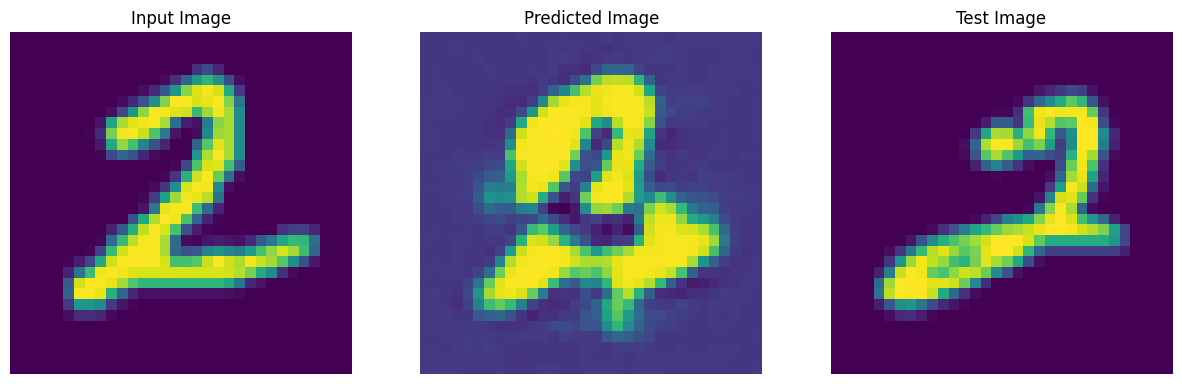

tf.Tensor(0.68008935, shape=(), dtype=float32)
tf.Tensor(0.6610137, shape=(), dtype=float32)
tf.Tensor(0.6291242, shape=(), dtype=float32)
tf.Tensor(0.6406035, shape=(), dtype=float32)
tf.Tensor(0.6525012, shape=(), dtype=float32)
tf.Tensor(0.692835, shape=(), dtype=float32)
tf.Tensor(0.6543122, shape=(), dtype=float32)
tf.Tensor(0.6738551, shape=(), dtype=float32)
tf.Tensor(0.6345639, shape=(), dtype=float32)
tf.Tensor(0.6367575, shape=(), dtype=float32)
tf.Tensor(0.64461803, shape=(), dtype=float32)
tf.Tensor(0.65479314, shape=(), dtype=float32)
tf.Tensor(0.65005153, shape=(), dtype=float32)
tf.Tensor(0.6696868, shape=(), dtype=float32)
tf.Tensor(0.6650814, shape=(), dtype=float32)
tf.Tensor(0.6634133, shape=(), dtype=float32)
tf.Tensor(0.65413976, shape=(), dtype=float32)
tf.Tensor(0.6611773, shape=(), dtype=float32)
tf.Tensor(0.66330606, shape=(), dtype=float32)
tf.Tensor(0.6415098, shape=(), dtype=float32)
tf.Tensor(0.6564234, shape=(), dtype=float32)
tf.Tensor(0.66397303, shape=(

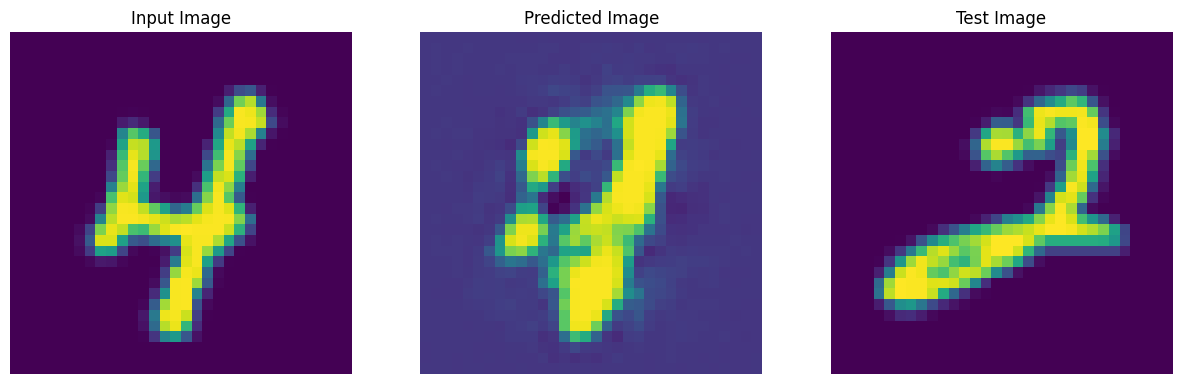

tf.Tensor(0.62717026, shape=(), dtype=float32)
tf.Tensor(0.65612197, shape=(), dtype=float32)
tf.Tensor(0.6431256, shape=(), dtype=float32)
tf.Tensor(0.6364387, shape=(), dtype=float32)
tf.Tensor(0.6192188, shape=(), dtype=float32)
tf.Tensor(0.6611036, shape=(), dtype=float32)
tf.Tensor(0.6390338, shape=(), dtype=float32)
tf.Tensor(0.6458138, shape=(), dtype=float32)
tf.Tensor(0.6292253, shape=(), dtype=float32)
tf.Tensor(0.63306725, shape=(), dtype=float32)
tf.Tensor(0.6454831, shape=(), dtype=float32)
tf.Tensor(0.6275518, shape=(), dtype=float32)
tf.Tensor(0.653762, shape=(), dtype=float32)
tf.Tensor(0.6622815, shape=(), dtype=float32)
tf.Tensor(0.65042925, shape=(), dtype=float32)
tf.Tensor(0.65486807, shape=(), dtype=float32)
tf.Tensor(0.6412668, shape=(), dtype=float32)
tf.Tensor(0.64520335, shape=(), dtype=float32)
tf.Tensor(0.63880086, shape=(), dtype=float32)
tf.Tensor(0.64076626, shape=(), dtype=float32)
tf.Tensor(0.644464, shape=(), dtype=float32)
tf.Tensor(0.6375942, shape=(

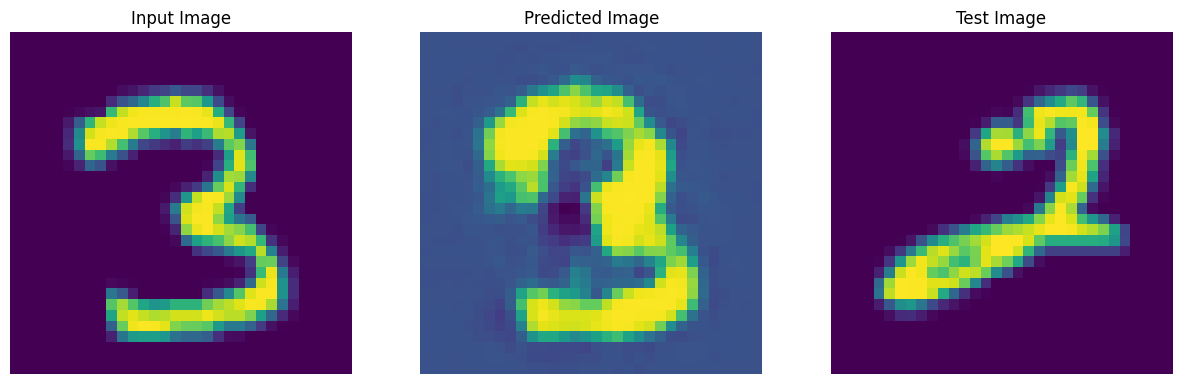

tf.Tensor(0.6189919, shape=(), dtype=float32)
tf.Tensor(0.6309558, shape=(), dtype=float32)
tf.Tensor(0.6330536, shape=(), dtype=float32)
tf.Tensor(0.63272285, shape=(), dtype=float32)
tf.Tensor(0.6268873, shape=(), dtype=float32)
tf.Tensor(0.6347434, shape=(), dtype=float32)
tf.Tensor(0.6368531, shape=(), dtype=float32)
tf.Tensor(0.644011, shape=(), dtype=float32)
tf.Tensor(0.6077467, shape=(), dtype=float32)
tf.Tensor(0.63873667, shape=(), dtype=float32)
tf.Tensor(0.6334437, shape=(), dtype=float32)
tf.Tensor(0.6103049, shape=(), dtype=float32)
tf.Tensor(0.62261677, shape=(), dtype=float32)
tf.Tensor(0.6243691, shape=(), dtype=float32)
tf.Tensor(0.5967082, shape=(), dtype=float32)
tf.Tensor(0.6238851, shape=(), dtype=float32)
tf.Tensor(0.620649, shape=(), dtype=float32)
tf.Tensor(0.6199827, shape=(), dtype=float32)
tf.Tensor(0.6094684, shape=(), dtype=float32)
tf.Tensor(0.61183167, shape=(), dtype=float32)
tf.Tensor(0.6088843, shape=(), dtype=float32)
tf.Tensor(0.6251485, shape=(), d

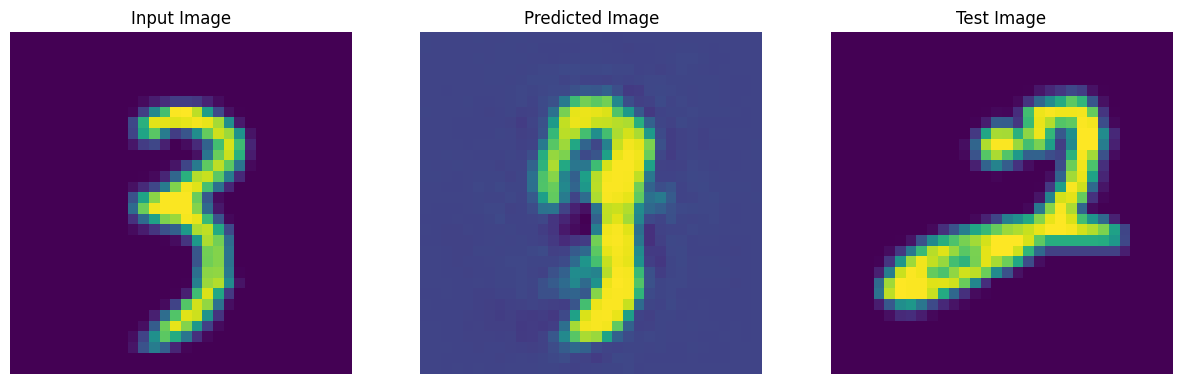

tf.Tensor(0.6199526, shape=(), dtype=float32)
tf.Tensor(0.6345291, shape=(), dtype=float32)
tf.Tensor(0.6048519, shape=(), dtype=float32)
tf.Tensor(0.63557816, shape=(), dtype=float32)
tf.Tensor(0.6434296, shape=(), dtype=float32)
tf.Tensor(0.62035906, shape=(), dtype=float32)
tf.Tensor(0.6361157, shape=(), dtype=float32)
tf.Tensor(0.6333631, shape=(), dtype=float32)
tf.Tensor(0.63402426, shape=(), dtype=float32)
tf.Tensor(0.628497, shape=(), dtype=float32)
tf.Tensor(0.6510601, shape=(), dtype=float32)
tf.Tensor(0.6548095, shape=(), dtype=float32)
tf.Tensor(0.66417956, shape=(), dtype=float32)
tf.Tensor(0.6597698, shape=(), dtype=float32)
tf.Tensor(0.6985884, shape=(), dtype=float32)
tf.Tensor(0.7017442, shape=(), dtype=float32)
tf.Tensor(0.7003487, shape=(), dtype=float32)
tf.Tensor(0.68474686, shape=(), dtype=float32)
tf.Tensor(0.65633714, shape=(), dtype=float32)
tf.Tensor(0.6710308, shape=(), dtype=float32)
tf.Tensor(0.69187486, shape=(), dtype=float32)
tf.Tensor(0.6677786, shape=(

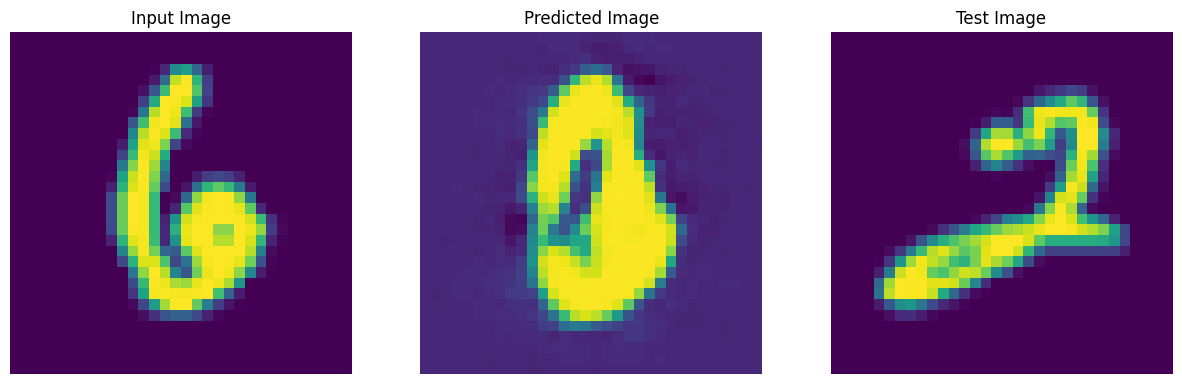

tf.Tensor(0.6157293, shape=(), dtype=float32)
tf.Tensor(0.611112, shape=(), dtype=float32)
tf.Tensor(0.61817366, shape=(), dtype=float32)
tf.Tensor(0.60056156, shape=(), dtype=float32)
tf.Tensor(0.6116663, shape=(), dtype=float32)
tf.Tensor(0.60808986, shape=(), dtype=float32)
tf.Tensor(0.61818266, shape=(), dtype=float32)
tf.Tensor(0.60740143, shape=(), dtype=float32)
tf.Tensor(0.6124096, shape=(), dtype=float32)
tf.Tensor(0.60941505, shape=(), dtype=float32)
tf.Tensor(0.6041653, shape=(), dtype=float32)
tf.Tensor(0.6090596, shape=(), dtype=float32)
tf.Tensor(0.6116952, shape=(), dtype=float32)
tf.Tensor(0.5861881, shape=(), dtype=float32)
tf.Tensor(0.6118158, shape=(), dtype=float32)
tf.Tensor(0.60697025, shape=(), dtype=float32)
tf.Tensor(0.59940624, shape=(), dtype=float32)
tf.Tensor(0.6053615, shape=(), dtype=float32)
tf.Tensor(0.6227794, shape=(), dtype=float32)
tf.Tensor(0.6134331, shape=(), dtype=float32)
tf.Tensor(0.6239122, shape=(), dtype=float32)
tf.Tensor(0.60836244, shape

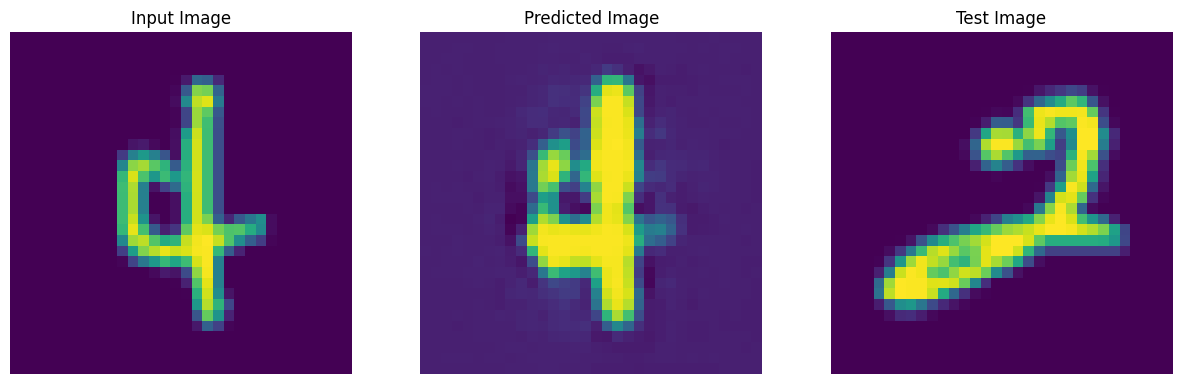

tf.Tensor(0.6107594, shape=(), dtype=float32)
tf.Tensor(0.57949734, shape=(), dtype=float32)
tf.Tensor(0.6046921, shape=(), dtype=float32)
tf.Tensor(0.5662534, shape=(), dtype=float32)
tf.Tensor(0.579731, shape=(), dtype=float32)
tf.Tensor(0.5734346, shape=(), dtype=float32)
tf.Tensor(0.5838574, shape=(), dtype=float32)
tf.Tensor(0.590571, shape=(), dtype=float32)
tf.Tensor(0.60782063, shape=(), dtype=float32)
tf.Tensor(0.5949887, shape=(), dtype=float32)
tf.Tensor(0.6121637, shape=(), dtype=float32)
tf.Tensor(0.6153031, shape=(), dtype=float32)
tf.Tensor(0.60236424, shape=(), dtype=float32)
tf.Tensor(0.59527767, shape=(), dtype=float32)
tf.Tensor(0.57126784, shape=(), dtype=float32)
tf.Tensor(0.59399104, shape=(), dtype=float32)
tf.Tensor(0.58801824, shape=(), dtype=float32)
tf.Tensor(0.60094464, shape=(), dtype=float32)
tf.Tensor(0.5909218, shape=(), dtype=float32)
tf.Tensor(0.588951, shape=(), dtype=float32)
tf.Tensor(0.5981401, shape=(), dtype=float32)
tf.Tensor(0.59935963, shape=(

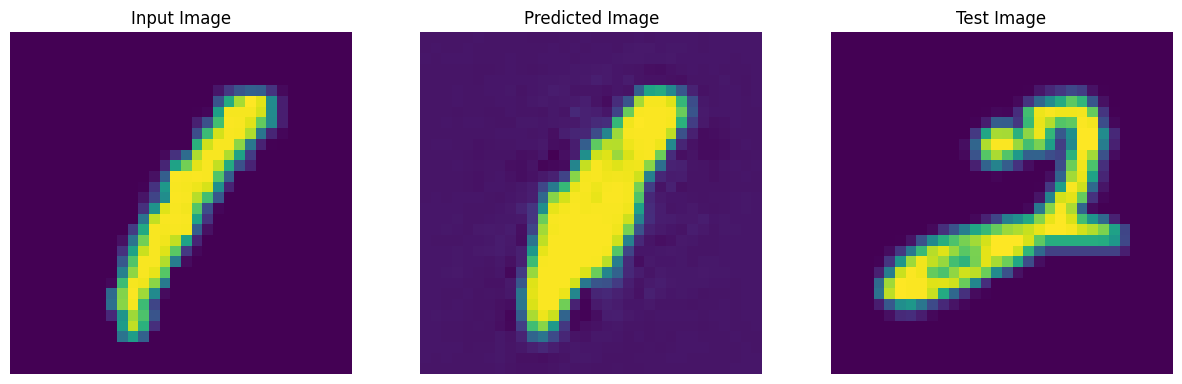

tf.Tensor(0.59131855, shape=(), dtype=float32)
tf.Tensor(0.59738284, shape=(), dtype=float32)
tf.Tensor(0.609342, shape=(), dtype=float32)
tf.Tensor(0.600701, shape=(), dtype=float32)
tf.Tensor(0.58274007, shape=(), dtype=float32)
tf.Tensor(0.59925234, shape=(), dtype=float32)
tf.Tensor(0.57811785, shape=(), dtype=float32)
tf.Tensor(0.57622385, shape=(), dtype=float32)
tf.Tensor(0.58628476, shape=(), dtype=float32)
tf.Tensor(0.62078637, shape=(), dtype=float32)
tf.Tensor(0.59227884, shape=(), dtype=float32)
tf.Tensor(0.5849158, shape=(), dtype=float32)
tf.Tensor(0.5620226, shape=(), dtype=float32)
tf.Tensor(0.58824986, shape=(), dtype=float32)
tf.Tensor(0.5771515, shape=(), dtype=float32)
tf.Tensor(0.5966831, shape=(), dtype=float32)
tf.Tensor(0.57616705, shape=(), dtype=float32)
tf.Tensor(0.5767504, shape=(), dtype=float32)
tf.Tensor(0.5768635, shape=(), dtype=float32)
tf.Tensor(0.6201364, shape=(), dtype=float32)
tf.Tensor(0.577241, shape=(), dtype=float32)
tf.Tensor(0.5852223, shape

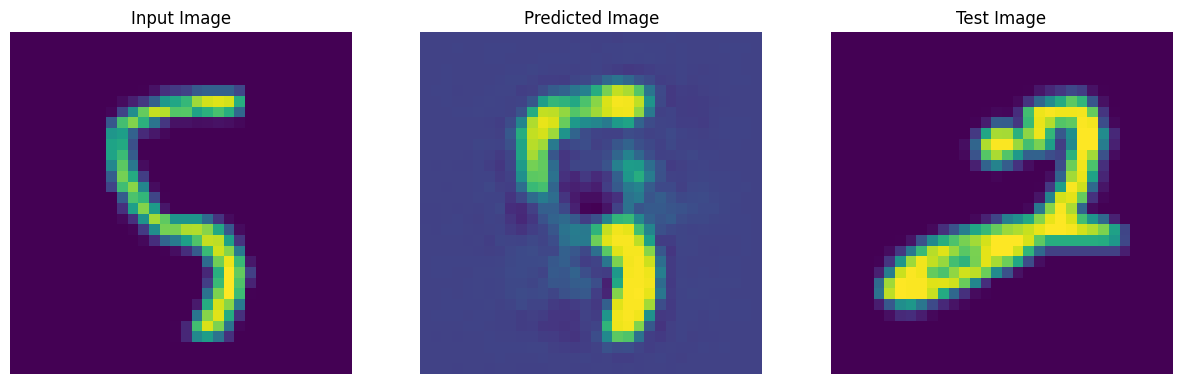

tf.Tensor(0.568116, shape=(), dtype=float32)
tf.Tensor(0.59670705, shape=(), dtype=float32)
tf.Tensor(0.57043815, shape=(), dtype=float32)
tf.Tensor(0.56877, shape=(), dtype=float32)
tf.Tensor(0.56770635, shape=(), dtype=float32)
tf.Tensor(0.5755743, shape=(), dtype=float32)
tf.Tensor(0.58706534, shape=(), dtype=float32)
tf.Tensor(0.55741507, shape=(), dtype=float32)
tf.Tensor(0.5720731, shape=(), dtype=float32)
tf.Tensor(0.55656224, shape=(), dtype=float32)
tf.Tensor(0.572357, shape=(), dtype=float32)
tf.Tensor(0.6015423, shape=(), dtype=float32)
tf.Tensor(0.58617735, shape=(), dtype=float32)
tf.Tensor(0.6026703, shape=(), dtype=float32)
tf.Tensor(0.61177945, shape=(), dtype=float32)
tf.Tensor(0.6151993, shape=(), dtype=float32)
tf.Tensor(0.6175175, shape=(), dtype=float32)
tf.Tensor(0.618009, shape=(), dtype=float32)
tf.Tensor(0.6018149, shape=(), dtype=float32)
tf.Tensor(0.61699796, shape=(), dtype=float32)
tf.Tensor(0.60273284, shape=(), dtype=float32)
tf.Tensor(0.6143361, shape=()

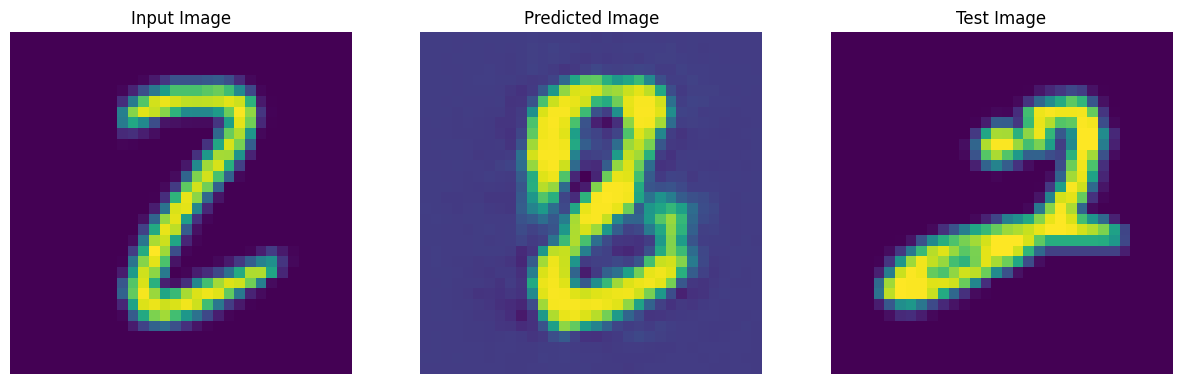

tf.Tensor(0.5618761, shape=(), dtype=float32)
tf.Tensor(0.5739163, shape=(), dtype=float32)
tf.Tensor(0.576547, shape=(), dtype=float32)
tf.Tensor(0.589392, shape=(), dtype=float32)
tf.Tensor(0.5534507, shape=(), dtype=float32)
tf.Tensor(0.5608642, shape=(), dtype=float32)
tf.Tensor(0.5441864, shape=(), dtype=float32)
tf.Tensor(0.5438446, shape=(), dtype=float32)
tf.Tensor(0.5576305, shape=(), dtype=float32)
tf.Tensor(0.5482163, shape=(), dtype=float32)
tf.Tensor(0.5479304, shape=(), dtype=float32)
tf.Tensor(0.5447764, shape=(), dtype=float32)
tf.Tensor(0.53921664, shape=(), dtype=float32)
tf.Tensor(0.55431706, shape=(), dtype=float32)
tf.Tensor(0.57403606, shape=(), dtype=float32)
tf.Tensor(0.5593525, shape=(), dtype=float32)
tf.Tensor(0.57655585, shape=(), dtype=float32)
tf.Tensor(0.56405133, shape=(), dtype=float32)
tf.Tensor(0.53898853, shape=(), dtype=float32)
tf.Tensor(0.54956496, shape=(), dtype=float32)
tf.Tensor(0.55626106, shape=(), dtype=float32)
tf.Tensor(0.5695608, shape=(

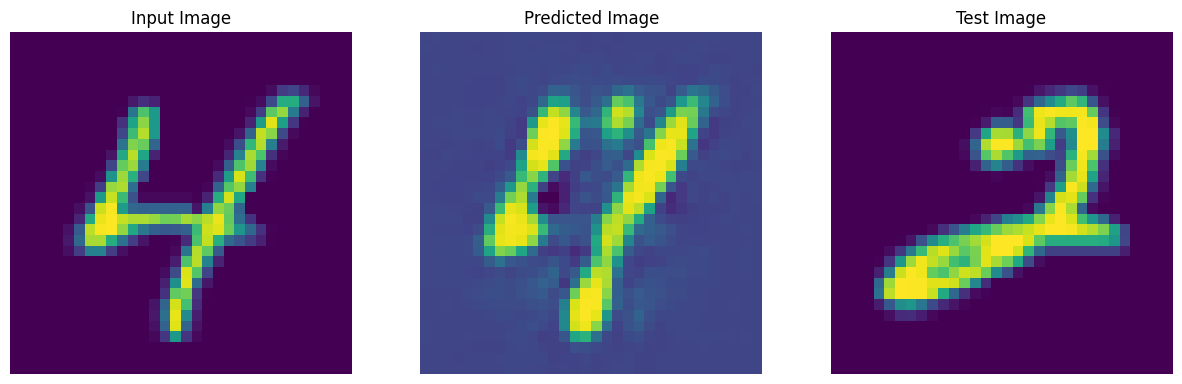

tf.Tensor(0.56084615, shape=(), dtype=float32)
tf.Tensor(0.5557961, shape=(), dtype=float32)
tf.Tensor(0.5490299, shape=(), dtype=float32)
tf.Tensor(0.5574085, shape=(), dtype=float32)
tf.Tensor(0.552815, shape=(), dtype=float32)
tf.Tensor(0.5922154, shape=(), dtype=float32)
tf.Tensor(0.5720705, shape=(), dtype=float32)
tf.Tensor(0.57164043, shape=(), dtype=float32)
tf.Tensor(0.5628749, shape=(), dtype=float32)
tf.Tensor(0.5449484, shape=(), dtype=float32)
tf.Tensor(0.55774105, shape=(), dtype=float32)
tf.Tensor(0.5583179, shape=(), dtype=float32)
tf.Tensor(0.55396694, shape=(), dtype=float32)
tf.Tensor(0.5590263, shape=(), dtype=float32)
tf.Tensor(0.5590385, shape=(), dtype=float32)
tf.Tensor(0.5426231, shape=(), dtype=float32)
tf.Tensor(0.55807376, shape=(), dtype=float32)
tf.Tensor(0.542696, shape=(), dtype=float32)
tf.Tensor(0.55124617, shape=(), dtype=float32)
tf.Tensor(0.5435044, shape=(), dtype=float32)
tf.Tensor(0.5599695, shape=(), dtype=float32)
tf.Tensor(0.5593256, shape=(),

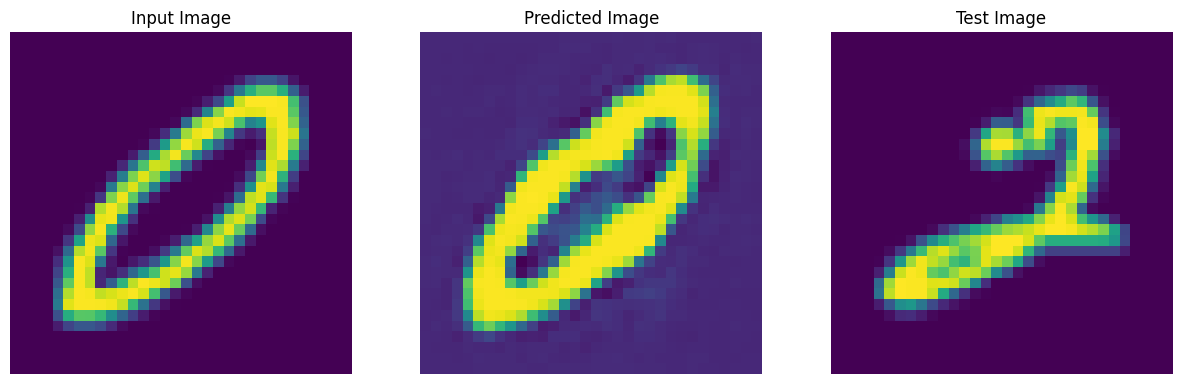

tf.Tensor(0.5385959, shape=(), dtype=float32)
tf.Tensor(0.55852294, shape=(), dtype=float32)
tf.Tensor(0.56354356, shape=(), dtype=float32)
tf.Tensor(0.5504229, shape=(), dtype=float32)
tf.Tensor(0.58108914, shape=(), dtype=float32)
tf.Tensor(0.5450304, shape=(), dtype=float32)
tf.Tensor(0.55474705, shape=(), dtype=float32)
tf.Tensor(0.5519086, shape=(), dtype=float32)
tf.Tensor(0.53441423, shape=(), dtype=float32)
tf.Tensor(0.5381113, shape=(), dtype=float32)
tf.Tensor(0.54238844, shape=(), dtype=float32)
tf.Tensor(0.54104877, shape=(), dtype=float32)
tf.Tensor(0.53348744, shape=(), dtype=float32)
tf.Tensor(0.54388964, shape=(), dtype=float32)
tf.Tensor(0.55093133, shape=(), dtype=float32)
tf.Tensor(0.5325945, shape=(), dtype=float32)
tf.Tensor(0.549863, shape=(), dtype=float32)
tf.Tensor(0.5575402, shape=(), dtype=float32)
tf.Tensor(0.54965806, shape=(), dtype=float32)
tf.Tensor(0.5317834, shape=(), dtype=float32)
tf.Tensor(0.53915125, shape=(), dtype=float32)
tf.Tensor(0.53614247, s

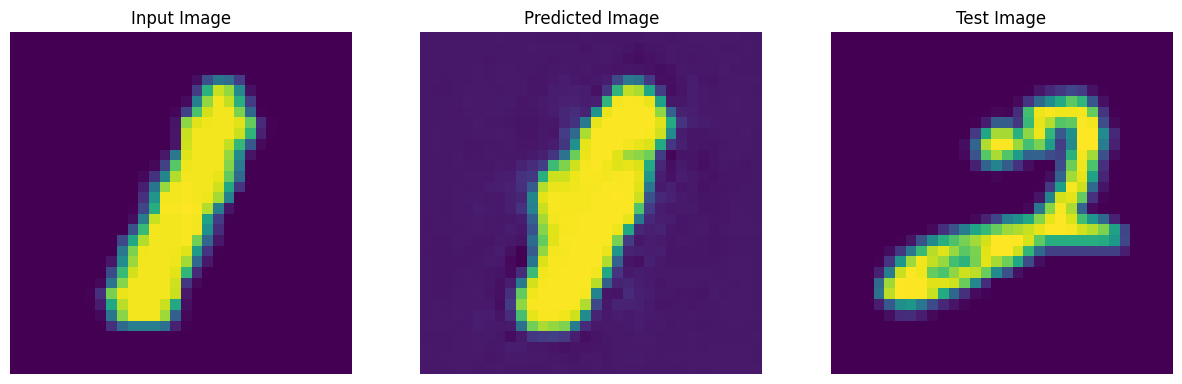

tf.Tensor(0.5421332, shape=(), dtype=float32)
tf.Tensor(0.526432, shape=(), dtype=float32)
tf.Tensor(0.5579866, shape=(), dtype=float32)
tf.Tensor(0.58037007, shape=(), dtype=float32)
tf.Tensor(0.5665388, shape=(), dtype=float32)
tf.Tensor(0.5506678, shape=(), dtype=float32)
tf.Tensor(0.5717837, shape=(), dtype=float32)
tf.Tensor(0.55730486, shape=(), dtype=float32)
tf.Tensor(0.52951944, shape=(), dtype=float32)
tf.Tensor(0.5591582, shape=(), dtype=float32)
tf.Tensor(0.56089246, shape=(), dtype=float32)
tf.Tensor(0.56319046, shape=(), dtype=float32)
tf.Tensor(0.5782862, shape=(), dtype=float32)
tf.Tensor(0.58974284, shape=(), dtype=float32)
tf.Tensor(0.589516, shape=(), dtype=float32)
tf.Tensor(0.60740066, shape=(), dtype=float32)
tf.Tensor(0.5695272, shape=(), dtype=float32)
tf.Tensor(0.5739067, shape=(), dtype=float32)
tf.Tensor(0.5720004, shape=(), dtype=float32)
tf.Tensor(0.57776135, shape=(), dtype=float32)
tf.Tensor(0.60726637, shape=(), dtype=float32)
tf.Tensor(0.60671586, shape

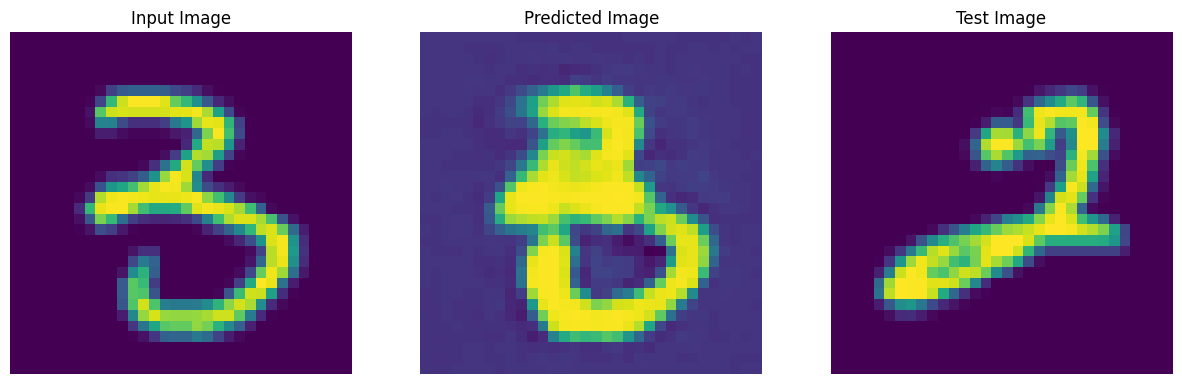

tf.Tensor(0.55616915, shape=(), dtype=float32)
tf.Tensor(0.5304971, shape=(), dtype=float32)
tf.Tensor(0.5488968, shape=(), dtype=float32)
tf.Tensor(0.5381788, shape=(), dtype=float32)
tf.Tensor(0.53868437, shape=(), dtype=float32)
tf.Tensor(0.5248629, shape=(), dtype=float32)
tf.Tensor(0.5499983, shape=(), dtype=float32)
tf.Tensor(0.5658323, shape=(), dtype=float32)
tf.Tensor(0.5449946, shape=(), dtype=float32)
tf.Tensor(0.5493264, shape=(), dtype=float32)
tf.Tensor(0.54994106, shape=(), dtype=float32)
tf.Tensor(0.5435328, shape=(), dtype=float32)
tf.Tensor(0.54407495, shape=(), dtype=float32)
tf.Tensor(0.5226444, shape=(), dtype=float32)
tf.Tensor(0.51745284, shape=(), dtype=float32)
tf.Tensor(0.5523076, shape=(), dtype=float32)
tf.Tensor(0.52358496, shape=(), dtype=float32)
tf.Tensor(0.5416843, shape=(), dtype=float32)
tf.Tensor(0.5387709, shape=(), dtype=float32)
tf.Tensor(0.55039555, shape=(), dtype=float32)
tf.Tensor(0.52907735, shape=(), dtype=float32)
tf.Tensor(0.5465912, shape

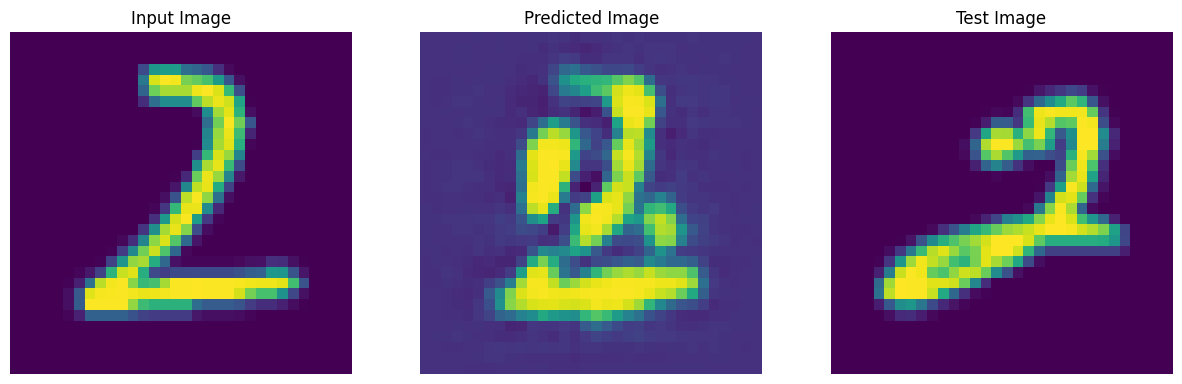

tf.Tensor(0.54855067, shape=(), dtype=float32)
tf.Tensor(0.5449669, shape=(), dtype=float32)
tf.Tensor(0.552382, shape=(), dtype=float32)
tf.Tensor(0.55241555, shape=(), dtype=float32)
tf.Tensor(0.53822124, shape=(), dtype=float32)
tf.Tensor(0.53053665, shape=(), dtype=float32)
tf.Tensor(0.5315653, shape=(), dtype=float32)
tf.Tensor(0.5256014, shape=(), dtype=float32)
tf.Tensor(0.5176199, shape=(), dtype=float32)
tf.Tensor(0.5426094, shape=(), dtype=float32)
tf.Tensor(0.5417407, shape=(), dtype=float32)
tf.Tensor(0.52422017, shape=(), dtype=float32)
tf.Tensor(0.5306459, shape=(), dtype=float32)
tf.Tensor(0.5380247, shape=(), dtype=float32)
tf.Tensor(0.5141115, shape=(), dtype=float32)
tf.Tensor(0.5225199, shape=(), dtype=float32)
tf.Tensor(0.5186274, shape=(), dtype=float32)
tf.Tensor(0.543966, shape=(), dtype=float32)
tf.Tensor(0.52479434, shape=(), dtype=float32)
tf.Tensor(0.51136255, shape=(), dtype=float32)
tf.Tensor(0.5301812, shape=(), dtype=float32)
tf.Tensor(0.51371, shape=(), 

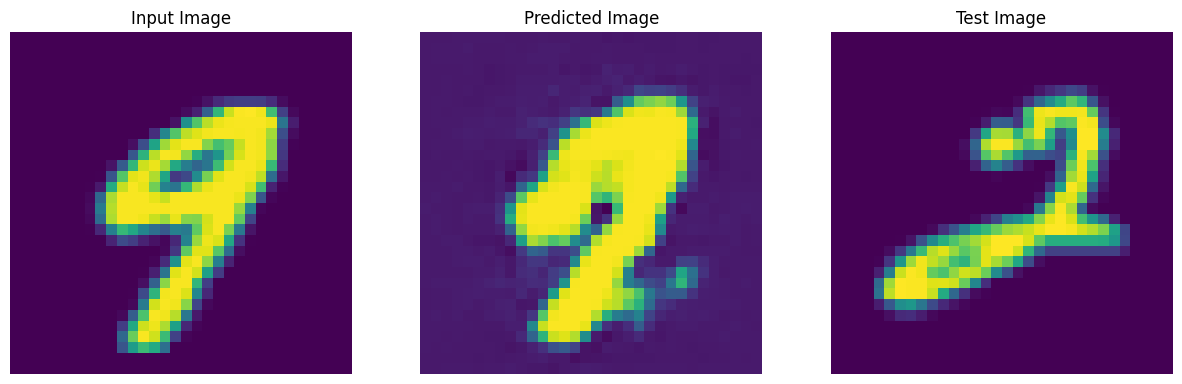

tf.Tensor(0.53140646, shape=(), dtype=float32)
tf.Tensor(0.5288105, shape=(), dtype=float32)
tf.Tensor(0.51186496, shape=(), dtype=float32)
tf.Tensor(0.53306377, shape=(), dtype=float32)
tf.Tensor(0.52030945, shape=(), dtype=float32)
tf.Tensor(0.5313921, shape=(), dtype=float32)
tf.Tensor(0.5292817, shape=(), dtype=float32)
tf.Tensor(0.5234612, shape=(), dtype=float32)
tf.Tensor(0.51942813, shape=(), dtype=float32)
tf.Tensor(0.5163903, shape=(), dtype=float32)
tf.Tensor(0.5038507, shape=(), dtype=float32)
tf.Tensor(0.50097054, shape=(), dtype=float32)
tf.Tensor(0.51854116, shape=(), dtype=float32)
tf.Tensor(0.50543314, shape=(), dtype=float32)
tf.Tensor(0.526108, shape=(), dtype=float32)
tf.Tensor(0.5220838, shape=(), dtype=float32)
tf.Tensor(0.5384943, shape=(), dtype=float32)
tf.Tensor(0.5194835, shape=(), dtype=float32)
tf.Tensor(0.5284118, shape=(), dtype=float32)
tf.Tensor(0.5221047, shape=(), dtype=float32)
tf.Tensor(0.5225189, shape=(), dtype=float32)
tf.Tensor(0.53105927, shape

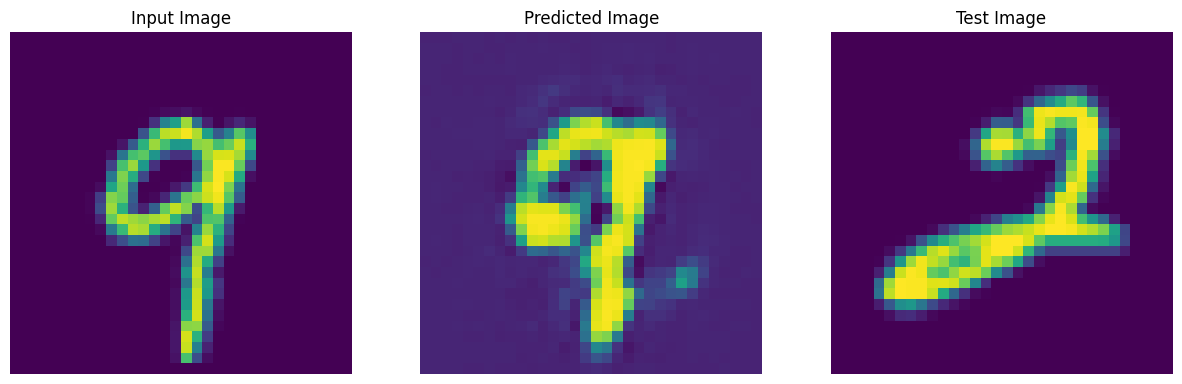

tf.Tensor(0.5012301, shape=(), dtype=float32)
tf.Tensor(0.50934744, shape=(), dtype=float32)
tf.Tensor(0.50129974, shape=(), dtype=float32)
tf.Tensor(0.51485264, shape=(), dtype=float32)
tf.Tensor(0.5155512, shape=(), dtype=float32)
tf.Tensor(0.49710047, shape=(), dtype=float32)
tf.Tensor(0.5165181, shape=(), dtype=float32)
tf.Tensor(0.5054772, shape=(), dtype=float32)
tf.Tensor(0.5240641, shape=(), dtype=float32)
tf.Tensor(0.51535237, shape=(), dtype=float32)
tf.Tensor(0.5181687, shape=(), dtype=float32)
tf.Tensor(0.53180283, shape=(), dtype=float32)
tf.Tensor(0.52552277, shape=(), dtype=float32)
tf.Tensor(0.5122552, shape=(), dtype=float32)
tf.Tensor(0.5216114, shape=(), dtype=float32)
tf.Tensor(0.54835486, shape=(), dtype=float32)
tf.Tensor(0.5347269, shape=(), dtype=float32)
tf.Tensor(0.55628866, shape=(), dtype=float32)
tf.Tensor(0.5402694, shape=(), dtype=float32)
tf.Tensor(0.54860115, shape=(), dtype=float32)
tf.Tensor(0.54928696, shape=(), dtype=float32)
tf.Tensor(0.5494069, sh

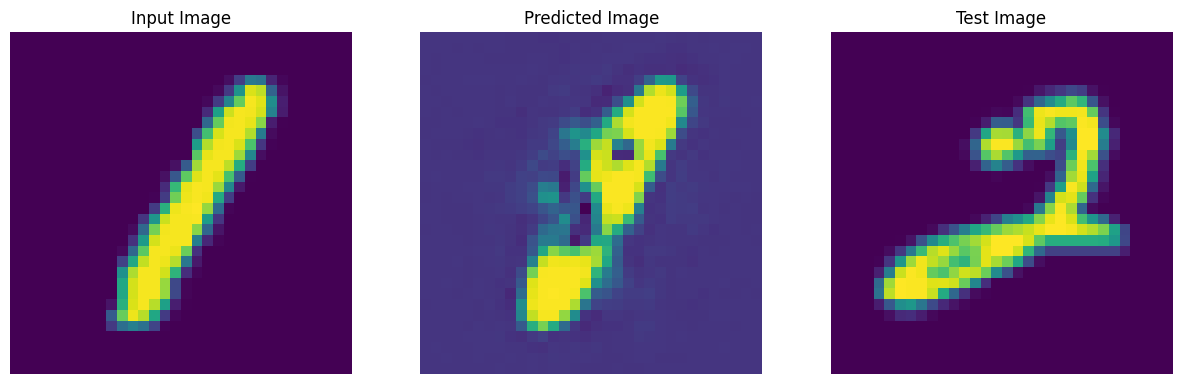

tf.Tensor(0.5122256, shape=(), dtype=float32)
tf.Tensor(0.520722, shape=(), dtype=float32)
tf.Tensor(0.52852094, shape=(), dtype=float32)
tf.Tensor(0.5296495, shape=(), dtype=float32)
tf.Tensor(0.52262604, shape=(), dtype=float32)
tf.Tensor(0.5313845, shape=(), dtype=float32)
tf.Tensor(0.5131198, shape=(), dtype=float32)
tf.Tensor(0.50717014, shape=(), dtype=float32)
tf.Tensor(0.5200912, shape=(), dtype=float32)
tf.Tensor(0.52136475, shape=(), dtype=float32)
tf.Tensor(0.52083, shape=(), dtype=float32)
tf.Tensor(0.51066, shape=(), dtype=float32)
tf.Tensor(0.53225017, shape=(), dtype=float32)
tf.Tensor(0.5602174, shape=(), dtype=float32)
tf.Tensor(0.53057796, shape=(), dtype=float32)
tf.Tensor(0.51404494, shape=(), dtype=float32)
tf.Tensor(0.5319866, shape=(), dtype=float32)
tf.Tensor(0.529145, shape=(), dtype=float32)
tf.Tensor(0.51148707, shape=(), dtype=float32)
tf.Tensor(0.51799566, shape=(), dtype=float32)
tf.Tensor(0.5203519, shape=(), dtype=float32)
tf.Tensor(0.5276955, shape=(), 

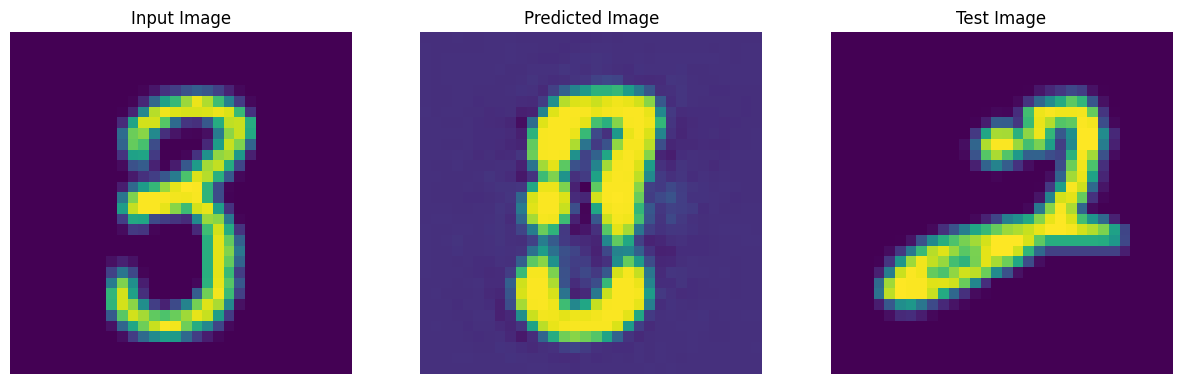

tf.Tensor(0.51868886, shape=(), dtype=float32)
tf.Tensor(0.5117946, shape=(), dtype=float32)
tf.Tensor(0.52290446, shape=(), dtype=float32)
tf.Tensor(0.50377357, shape=(), dtype=float32)
tf.Tensor(0.51029307, shape=(), dtype=float32)
tf.Tensor(0.52265406, shape=(), dtype=float32)
tf.Tensor(0.51086736, shape=(), dtype=float32)
tf.Tensor(0.50671023, shape=(), dtype=float32)
tf.Tensor(0.4989715, shape=(), dtype=float32)
tf.Tensor(0.5130369, shape=(), dtype=float32)
tf.Tensor(0.50293666, shape=(), dtype=float32)
tf.Tensor(0.51551914, shape=(), dtype=float32)
tf.Tensor(0.50336885, shape=(), dtype=float32)
tf.Tensor(0.5179597, shape=(), dtype=float32)
tf.Tensor(0.48574805, shape=(), dtype=float32)
tf.Tensor(0.5067476, shape=(), dtype=float32)
tf.Tensor(0.5083139, shape=(), dtype=float32)
tf.Tensor(0.5264049, shape=(), dtype=float32)
tf.Tensor(0.51847696, shape=(), dtype=float32)
tf.Tensor(0.5052956, shape=(), dtype=float32)
tf.Tensor(0.49389243, shape=(), dtype=float32)
tf.Tensor(0.5004958, 

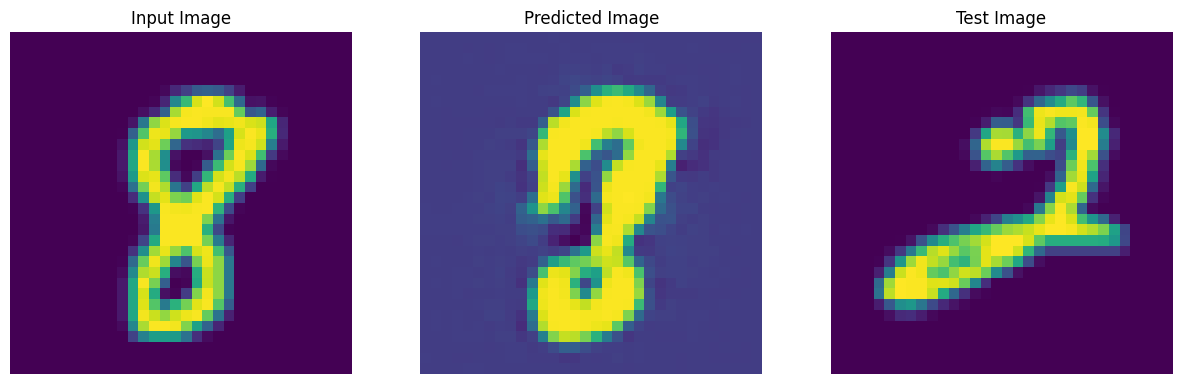

tf.Tensor(0.50535864, shape=(), dtype=float32)
tf.Tensor(0.5048953, shape=(), dtype=float32)
tf.Tensor(0.48952845, shape=(), dtype=float32)
tf.Tensor(0.4968949, shape=(), dtype=float32)
tf.Tensor(0.4833486, shape=(), dtype=float32)
tf.Tensor(0.49563062, shape=(), dtype=float32)
tf.Tensor(0.5216908, shape=(), dtype=float32)
tf.Tensor(0.48952585, shape=(), dtype=float32)
tf.Tensor(0.50950885, shape=(), dtype=float32)
tf.Tensor(0.4863737, shape=(), dtype=float32)
tf.Tensor(0.5084406, shape=(), dtype=float32)
tf.Tensor(0.50536007, shape=(), dtype=float32)
tf.Tensor(0.49952334, shape=(), dtype=float32)
tf.Tensor(0.49698773, shape=(), dtype=float32)
tf.Tensor(0.48632184, shape=(), dtype=float32)
tf.Tensor(0.48612696, shape=(), dtype=float32)
tf.Tensor(0.49109036, shape=(), dtype=float32)
tf.Tensor(0.51485056, shape=(), dtype=float32)
tf.Tensor(0.5099087, shape=(), dtype=float32)
tf.Tensor(0.49609682, shape=(), dtype=float32)
tf.Tensor(0.4923101, shape=(), dtype=float32)
tf.Tensor(0.49360988,

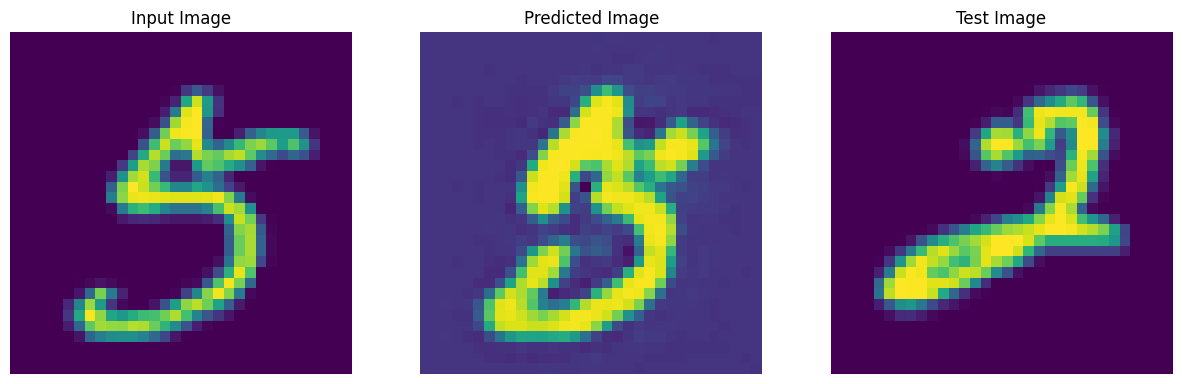

tf.Tensor(0.48369935, shape=(), dtype=float32)
tf.Tensor(0.50014436, shape=(), dtype=float32)
tf.Tensor(0.49109438, shape=(), dtype=float32)
tf.Tensor(0.5120034, shape=(), dtype=float32)
tf.Tensor(0.5139595, shape=(), dtype=float32)
tf.Tensor(0.53000826, shape=(), dtype=float32)
tf.Tensor(0.52583736, shape=(), dtype=float32)
tf.Tensor(0.52045333, shape=(), dtype=float32)
tf.Tensor(0.51747257, shape=(), dtype=float32)
tf.Tensor(0.52045375, shape=(), dtype=float32)
tf.Tensor(0.505434, shape=(), dtype=float32)
tf.Tensor(0.5189765, shape=(), dtype=float32)
tf.Tensor(0.5265797, shape=(), dtype=float32)
tf.Tensor(0.5367596, shape=(), dtype=float32)
tf.Tensor(0.56781214, shape=(), dtype=float32)
tf.Tensor(0.5508223, shape=(), dtype=float32)
tf.Tensor(0.5667975, shape=(), dtype=float32)
tf.Tensor(0.5559383, shape=(), dtype=float32)
tf.Tensor(0.5751562, shape=(), dtype=float32)
tf.Tensor(0.57552415, shape=(), dtype=float32)
tf.Tensor(0.56894946, shape=(), dtype=float32)
tf.Tensor(0.5555682, sha

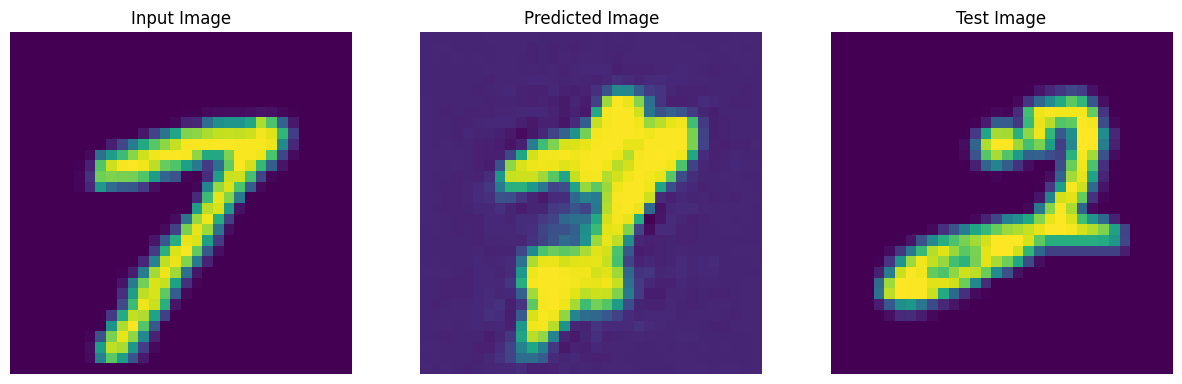

tf.Tensor(0.4902289, shape=(), dtype=float32)
tf.Tensor(0.48901653, shape=(), dtype=float32)
tf.Tensor(0.5039278, shape=(), dtype=float32)
tf.Tensor(0.48688656, shape=(), dtype=float32)
tf.Tensor(0.49932805, shape=(), dtype=float32)
tf.Tensor(0.5237746, shape=(), dtype=float32)
tf.Tensor(0.49967128, shape=(), dtype=float32)
tf.Tensor(0.49250007, shape=(), dtype=float32)
tf.Tensor(0.50401086, shape=(), dtype=float32)
tf.Tensor(0.51104337, shape=(), dtype=float32)
tf.Tensor(0.5135824, shape=(), dtype=float32)
tf.Tensor(0.49836367, shape=(), dtype=float32)
tf.Tensor(0.49650213, shape=(), dtype=float32)
tf.Tensor(0.4908405, shape=(), dtype=float32)
tf.Tensor(0.49284416, shape=(), dtype=float32)
tf.Tensor(0.49762422, shape=(), dtype=float32)
tf.Tensor(0.51238346, shape=(), dtype=float32)
tf.Tensor(0.5094475, shape=(), dtype=float32)
tf.Tensor(0.49935234, shape=(), dtype=float32)
tf.Tensor(0.50537056, shape=(), dtype=float32)
tf.Tensor(0.49941826, shape=(), dtype=float32)
tf.Tensor(0.5107472

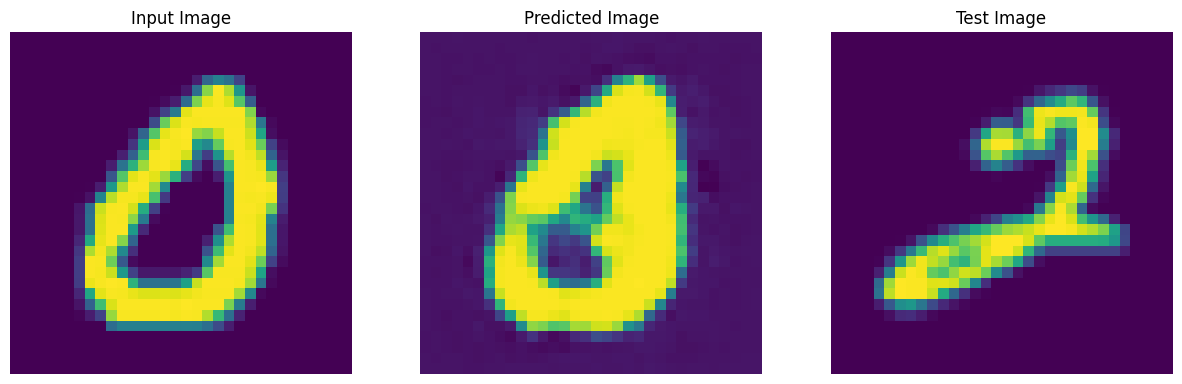

tf.Tensor(0.480867, shape=(), dtype=float32)
tf.Tensor(0.5037865, shape=(), dtype=float32)
tf.Tensor(0.50179154, shape=(), dtype=float32)
tf.Tensor(0.51177794, shape=(), dtype=float32)
tf.Tensor(0.4891041, shape=(), dtype=float32)
tf.Tensor(0.48440748, shape=(), dtype=float32)
tf.Tensor(0.50743467, shape=(), dtype=float32)
tf.Tensor(0.51157105, shape=(), dtype=float32)
tf.Tensor(0.4744289, shape=(), dtype=float32)
tf.Tensor(0.49672228, shape=(), dtype=float32)
tf.Tensor(0.45969915, shape=(), dtype=float32)
tf.Tensor(0.48652345, shape=(), dtype=float32)
tf.Tensor(0.48695415, shape=(), dtype=float32)
tf.Tensor(0.48464137, shape=(), dtype=float32)
tf.Tensor(0.4866906, shape=(), dtype=float32)
tf.Tensor(0.49915105, shape=(), dtype=float32)
tf.Tensor(0.47025067, shape=(), dtype=float32)
tf.Tensor(0.48024434, shape=(), dtype=float32)
tf.Tensor(0.48352236, shape=(), dtype=float32)
tf.Tensor(0.4959908, shape=(), dtype=float32)
tf.Tensor(0.48009536, shape=(), dtype=float32)
tf.Tensor(0.4888074,

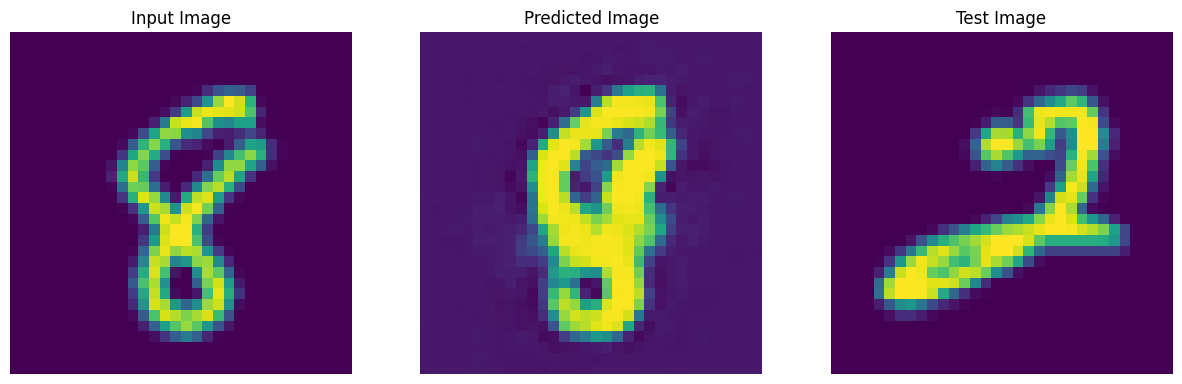

tf.Tensor(0.5210437, shape=(), dtype=float32)
tf.Tensor(0.49810812, shape=(), dtype=float32)
tf.Tensor(0.49569643, shape=(), dtype=float32)
tf.Tensor(0.48239595, shape=(), dtype=float32)
tf.Tensor(0.5006387, shape=(), dtype=float32)
tf.Tensor(0.5067586, shape=(), dtype=float32)
tf.Tensor(0.4704448, shape=(), dtype=float32)
tf.Tensor(0.48206222, shape=(), dtype=float32)
tf.Tensor(0.4832108, shape=(), dtype=float32)
tf.Tensor(0.4823389, shape=(), dtype=float32)
tf.Tensor(0.48473763, shape=(), dtype=float32)
tf.Tensor(0.4784605, shape=(), dtype=float32)
tf.Tensor(0.47773537, shape=(), dtype=float32)
tf.Tensor(0.5134463, shape=(), dtype=float32)
tf.Tensor(0.5154347, shape=(), dtype=float32)
tf.Tensor(0.49789262, shape=(), dtype=float32)
tf.Tensor(0.49121836, shape=(), dtype=float32)
tf.Tensor(0.48219764, shape=(), dtype=float32)
tf.Tensor(0.4868044, shape=(), dtype=float32)
tf.Tensor(0.5074193, shape=(), dtype=float32)
tf.Tensor(0.4798112, shape=(), dtype=float32)
tf.Tensor(0.48057723, sha

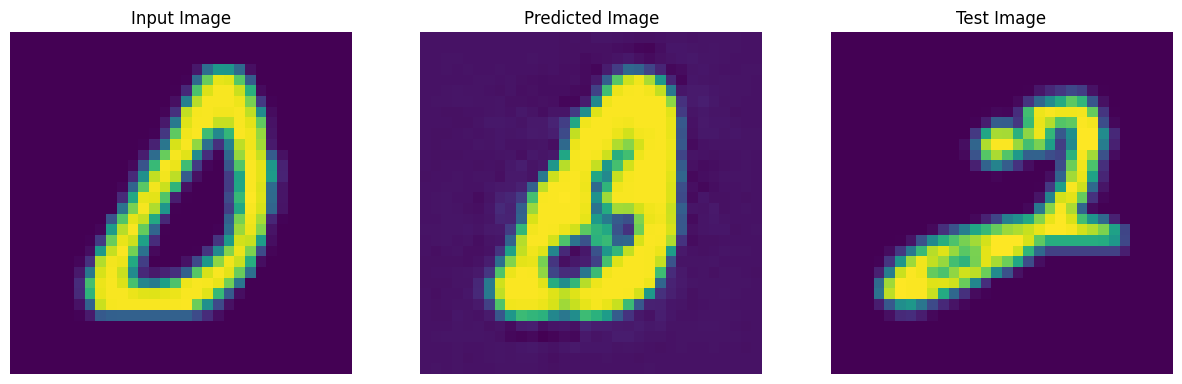

tf.Tensor(0.48076555, shape=(), dtype=float32)
tf.Tensor(0.4865592, shape=(), dtype=float32)
tf.Tensor(0.5062544, shape=(), dtype=float32)
tf.Tensor(0.49025965, shape=(), dtype=float32)
tf.Tensor(0.50144106, shape=(), dtype=float32)
tf.Tensor(0.5138859, shape=(), dtype=float32)
tf.Tensor(0.50178224, shape=(), dtype=float32)
tf.Tensor(0.47716895, shape=(), dtype=float32)
tf.Tensor(0.48806518, shape=(), dtype=float32)
tf.Tensor(0.4986305, shape=(), dtype=float32)
tf.Tensor(0.49106616, shape=(), dtype=float32)
tf.Tensor(0.47904542, shape=(), dtype=float32)
tf.Tensor(0.51676667, shape=(), dtype=float32)
tf.Tensor(0.5265002, shape=(), dtype=float32)
tf.Tensor(0.5119238, shape=(), dtype=float32)
tf.Tensor(0.5230797, shape=(), dtype=float32)
tf.Tensor(0.53990674, shape=(), dtype=float32)
tf.Tensor(0.5412225, shape=(), dtype=float32)
tf.Tensor(0.5102052, shape=(), dtype=float32)
tf.Tensor(0.5221351, shape=(), dtype=float32)
tf.Tensor(0.5252106, shape=(), dtype=float32)
tf.Tensor(0.5150347, sha

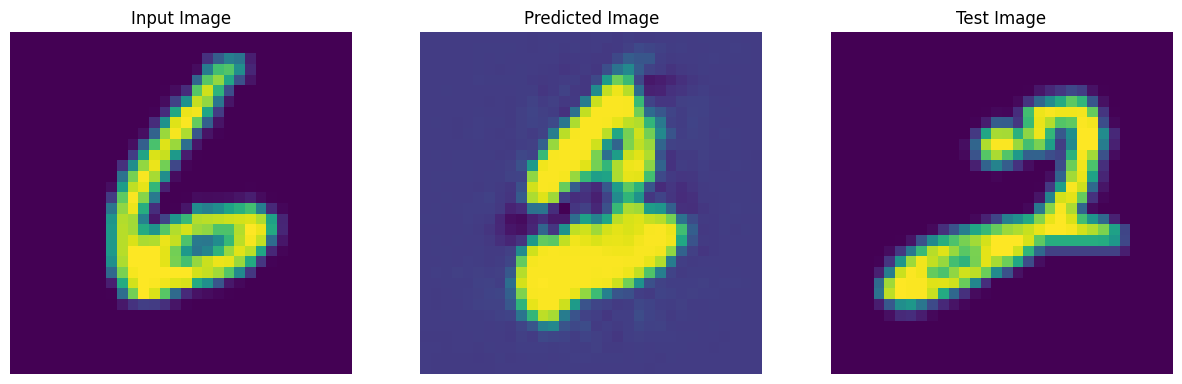

tf.Tensor(0.4833919, shape=(), dtype=float32)
tf.Tensor(0.4632488, shape=(), dtype=float32)
tf.Tensor(0.46512324, shape=(), dtype=float32)
tf.Tensor(0.482828, shape=(), dtype=float32)
tf.Tensor(0.47645766, shape=(), dtype=float32)
tf.Tensor(0.49179772, shape=(), dtype=float32)
tf.Tensor(0.48179325, shape=(), dtype=float32)
tf.Tensor(0.48906872, shape=(), dtype=float32)
tf.Tensor(0.48515654, shape=(), dtype=float32)
tf.Tensor(0.484388, shape=(), dtype=float32)
tf.Tensor(0.4804833, shape=(), dtype=float32)
tf.Tensor(0.4635165, shape=(), dtype=float32)
tf.Tensor(0.46590856, shape=(), dtype=float32)
tf.Tensor(0.46755925, shape=(), dtype=float32)
tf.Tensor(0.45981568, shape=(), dtype=float32)
tf.Tensor(0.48910403, shape=(), dtype=float32)
tf.Tensor(0.48520437, shape=(), dtype=float32)
tf.Tensor(0.47647053, shape=(), dtype=float32)
tf.Tensor(0.5029881, shape=(), dtype=float32)
tf.Tensor(0.483312, shape=(), dtype=float32)
tf.Tensor(0.4675767, shape=(), dtype=float32)
tf.Tensor(0.45409724, sha

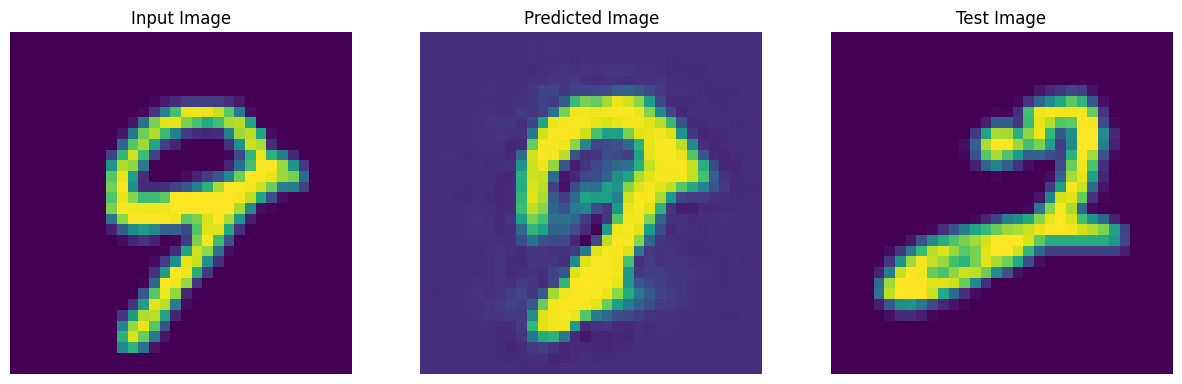

tf.Tensor(0.45406818, shape=(), dtype=float32)
tf.Tensor(0.45660985, shape=(), dtype=float32)
tf.Tensor(0.46776846, shape=(), dtype=float32)
tf.Tensor(0.4557054, shape=(), dtype=float32)
tf.Tensor(0.47128803, shape=(), dtype=float32)
tf.Tensor(0.48016834, shape=(), dtype=float32)
tf.Tensor(0.5022256, shape=(), dtype=float32)
tf.Tensor(0.47688624, shape=(), dtype=float32)
tf.Tensor(0.49616334, shape=(), dtype=float32)
tf.Tensor(0.48439848, shape=(), dtype=float32)
tf.Tensor(0.4868666, shape=(), dtype=float32)
tf.Tensor(0.45719892, shape=(), dtype=float32)
tf.Tensor(0.46560577, shape=(), dtype=float32)
tf.Tensor(0.47410977, shape=(), dtype=float32)
tf.Tensor(0.48697042, shape=(), dtype=float32)
tf.Tensor(0.47551763, shape=(), dtype=float32)
tf.Tensor(0.47131482, shape=(), dtype=float32)
tf.Tensor(0.4692656, shape=(), dtype=float32)
tf.Tensor(0.47500443, shape=(), dtype=float32)
tf.Tensor(0.46760392, shape=(), dtype=float32)
tf.Tensor(0.481078, shape=(), dtype=float32)
tf.Tensor(0.4946032

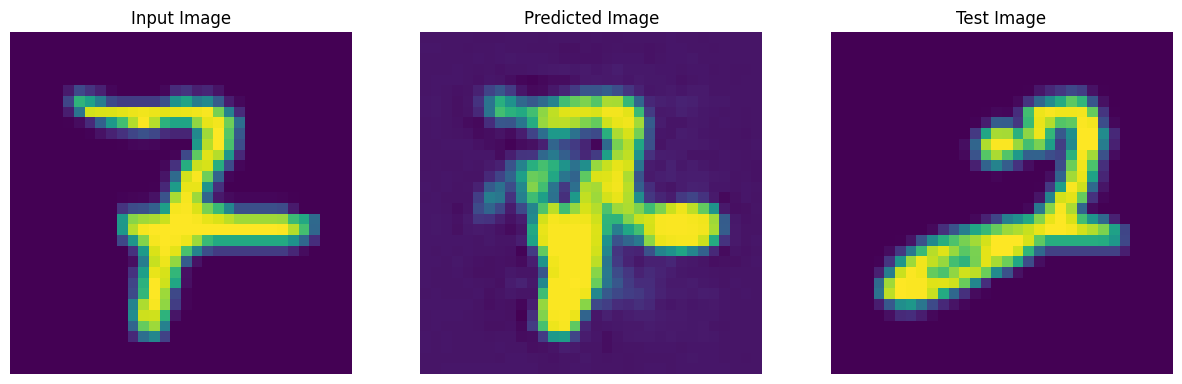

tf.Tensor(0.4846009, shape=(), dtype=float32)
tf.Tensor(0.46887338, shape=(), dtype=float32)
tf.Tensor(0.4619881, shape=(), dtype=float32)
tf.Tensor(0.47070017, shape=(), dtype=float32)
tf.Tensor(0.46729156, shape=(), dtype=float32)
tf.Tensor(0.46153197, shape=(), dtype=float32)
tf.Tensor(0.4830101, shape=(), dtype=float32)
tf.Tensor(0.46219754, shape=(), dtype=float32)
tf.Tensor(0.47443604, shape=(), dtype=float32)
tf.Tensor(0.46999434, shape=(), dtype=float32)
tf.Tensor(0.48397437, shape=(), dtype=float32)
tf.Tensor(0.4664186, shape=(), dtype=float32)
tf.Tensor(0.4577824, shape=(), dtype=float32)
tf.Tensor(0.44301137, shape=(), dtype=float32)
tf.Tensor(0.45862123, shape=(), dtype=float32)
tf.Tensor(0.4611262, shape=(), dtype=float32)
tf.Tensor(0.46610188, shape=(), dtype=float32)
tf.Tensor(0.47443858, shape=(), dtype=float32)
tf.Tensor(0.47779772, shape=(), dtype=float32)
tf.Tensor(0.464734, shape=(), dtype=float32)
tf.Tensor(0.5026361, shape=(), dtype=float32)
tf.Tensor(0.48421636, 

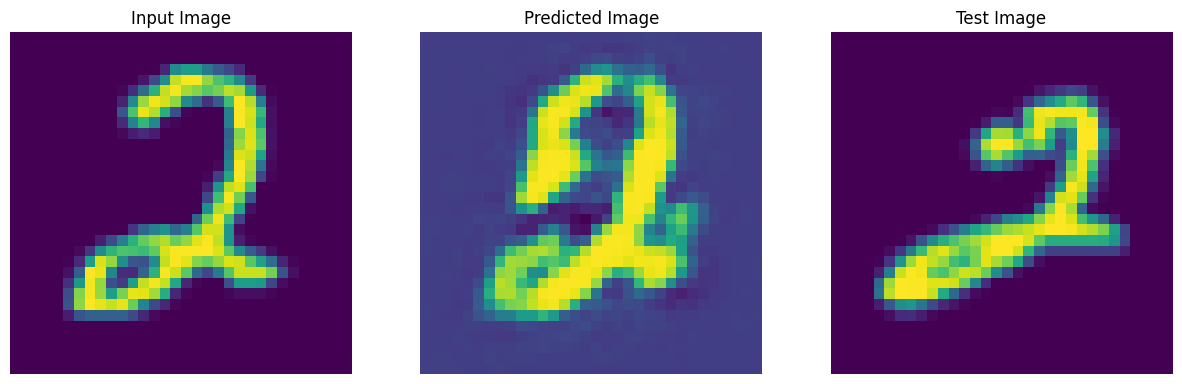

tf.Tensor(0.46626619, shape=(), dtype=float32)
tf.Tensor(0.49242288, shape=(), dtype=float32)
tf.Tensor(0.4871008, shape=(), dtype=float32)
tf.Tensor(0.4888339, shape=(), dtype=float32)
tf.Tensor(0.4930598, shape=(), dtype=float32)
tf.Tensor(0.48112574, shape=(), dtype=float32)
tf.Tensor(0.4889098, shape=(), dtype=float32)
tf.Tensor(0.46703798, shape=(), dtype=float32)
tf.Tensor(0.469482, shape=(), dtype=float32)
tf.Tensor(0.46934983, shape=(), dtype=float32)
tf.Tensor(0.47345376, shape=(), dtype=float32)
tf.Tensor(0.46915472, shape=(), dtype=float32)
tf.Tensor(0.46310762, shape=(), dtype=float32)
tf.Tensor(0.4795886, shape=(), dtype=float32)
tf.Tensor(0.48860374, shape=(), dtype=float32)
tf.Tensor(0.46197915, shape=(), dtype=float32)
tf.Tensor(0.47669575, shape=(), dtype=float32)
tf.Tensor(0.4811689, shape=(), dtype=float32)
tf.Tensor(0.45535707, shape=(), dtype=float32)
tf.Tensor(0.4869628, shape=(), dtype=float32)
tf.Tensor(0.5015817, shape=(), dtype=float32)
tf.Tensor(0.45828107, s

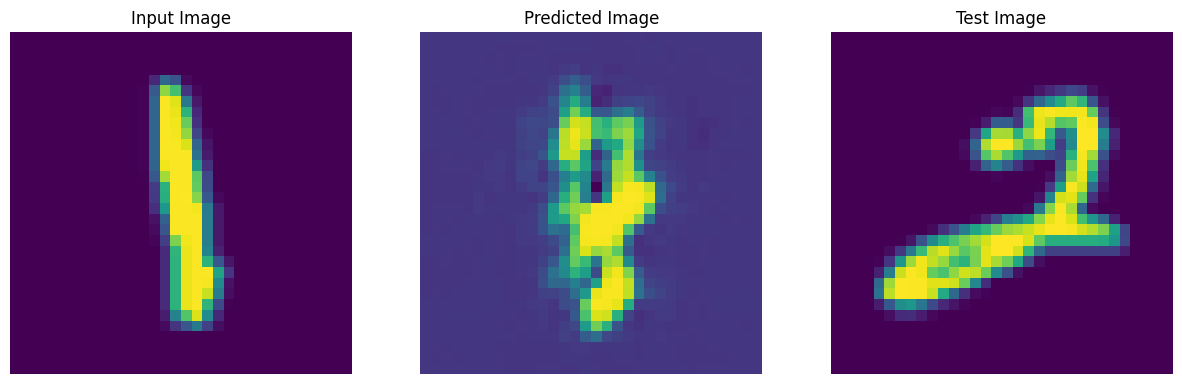

tf.Tensor(0.4468156, shape=(), dtype=float32)
tf.Tensor(0.44116563, shape=(), dtype=float32)
tf.Tensor(0.45528942, shape=(), dtype=float32)
tf.Tensor(0.44026175, shape=(), dtype=float32)
tf.Tensor(0.44342077, shape=(), dtype=float32)
tf.Tensor(0.45104295, shape=(), dtype=float32)
tf.Tensor(0.44391927, shape=(), dtype=float32)
tf.Tensor(0.43952042, shape=(), dtype=float32)
tf.Tensor(0.44574165, shape=(), dtype=float32)
tf.Tensor(0.43513379, shape=(), dtype=float32)
tf.Tensor(0.44163954, shape=(), dtype=float32)
tf.Tensor(0.43047032, shape=(), dtype=float32)
tf.Tensor(0.4640656, shape=(), dtype=float32)
tf.Tensor(0.45120314, shape=(), dtype=float32)
tf.Tensor(0.46244183, shape=(), dtype=float32)
tf.Tensor(0.4556348, shape=(), dtype=float32)
tf.Tensor(0.44202113, shape=(), dtype=float32)
tf.Tensor(0.4586169, shape=(), dtype=float32)
tf.Tensor(0.43351167, shape=(), dtype=float32)
tf.Tensor(0.45787138, shape=(), dtype=float32)
tf.Tensor(0.44895667, shape=(), dtype=float32)
tf.Tensor(0.43522

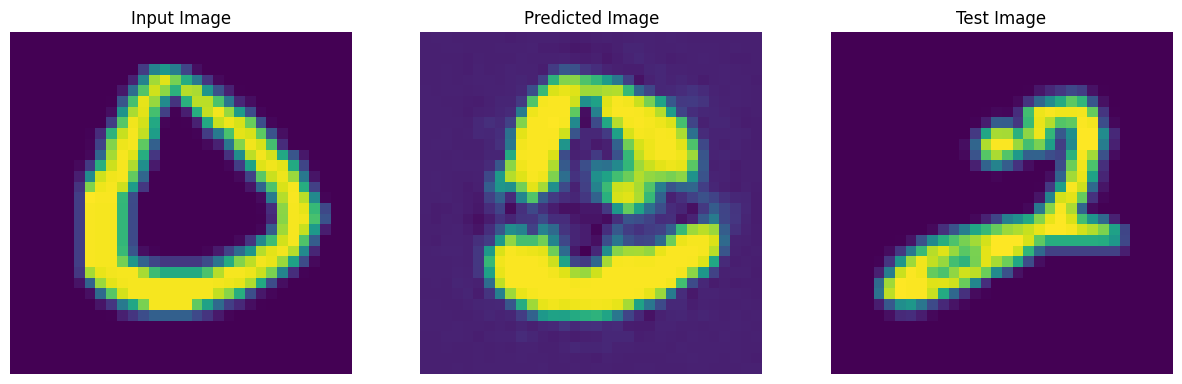

tf.Tensor(0.45408297, shape=(), dtype=float32)
tf.Tensor(0.4549438, shape=(), dtype=float32)
tf.Tensor(0.45189777, shape=(), dtype=float32)
tf.Tensor(0.42989108, shape=(), dtype=float32)
tf.Tensor(0.45286775, shape=(), dtype=float32)
tf.Tensor(0.4507631, shape=(), dtype=float32)
tf.Tensor(0.4537717, shape=(), dtype=float32)
tf.Tensor(0.43827176, shape=(), dtype=float32)
tf.Tensor(0.43995127, shape=(), dtype=float32)
tf.Tensor(0.4519464, shape=(), dtype=float32)
tf.Tensor(0.4401922, shape=(), dtype=float32)
tf.Tensor(0.4459041, shape=(), dtype=float32)
tf.Tensor(0.4581906, shape=(), dtype=float32)
tf.Tensor(0.4576968, shape=(), dtype=float32)
tf.Tensor(0.44418842, shape=(), dtype=float32)
tf.Tensor(0.4607291, shape=(), dtype=float32)
tf.Tensor(0.4443147, shape=(), dtype=float32)
tf.Tensor(0.4592561, shape=(), dtype=float32)
tf.Tensor(0.44013667, shape=(), dtype=float32)
tf.Tensor(0.44638613, shape=(), dtype=float32)
tf.Tensor(0.44984752, shape=(), dtype=float32)
tf.Tensor(0.45047402, sh

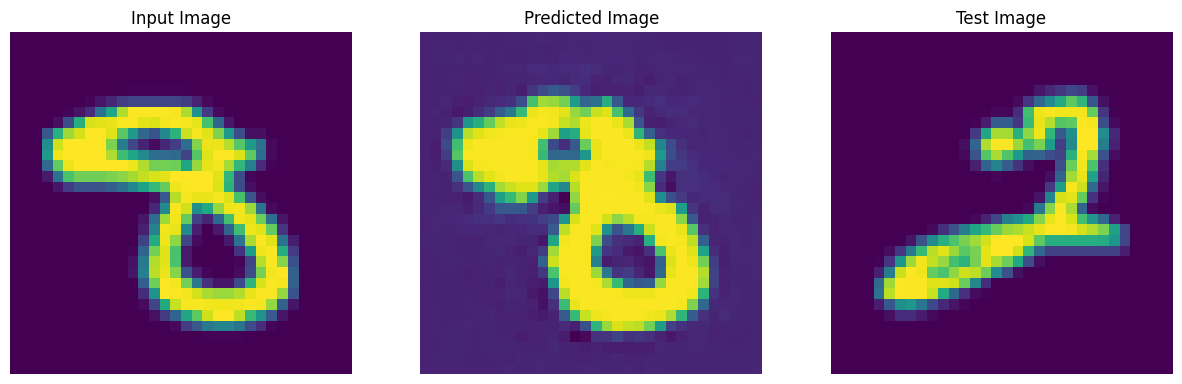

tf.Tensor(0.4478696, shape=(), dtype=float32)
tf.Tensor(0.45301464, shape=(), dtype=float32)
tf.Tensor(0.44900534, shape=(), dtype=float32)
tf.Tensor(0.438122, shape=(), dtype=float32)
tf.Tensor(0.4491913, shape=(), dtype=float32)
tf.Tensor(0.43087977, shape=(), dtype=float32)
tf.Tensor(0.45796388, shape=(), dtype=float32)
tf.Tensor(0.4447529, shape=(), dtype=float32)
tf.Tensor(0.43849584, shape=(), dtype=float32)
tf.Tensor(0.45093268, shape=(), dtype=float32)
tf.Tensor(0.4418423, shape=(), dtype=float32)
tf.Tensor(0.44024494, shape=(), dtype=float32)
tf.Tensor(0.44224328, shape=(), dtype=float32)
tf.Tensor(0.4414357, shape=(), dtype=float32)
tf.Tensor(0.43842787, shape=(), dtype=float32)
tf.Tensor(0.43087918, shape=(), dtype=float32)
tf.Tensor(0.4572298, shape=(), dtype=float32)
tf.Tensor(0.44816265, shape=(), dtype=float32)
tf.Tensor(0.44320473, shape=(), dtype=float32)
tf.Tensor(0.47092107, shape=(), dtype=float32)
tf.Tensor(0.4632353, shape=(), dtype=float32)
tf.Tensor(0.44656545, 

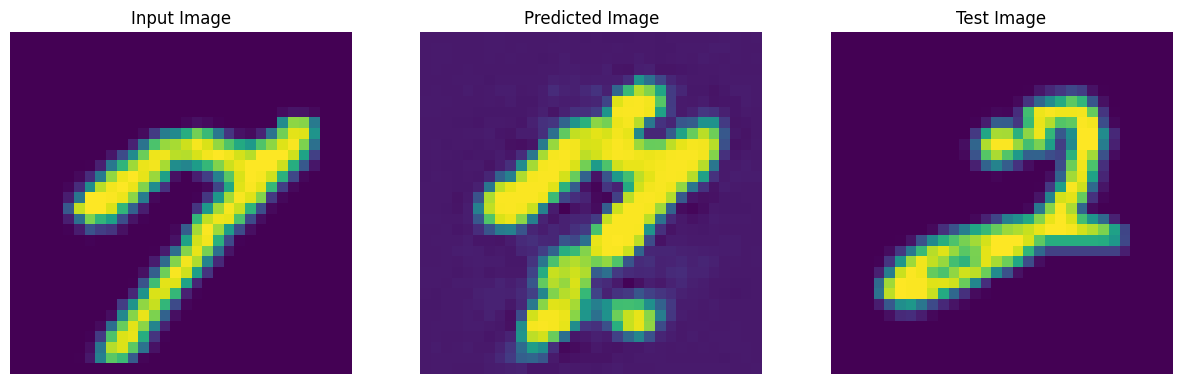

tf.Tensor(0.41330948, shape=(), dtype=float32)
tf.Tensor(0.42730102, shape=(), dtype=float32)
tf.Tensor(0.442809, shape=(), dtype=float32)
tf.Tensor(0.45677048, shape=(), dtype=float32)
tf.Tensor(0.43978292, shape=(), dtype=float32)
tf.Tensor(0.4419097, shape=(), dtype=float32)
tf.Tensor(0.458166, shape=(), dtype=float32)
tf.Tensor(0.46082616, shape=(), dtype=float32)
tf.Tensor(0.46262968, shape=(), dtype=float32)
tf.Tensor(0.44681793, shape=(), dtype=float32)
tf.Tensor(0.46345496, shape=(), dtype=float32)
tf.Tensor(0.4693323, shape=(), dtype=float32)
tf.Tensor(0.4808274, shape=(), dtype=float32)
tf.Tensor(0.46445513, shape=(), dtype=float32)
tf.Tensor(0.48248735, shape=(), dtype=float32)
tf.Tensor(0.4755781, shape=(), dtype=float32)
tf.Tensor(0.46753424, shape=(), dtype=float32)
tf.Tensor(0.4878248, shape=(), dtype=float32)
tf.Tensor(0.5000944, shape=(), dtype=float32)
tf.Tensor(0.48635513, shape=(), dtype=float32)
tf.Tensor(0.483377, shape=(), dtype=float32)
tf.Tensor(0.4932028, shap

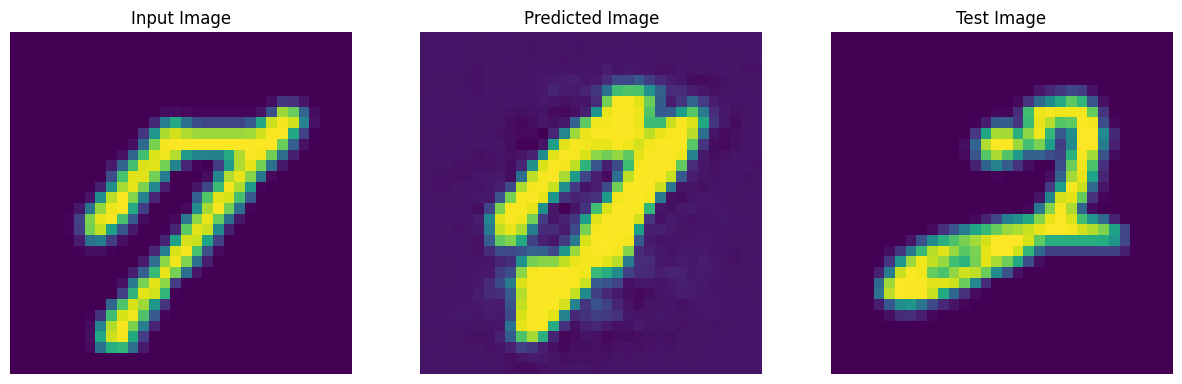

tf.Tensor(0.43887144, shape=(), dtype=float32)
tf.Tensor(0.44155973, shape=(), dtype=float32)
tf.Tensor(0.44383144, shape=(), dtype=float32)
tf.Tensor(0.44687912, shape=(), dtype=float32)
tf.Tensor(0.41821668, shape=(), dtype=float32)
tf.Tensor(0.44318965, shape=(), dtype=float32)
tf.Tensor(0.44724125, shape=(), dtype=float32)
tf.Tensor(0.43396527, shape=(), dtype=float32)
tf.Tensor(0.4358493, shape=(), dtype=float32)
tf.Tensor(0.42784917, shape=(), dtype=float32)
tf.Tensor(0.4262446, shape=(), dtype=float32)
tf.Tensor(0.4268602, shape=(), dtype=float32)
tf.Tensor(0.4293113, shape=(), dtype=float32)
tf.Tensor(0.41136256, shape=(), dtype=float32)
tf.Tensor(0.42530733, shape=(), dtype=float32)
tf.Tensor(0.4331388, shape=(), dtype=float32)
tf.Tensor(0.44174296, shape=(), dtype=float32)
tf.Tensor(0.44978744, shape=(), dtype=float32)
tf.Tensor(0.4417311, shape=(), dtype=float32)
tf.Tensor(0.44194552, shape=(), dtype=float32)
tf.Tensor(0.4172614, shape=(), dtype=float32)
tf.Tensor(0.44079882

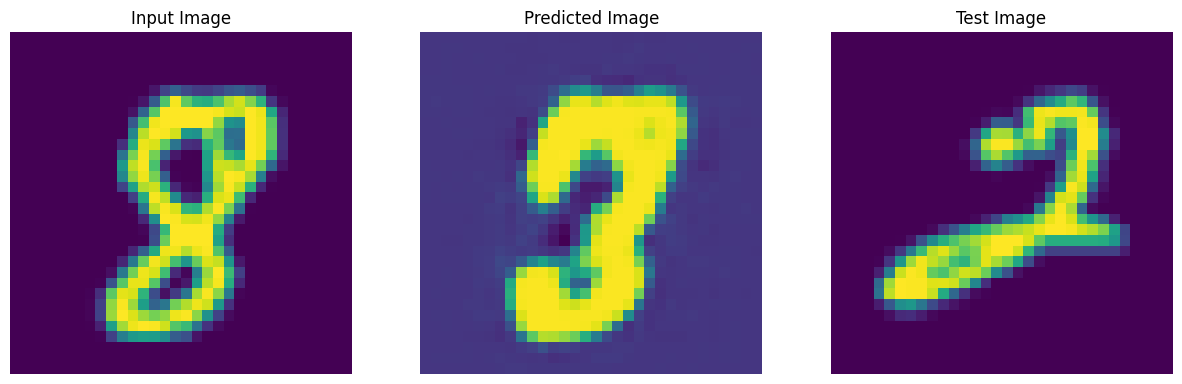

tf.Tensor(0.42748398, shape=(), dtype=float32)
tf.Tensor(0.43106765, shape=(), dtype=float32)
tf.Tensor(0.41626212, shape=(), dtype=float32)
tf.Tensor(0.4134906, shape=(), dtype=float32)
tf.Tensor(0.4354634, shape=(), dtype=float32)
tf.Tensor(0.42319041, shape=(), dtype=float32)
tf.Tensor(0.43787226, shape=(), dtype=float32)
tf.Tensor(0.4277581, shape=(), dtype=float32)
tf.Tensor(0.4163556, shape=(), dtype=float32)
tf.Tensor(0.43364874, shape=(), dtype=float32)
tf.Tensor(0.42820925, shape=(), dtype=float32)
tf.Tensor(0.4372597, shape=(), dtype=float32)
tf.Tensor(0.43770838, shape=(), dtype=float32)
tf.Tensor(0.4270966, shape=(), dtype=float32)
tf.Tensor(0.44505656, shape=(), dtype=float32)
tf.Tensor(0.43935212, shape=(), dtype=float32)
tf.Tensor(0.44581985, shape=(), dtype=float32)
tf.Tensor(0.4460186, shape=(), dtype=float32)
tf.Tensor(0.44300997, shape=(), dtype=float32)
tf.Tensor(0.4548133, shape=(), dtype=float32)
tf.Tensor(0.45876914, shape=(), dtype=float32)
tf.Tensor(0.4408812, 

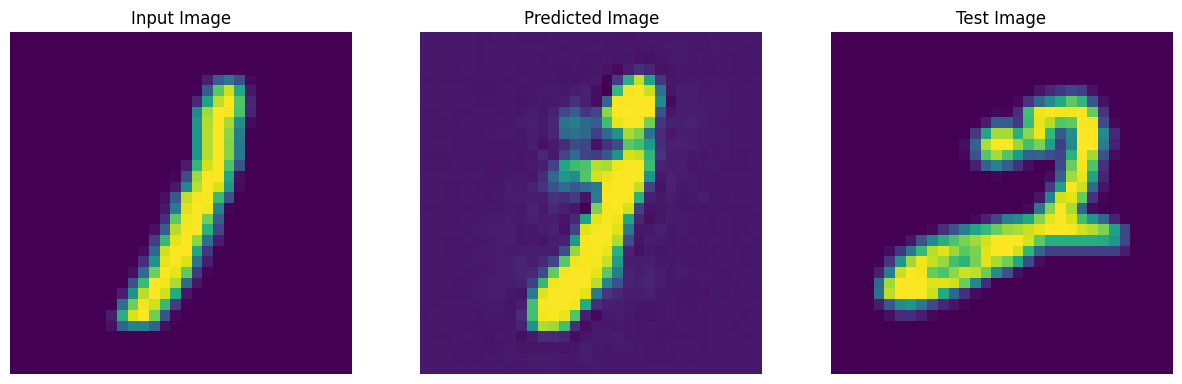

tf.Tensor(0.4423104, shape=(), dtype=float32)
tf.Tensor(0.44363624, shape=(), dtype=float32)
tf.Tensor(0.4467618, shape=(), dtype=float32)
tf.Tensor(0.44239858, shape=(), dtype=float32)
tf.Tensor(0.42578948, shape=(), dtype=float32)
tf.Tensor(0.45038822, shape=(), dtype=float32)
tf.Tensor(0.46157598, shape=(), dtype=float32)
tf.Tensor(0.45841578, shape=(), dtype=float32)
tf.Tensor(0.44767904, shape=(), dtype=float32)
tf.Tensor(0.44419718, shape=(), dtype=float32)
tf.Tensor(0.45225203, shape=(), dtype=float32)
tf.Tensor(0.44991153, shape=(), dtype=float32)
tf.Tensor(0.44599712, shape=(), dtype=float32)
tf.Tensor(0.44479102, shape=(), dtype=float32)
tf.Tensor(0.4486794, shape=(), dtype=float32)
tf.Tensor(0.4354575, shape=(), dtype=float32)
tf.Tensor(0.4295113, shape=(), dtype=float32)
tf.Tensor(0.43730268, shape=(), dtype=float32)
tf.Tensor(0.43959606, shape=(), dtype=float32)
tf.Tensor(0.4240929, shape=(), dtype=float32)
tf.Tensor(0.44212484, shape=(), dtype=float32)
tf.Tensor(0.420052,

In [12]:
# # generator
# # unet = UNet(input_shape=[32, 32, 3])
unet = CUNet(input_shape=[32, 32, 1])
# # unet = DiffusionUnet(img_channels=1)

for t in range(100):
    #Generator training
    TRAIN_STEP = 400
    for j in range(TRAIN_STEP):
        train_data = iter_train.get_next()
        idx = random.sample(range(len(model_opt)), GIAO_BATCH)
        labels = [opt_label[i] for i in idx]
        regs = [model_opt[i] for i in idx]
        giao_train_loss, pseudo_inputs = _opt_train_step(unet, regs, train_data["inputs"], test_data["labels"], labels)
        if j % 100 == 0:
            print("Epoch:{} GIAO Train Loss:{}".format(j, giao_train_loss))
            save_name = "{}_{}_{}".format(t,j,giao_train_loss) 
            display([train_data["inputs"].numpy()[0], pseudo_inputs.numpy()[0], test_data["inputs"][0]], save_name=save_name)
            
    # Train on Dasamples
    model_opt = []
    opt_label = []
    records = edict({'epoch':[],'train_loss':[],'test_loss':[],'train_metric':[],'test_metric':[]})
    obtain_da_model_opts(unet=unet, sample_start=0, sample_gap=3, epochs=3)
    print(len(model_opt))

In [ ]:
# code test
for i in range(3):
    display([train_data["inputs"].numpy()[i], pseudo_inputs.numpy()[i], test_data["inputs"].numpy()[i]])

In [ ]:
# save model opt
hard_save_model_opt(model_opt)

In [ ]:
# load model opt
model_opt = load_model_opt()

In [ ]:
# metrics visualization
plot_train([records.train_loss, records.test_loss])
plot_train([opt_label, opt_label])